# Metodologia Final - Treinamento e Avaliação dos Aparelhos na Base REDD

Com os resultados obtidos até aqui foi possível consolidar a metodologia final que será adotada na pesquisa, a qual é estruturada em:

1. Taxa Amostral e Janela flexível por Aparelho;
2. Gráfico de Recorrência como ferramenta de pré-processamento da série temporal;
3. Rede Neural Convolucional como modelo classificador;
4. Estratégia de treinamento do modelo:
    * Transfer Learning do Aparelho em Outras residências;
    * Treinamento utilizando Punição para o Desbalanceamento de classes;
    * Adoção de Parada Antecipada (em função de AUC, a fim de otimizar sensibilidade);
    * Uso de Threshold-adaptativo;
    * Avaliação de Carga Descartada (threshold).
    
Sendo assim, neste estudo iremos aplicar a metodologia nos dados da base REDD, especificamente na residência 3.


# Configurações

In [1]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

from tqdm import *

from pretty_confusion_matrix import *

# TODO: implementar rotina na classe PyNILM.utils
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def listar_variaveis_memoria(ambiente):
    print("* Variáveis instanciadas em memória:")
    print("---")
    total = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in ambiente.items()),
                             key= lambda x: -x[1])[:10]:
        total += size
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    print("---")
    print("Total:", sizeof_fmt(total))
    
# TODO: implementar na classe utils
def highlight_col(x):
    r = 'background-color: #D9D9D9'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, -2] = r
    return df1   

In [2]:
# CONSTANTES FUNDAMENTAIS DE ORGANIZACAO DE PASTAS/ARQUIVOS

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "20") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_redd = os.path.join(caminho_dados, "REDD/low_freq")

# Path completo do arquivo REDD
arquivo_dataset = os.path.join(caminho_redd, "redd.h5")

# VARIAVEL AUXILIAR
# Path dos arquivos relacionados as janelas
caminho_janelas = os.path.join(caminho_redd, "../../phd")
if not os.path.isdir(caminho_janelas):
    os.makedirs(caminho_janelas)

# Dados

## Base REDD

In [3]:
# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
if not os.path.isfile(arquivo_dataset):
    from nilmtk.dataset_converters import convert_redd
    
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_redd, arquivo_dataset)

# Carregando dataset REDD no objeto NILMTK
# Exemplo de carregamento da base REDD no NILMTK
import h5py # * Evitar erro de incompatibilidade entre h5py e nilmtk
from nilmtk import DataSet
from nilmtk.utils import print_dict
redd = DataSet(arquivo_dataset)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)
print()

# Parametros dos dados
PARAMETROS_DATASET = {
    "base":redd,
    "id_residencia":3,
    "inicio_intervalo":'2011-04-16 05:11:30',
    "fim_intervalo":'2011-04-23 08:43:26',
    "debug": False    
}
print("PARÂMETROS DO ESTUDO:")
pprint(PARAMETROS_DATASET)

NILMTK -> Detalhes sobre o dataset REDD:



PARÂMETROS DO ESTUDO:
{'base': <nilmtk.dataset.DataSet object at 0x000001716DAA21D0>,
 'debug': False,
 'fim_intervalo': '2011-04-23 08:43:26',
 'id_residencia': 3,
 'inicio_intervalo': '2011-04-16 05:11:30'}


In [4]:
def carregar_dados_aparelho(janelas, instancia, aparelho, taxa, tamanho_janela, split_teste=None, eliminar_janelas_vazias=False, debug=False):
    # Extrair series divididas em janelas para cada medidor
    dados_cargas = janelas.preparar(
        taxa_amostral=taxa, 
        intervalo_medicao=tamanho_janela
    )
    print()

    # Pprearando dados (Serie / Estado)
    # X
    dados_medidores = janelas.filtrar_cargas(
        dados_cargas,
        filtros=[
            (1, 'site_meter'),
            (2, 'site_meter'),    
        ]
    )
    
    dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia, aparelho)])[0]
    
    # Validar tamanho dos dados de medidores (podem ter mais registros que os aparelhos)
    janela_media_medidores = int(np.sum([len(d["janelas"])for d in dados_medidores])/len(dados_medidores))
    janela_media_aparelho = len(dados_aparelho["janelas"])#int(np.sum([len(d["janelas"])for d in dados_aparelho])/len(dados_aparelho))

    # Ajustando para medidores terem o mesmo shape de janelas dos aparelhos 
    if janela_media_medidores > janela_media_aparelho:
        diferenca = janela_media_medidores-janela_media_aparelho
        #if debug: print("  -> Diferenca encontrada entre medidores/aparelhos:", diferenca, ", ajustando..")
        for i in range(len(dados_medidores)):
            removidos = 0
            while removidos < diferenca:
                # Remover ultima janela
                dados_medidores[i]["janelas"] = dados_medidores[i]["janelas"][:-1,:]
                removidos += 1
    
    # Estruturando dados modelagem (X e y)
    X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]

    # Selecionando apenas janelas VALIDAS (ocorrencia de ao menos 1 carga)
    # TODO: Implementar na biblioteca esta rotina de validacao
    if eliminar_janelas_vazias:
        idx_janelas_validas = np.where(np.sum(X, axis=1)>0)[0]
        X = X[idx_janelas_validas]
        #for i in range(len(dados_aparelhos)):
        dados_aparelho["janelas"] = dados_aparelho["janelas"][idx_janelas_validas]
        rotulos = copy.deepcopy(dados_aparelho["rotulos"])
        dados_aparelho["rotulos"]["estado"] = rotulos["estado"][idx_janelas_validas]
        dados_aparelho["rotulos"]["media"]  = rotulos["media"][idx_janelas_validas]
        dados_aparelho["rotulos"]["total"]  = rotulos["total"][idx_janelas_validas]
        if debug:
            print("   - `{}-{}`: {} => {}".format(
                dados_aparelho["carga"].upper(), 
                dados_aparelho["instancia"],
                Counter(rotulos["estado"]),
                Counter(dados_aparelho["rotulos"]["estado"])
            ))

    # y
    y = dados_aparelho["rotulos"]["estado"]

    # <<< Limpando memoria >>>
    dados_cargas = None
    del dados_cargas
    dados_medidores = None
    del dados_medidores
    dados_aparelho = None
    del dados_aparelho
    gc.collect()
    # <<< Limpando memoria >>>

    # Fazendo split dos dados (treino/teste)
    if split_teste is None:
        return X, y
    else:
        X_treino, X_teste, y_treino, y_teste = train_test_split(
            X, y, 
            test_size=split_teste,
            stratify=y,
            random_state=SEED
        )
        print()

        return X_treino, X_teste, y_treino, y_teste        
        

## Melhores Combinações de Taxas e Janelas para cada Aparelho (estudo 19)

In [5]:
df_melhores_taxas_janelas = pd.read_csv(os.path.join(caminho_dados, "19", "melhores_taxa_janela_aparelhos.csv"), index_col=0)
df_melhores_taxas_janelas

,carga,taxa_amostragem,janela,loss,acuracia,precisao,recall,f1,f1_macro
0,sockets - 3,3,90,2.314749e-01,0.986014,40.00,66.67,50.00,74.65
1,sockets - 4,3,30,1.049300e-09,1.000000,0.00,0.00,0.00,100.00
2,light - 5,4,360,7.989106e-03,1.000000,0.00,0.00,0.00,100.00
3,ce_appliance - 6,3,30,1.013742e-09,1.000000,100.00,100.00,100.00,100.00
4,fridge - 7,8,1080,4.944706e-04,1.000000,100.00,100.00,100.00,100.00
5,waste_disposal_unit - 8,4,900,2.370523e+00,0.790698,11.11,50.00,18.18,53.09
6,dish_washer - 9,5,360,9.249995e-02,0.976744,50.00,50.00,50.00,74.40
7,electric_furnace - 10,5,720,1.154453e+00,0.906977,83.33,62.50,71.43,82.94
8,light - 11,8,900,2.041479e-01,0.909091,85.71,85.71,85.71,89.52
9,sockets - 12,5,540,2.085883e+00,0.859649,75.00,30.00,42.86,67.43


In [6]:
# TODO: 
# - Desenvolver módulo da metodologia na lib PyNILM

## Parâmetros de RP dos Aparelhos (estudo 18)

In [7]:
# Carregando arquivos de parametros, caso n estejam (kernel reiniciado)
if not 'parametros_rp_aparelho' in locals():
    with open(os.path.join(caminho_dados, "18", "parametros_rp_aparelho.json"),'r') as arquivo:
        parametros_rp_aparelho = json.load(arquivo)

# Metodologia
---

Aplicação da metodologia nos aparelhos.

## Ambiente e Funções Auxiliares

### Preparando ambiente de desenvolvimento 

In [11]:
%load_ext autoreload
%autoreload 2

# from PyNILM.dados.janelas import Janelas
from PyNILM.dados.janelas import Janelas
from PyNILM.avaliacao.metricas import *
from PyNILM.avaliacao.graficos import *
from PyNILM.avaliacao.analises import *

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from pyts.image import RecurrencePlot, GramianAngularField

import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# Garantindo reprodutibilidade
import random as rn
# Constantes dos experimentos
SEED = 33
FRACAO_TESTE = 0.25
EPOCAS = 1000
TAMANHO_LOTE = 32
VERBOSIDADE = 2
PARAMETROS_RP = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
TAMANHO_IMAGEM = (32,32)
# PARAMETROS_RP={
#     "dimension": 3,
#     "time_delay": 8,
#     "threshold": 0.1
# }
# Travar Seed's
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)

# Habilitando/limitando utilização de GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*3)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("# GPUs habilitadas:", "{} física(s)".format(len(gpus)), "/", "{} lógica(s)".format(len(gpus)))
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
        

def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.

      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)

      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.

    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)

    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) \
               -K.mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))

    return binary_focal_loss_fixed


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
# GPUs habilitadas: 1 física(s) / 1 lógica(s)


### Rotinas da Etapa de Modelagem de DL

In [12]:
def convnet_metodologia(
    input_shape_ = (32, 32, 1), 
    output_dim=1, 
    optimizer='adam',
    loss_function = 'binary_crossentropy', 
    metrics=['accuracy'],
    output_activation = 'sigmoid',
    bias_output = None,
):
    
    if bias_output is not None:
        bias_output = tf.keras.initializers.Constant(bias_output)
        
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(output_dim, bias_initializer=bias_output, activation=output_activation))

    model.compile(optimizer=optimizer, loss=[loss_function], metrics=metrics)
    
    return model

In [13]:
def centralizar_dados(X):
    return np.array([x - x.mean() for x in X], dtype=TIPO_DADOS)

def normalizar_dados(X):
    X_ = np.empty(np.asarray(X).shape)
    for i, x in enumerate(X):
        if len(np.unique(x))>1:
            X_[i] = (x - x.min()) / (x.max() - x.min())
        elif x.max()>0:
            X_[i] = x / x.max()
        else:
            X_[i] = x
    return X_.astype(TIPO_DADOS)

def padronizar_dados(X):
    """
    Calcular z-score por amostra.
    Ref.: https://datascience.stackexchange.com/questions/16034/dtw-dynamic-time-warping-requires-prior-normalization    
    """
    from scipy import stats
    
    return np.array([stats.zscore(x) for x in X], dtype=TIPO_DADOS)

### Rotinas do Gráfico de Recorrências

In [14]:
# Construindo o pipeline de dados
# ----------

import cv2

# Constante fundamentais
TAMANHO_IMAGEM = (32,32,1) # Apenas 1 canal
TIPO_DADOS = np.float32
def serie_para_imagem(serie, params_rp = PARAMETROS_RP, tam_imagem=TAMANHO_IMAGEM, 
                      normalizar=False, padronizar=False):
    """
    Funcao responsavel por gerar e tratar a imagem RP (baseado estudo #17).
    """
    # Gerando imagem RP/redimensiona_prndo
    imagem = RecurrencePlot(**params_rp).fit_transform([serie])[0]
    imagem = cv2.resize(
            imagem, 
            dsize=tam_imagem[:2], 
            interpolation=cv2.INTER_CUBIC
        ).astype(TIPO_DADOS)
    
    if np.sum(imagem) > 0:
        # Normalizar
        if normalizar:
                imagem = (imagem - imagem.min()) / (imagem.max() - imagem.min()) # MinMax (0,1)
            #imagem = (imagem - imagem.mean()) / np.max([imagem.std(), 1e-4])

    #     # centralizar
    #     if centralizar:
    #         imagem -= imagem.mean()

        # Padronizar
        elif padronizar:
            imagem = (imagem - imagem.mean())/imagem.std()#tf.image.per_image_standardization(imagem).numpy()

    # N canais
    imagem = np.stack([imagem for i in range(tam_imagem[-1])],axis=-1).astype(TIPO_DADOS)     
    
    return imagem

def preparar_amostras(X, y, params_rp=PARAMETROS_RP, tam_imagem=TAMANHO_IMAGEM, normalizar=False, padronizar=False):
    X_imagem = np.empty((len(X), *TAMANHO_IMAGEM))
    for i, x in tqdm_notebook(enumerate(X), total=len(X)):
        X_imagem[i,] = serie_para_imagem(
            x, 
            params_rp=PARAMETROS_RP, 
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=normalizar,
            padronizar=padronizar,
        )
    return X_imagem, y

def preparar_amostra_tfdata(amostra, rotulo):
    """
    Preparação da amostra/rótulo para o modelo.
    """
    # Convertendo serie para imagem
    amostra = tf.numpy_function(serie_para_imagem, [amostra], TIPO_DADOS)
    amostra = tf.reshape(amostra, TAMANHO_IMAGEM)
    return amostra, rotulo

In [15]:
from nolitsa import delay, dimension, utils    

def obter_delay_autocorrelacao(x):
    # Compute autocorrelation and delayed mutual information.
    try:
        if np.unique(x).shape[0] > 1:
            r = delay.acorr(x, maxtau=x.shape[0])
            r_delay = np.argmax(r < 1.0 / np.e)
        else:
            r_delay = 1
    except:
        r_delay = 1
    finally:
        return r_delay

def dimensoes_validas(serie, dimensoes, delay, maxnum=None):
    """
    Baseado em:
        (linha 97 - https://github.com/manu-mannattil/nolitsa/blob/master/nolitsa/dimension.py); e
        (linha 165 - https://github.com/manu-mannattil/nolitsa/blob/master/nolitsa/utils.py)
    """
    
    
    if not maxnum:
        maxnum = (delay + 1) + 1 + (delay + 1)
    else:
        maxnum = max(1, maxnum)
        
    d = []
    comprimento_serie = len(serie)
    for dimensao in (dimensoes):
        # Reconstrucao do espaço de fases, se viavel
        try:
            y = utils.reconstruct(serie[:-delay], dimensao, delay)
            if maxnum < len(y):
                d.append(dimensao)
        except:
            pass
    return d

def obter_dimensao_falsosvizinhos(serie, dimensoes_avaliacao, delay, metrica="euclidean"):
    
    try: 
        f1, f2, f3 = dimension.fnn(
            serie, 
            tau=delay, 
            dim=dimensoes_avaliacao, 
            window=delay, 
            metric=metrica
        ) 
        embedding_dimension = f3.argmin()+1
    except:
        embedding_dimension = 1
    finally:
        return embedding_dimension
    
def k_valores_mais_frequentes(valores, k=10, ascendente=True):
    ordernado = sorted(Counter(valores).most_common(k), key=lambda tup: tup[0])
    counter_ordenado = sorted(ordernado, key=lambda tup: tup[1], reverse=True)
    return counter_ordenado

# Aplicação da Metodologia

In [16]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)


janelas = Janelas(**PARAMETROS_DATASET)

def classificacao_threshold(modelo, X, y, threshold={0:0.5, 1:0.5}, grafico=True, debug=False):
    y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
    y_proba = np.array([y[0] for y in modelo.predict(X_teste_imagem).round(3)])
    y_proba_ = np.array([1-proba if proba <= .5 else proba for proba in y_proba])

    # Graficos de analise
    if grafico:
        fig,axes = plt.subplots(2,2, figsize=(20,10));

        sns.distplot(y_proba, ax=axes[0,0], color='black')
        axes[0,0].set_title("Saída Sigmoid Modelo");

        sns.distplot(y_proba_, ax=axes[0,1], color="orange")
        axes[0,1].set_title("Probabilidades Escalanodas [0,1]");

        plt.suptitle("Distribuição de Probabilidades Inferidas", size=18, y=1.05);

        sns.distplot(y_proba_[y_teste==0], ax=axes[1,0], color='red')
        axes[1,0].set_title("Probabilidades p/ CLASSE `0`");

        sns.distplot(y_proba_[y_teste==1], ax=axes[1,1], color='g')
        axes[1,1].set_title("Probabilidades p/ CLASSE `1`");

        plt.tight_layout();
        plt.show()

    # Registros avaliados threshold p/ classe
    y_teste_ = []
    y_pred_ =  []
    idx_descartados = []
    
    for i, c in enumerate(threshold.keys()):
        
        # Selecionando registros por classe
        idx_classe = [y_[0] for y_ in np.argwhere(y_teste == c)]
        y_teste_classe = np.array(y_teste[idx_classe])
        y_pred_classe = np.array(y_hat[idx_classe])
        y_proba_classe = np.array(y_proba_[idx_classe])

        # Filtrando pela probabilidade da classe
        idx_threshold = [y_[0] for y_ in np.argwhere(y_proba_classe >= threshold[c])]
        idx_descartados_classe = list(
            set(range(len(y_proba_classe))) - set(idx_threshold)
        ) 
        
        y_teste_.extend(y_teste_classe[idx_threshold])
        y_pred_.extend(y_pred_classe[idx_threshold])
        if i == 0:
            idx_descartados.extend(idx_descartados_classe)
        else:
            idx_descartados.extend(np.array(idx_descartados_classe) + len(idx_classe))
    
    # Verificar o impacto do threshold
    suporte_relativo = (len(y_teste_)/len(y_teste))*100
    if debug:
        print("   - Análise de Suporte: {:.1f}% dos registros de teste considerados".format(
            suporte_relativo
        ) )
        print()

        print("   - Métricas:")
        print()
        
    f1_ = f1_score(y_teste_, y_pred_, average="macro")
    #auc_ = roc_auc_score(y_teste_, y_pred_)
    auc_ = roc_auc_score(y_teste_, y_pred_) if np.unique(y_teste_).shape[0]>1 else 1
    if debug:
        print("     _ F1-macro: {:.2f}%".format(f1_))
        print("     _ AUC     : {:.3f}".format(auc_))
        print()
        print("   - Relatório de classificação:")
        print()
        print(classification_report(y_teste_, y_pred_))
        print("   - Matrix de confusao:")
        print()
        print(confusion_matrix(y_teste_, y_pred_))

    return y_teste_, y_pred_, f1_, auc_, suporte_relativo, idx_descartados

def calcular_carga_desconsiderada(y_pred, y_teste, X_teste, modo_calculo = "positivo"):
    if len(y_hat.shape)>1:
        y_pred = np.squeeze(y_pred)

    # Erros de classificacao
    idx_erros = [y_[0] for y_ in np.argwhere(np.equal(y_pred, y_teste) == False)]

    # Totalizar por erro cometido pelo modelo
    if modo_calculo == "positivo":
        total_por_erro = []
        for ie in idx_erros:
            if y_teste[ie] == 1:
                total_por_erro.append(np.sum(X_teste[ie]))
    elif modo_calculo == "negativo":
        total_por_erro = []
        for ie in idx_erros:
            if y_teste[ie] == 0:
                total_por_erro.append(np.sum(X_teste[ie]))
    else:
        total_por_erro = np.sum(X_teste[idx_erros], axis=1)
    return total_por_erro
    #np.sum(total_por_erro)

## Metodologia Baseline

### Split Treino/Teste

In [19]:
resultados = {
    "aparelho": [],
    "teste": [],
    "f1": [],
    "auc":[],
    "carga_desconsiderada_total_positivo": [],
    "carga_desconsiderada_porc_positivo": [],
    "carga_desconsiderada_total_negativo": [],    
    "carga_desconsiderada_porc_negativo": [],
    "carga_desconsiderada_total_geral": [],
    "carga_desconsiderada_porc_geral": [],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = parametros_rp_aparelho[rotulo_aparelho]

    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    print("   - Detalhes da amostragem (lotes):")
    print("   ---")
    for item in Counter(y).items():
        print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()
    
    # Checando series estaveis
    estavel = []
    for i, x in enumerate(X):
        if len(np.unique(x)) == 1:
            estavel.append(i)
    print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
    print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
    print()
    
    print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
    print()
    
    # Convertendo series para imagem
    print("   - Preparando dados para modelagem (treino/teste)...")
    print("   ---")
    # Fazendo split dos dados (treino/teste)
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, 
        test_size=FRACAO_TESTE,
        stratify=y,
        random_state=SEED
    )
    print()

    print("      - Distribuições dos lotes:")
    print("        -> Treino:", Counter(y_treino))
    print("        -> Teste :", Counter(y_teste))

    X_treino_imagem, _ = preparar_amostras(
        X_treino, y_treino, 
        params_rp=CONFIG_RP_APARELHO,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    X_teste_imagem, _ = preparar_amostras(
        X_teste, y_teste, 
        params_rp=CONFIG_RP_APARELHO,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    
    # Normalizar dados p/ modelo
    X_treino_imagem = normalizar_dados(X_treino_imagem)
    X_teste_imagem = normalizar_dados(X_teste_imagem)
    
    print()

    print("   - Avaliando modelo, aguarde...")
    print("   ---")
    y_true, y_pred = [], []
    scores = []
    aucs = []

    # Avaliando N vezes o conjunto treino/teste (consitencia)
    N = 10
    for i in tqdm_notebook(range(N)):
        
        ##################### METODOLOGIA ANTIGA #####################
        # Modelo baseline
        modelo = convnet_metodologia(
            input_shape_= TAMANHO_IMAGEM,
            output_dim = 1,
            loss_function='binary_crossentropy',
            metrics=['accuracy'],
            output_activation='sigmoid'
        )
        # Treinando
        historico = modelo.fit(
            X_treino_imagem, y_treino,
            validation_data=(X_teste_imagem, y_teste),
            epochs=EPOCAS,
            batch_size=TAMANHO_LOTE,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=1e-5,
                              patience=10,
                              verbose=0, mode='auto')],
            #verbose=VERBOSIDADE
            verbose=0
        )

        # Avaliando
        y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
        ##################### METODOLOGIA ANTIGA #####################

        tf.keras.backend.clear_session()

        # Incrementando resultados
        score = f1_score(y_teste, y_hat, average="macro")
        auc_score = roc_auc_score(y_teste, y_hat)
        print("      -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
            i+1, 
            score*100,
            auc_score,
        ))
        scores.append(score)
        aucs.append(auc_score)
        y_true.extend(y_teste)
        y_pred.extend(y_hat)
        
        # Guardando resultados do modelo
        resultados["aparelho"].append(rotulo_aparelho)
        resultados["teste"].append(i+1)
        resultados["f1"].append(score)
        resultados["auc"].append(auc_score)
        
        cdp = calcular_carga_desconsiderada(y_hat, y_teste, X_teste, 
                                          modo_calculo = "positivo")
        resultados["carga_desconsiderada_total_positivo"].append(np.sum(cdp))
        resultados["carga_desconsiderada_porc_positivo"].append(
            np.sum(cdp)/np.sum(X_teste[y_teste==1])
        )
        
        cdn = calcular_carga_desconsiderada(y_hat, y_teste, X_teste, 
                                          modo_calculo = "negativo")
        resultados["carga_desconsiderada_total_negativo"].append(np.sum(cdn))
        resultados["carga_desconsiderada_porc_negativo"].append(
            np.sum(cdn)/np.sum(X_teste[y_teste==0])
        )
            
        cdg = calcular_carga_desconsiderada(y_hat, y_teste, X_teste, 
                                          modo_calculo = "todos")
        resultados["carga_desconsiderada_total_geral"].append(np.sum(cdg))
        resultados["carga_desconsiderada_porc_geral"].append(
            np.sum(cdg)/np.sum(X_teste)
        )

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
# Exportando resultados
df_baseline = pd.DataFrame(resultados)
df_baseline["metodologia"] = "Baseline"
df_baseline.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_baseline.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 45, 0: 8})
        -> Teste : Counter({1: 15, 0: 3})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recal



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.41% / AUC = 0.500


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 49.41%
         . Desvio padrão : 0.00%
         . Mínimo        : 49.41%
         . Máximo        : 49.41%

      -> AUC:

         . Média geral   : 0.500
         . Desvio padrão : 0.000
         . Mínimo        : 0.500
         . Máximo        : 0.500

      -> Relatório de classificação:

              precision    recall  f1-score  



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 49.11% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 49.11% / AUC = 0.500


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 89.82%
         . Desvio padrão : 20.36%
         . Mínimo        : 49.11%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.900
         . Desvio padrão : 0.200
         . Mínimo        : 0.500
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recall  



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #5: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #6: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #7: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 49.11% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 82.88% / AUC = 0.750


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 84.64%
         . Desvio padrão : 14.10%
         . Mínimo        : 49.11%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.800
         . Desvio padrão : 0.150
         . Mínimo        : 0.500
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recall  f1-sc



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.56% / AUC = 0.495
      -> # TENTATIVA #2: F1-score = 48.06% / AUC = 0.485
      -> # TENTATIVA #3: F1-score = 61.04% / AUC = 0.590
      -> # TENTATIVA #4: F1-score = 61.04% / AUC = 0.590
      -> # TENTATIVA #5: F1-score = 48.56% / AUC = 0.495
      -> # TENTATIVA #6: F1-score = 48.80% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 71.00% / AUC = 0.690
      -> # TENTATIVA #8: F1-score = 48.56% / AUC = 0.495
      -> # TENTATIVA #9: F1-score = 58.04% / AUC = 0.580
      -> # TENTATIVA #10: F1-score = 48.80% / AUC = 0.500


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 54.25%
         . Desvio padrão : 7.63%
         . Mínimo        : 48.06%
         . Máximo        : 71.00%

      -> AUC:

         . Média geral   : 0.542
         . Desvio padrão : 0.064
         . Mínimo        : 0.485
         . Máximo        : 0.690

      -> Relatório de classificação:

              precision    recall  f1-score  

### Validação Cruzada

In [20]:
resultados = {
    "aparelho": [],
    "iteracao": [],
    "teste": [],
    "f1": [],
    "auc":[],
    "carga_desconsiderada_total_positivo": [],
    "carga_desconsiderada_porc_positivo": [],
    "carga_desconsiderada_total_negativo": [],    
    "carga_desconsiderada_porc_negativo": [],
    "carga_desconsiderada_total_geral": [],
    "carga_desconsiderada_porc_geral": [],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = parametros_rp_aparelho[rotulo_aparelho]

    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    print("   - Detalhes da amostragem (lotes):")
    print("   ---")
    for item in Counter(y).items():
        print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()
    
    # Checando series estaveis
    estavel = []
    for i, x in enumerate(X):
        if len(np.unique(x)) == 1:
            estavel.append(i)
    print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
    print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
    print()
    
    print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
    print()
    
    # Convertendo series para imagem (CV)
    for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

        iteracao = it + 1

        print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
        print("   ---")
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]
        print()

        print("      - Distribuições dos lotes:")
        print("        -> Treino:", Counter(y_treino))
        print("        -> Teste :", Counter(y_teste))

        X_treino_imagem, _ = preparar_amostras(
            X_treino, y_treino, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )
        X_teste_imagem, _ = preparar_amostras(
            X_teste, y_teste, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )

        # Normalizar dados p/ modelo
        X_treino_imagem = normalizar_dados(X_treino_imagem)
        X_teste_imagem = normalizar_dados(X_teste_imagem)

        print()

        print("   - Avaliando modelo, aguarde...")
        print("   ---")
        y_true, y_pred = [], []
        scores = []
        aucs = []

        # Avaliando N vezes o conjunto treino/teste (consitencia)
        N = 10
        for i in tqdm_notebook(range(N)):

            ##################### METODOLOGIA ANTIGA #####################
            # Modelo baseline
            modelo = convnet_metodologia(
                input_shape_= TAMANHO_IMAGEM,
                output_dim = 1,
                loss_function='binary_crossentropy',
                metrics=['accuracy'],
                output_activation='sigmoid'
            )
            # Treinando
            historico = modelo.fit(
                X_treino_imagem, y_treino,
                validation_data=(X_teste_imagem, y_teste),
                epochs=EPOCAS,
                batch_size=TAMANHO_LOTE,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=1e-5,
                                  patience=10,
                                  verbose=0, mode='auto')],
                #verbose=VERBOSIDADE
                verbose=0
            )

            # Avaliando
            y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
            ##################### METODOLOGIA ANTIGA #####################

            tf.keras.backend.clear_session()

            # Incrementando resultados
            score = f1_score(y_teste, y_hat, average="macro")
            try:
                auc_score = roc_auc_score(y_teste, y_hat)
            except:
                if score == 1:
                    auc_score = 1
                else:
                    auc_score = 0.5
            print("      -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                i+1, 
                score*100,
                auc_score,
            ))
            scores.append(score)
            aucs.append(auc_score)
            y_true.extend(y_teste)
            y_pred.extend(y_hat)

            # Guardando resultados do modelo
            resultados["aparelho"].append(rotulo_aparelho)
            resultados["iteracao"].append(iteracao)
            resultados["teste"].append(i+1)
            resultados["f1"].append(score)
            resultados["auc"].append(auc_score)

            cdp = calcular_carga_desconsiderada(y_hat, y_teste, X_teste, 
                                              modo_calculo = "positivo")
            resultados["carga_desconsiderada_total_positivo"].append(np.sum(cdp))
            resultados["carga_desconsiderada_porc_positivo"].append(
                np.sum(cdp)/np.sum(X_teste[y_teste==1])
            )

            cdn = calcular_carga_desconsiderada(y_hat, y_teste, X_teste, 
                                              modo_calculo = "negativo")
            resultados["carga_desconsiderada_total_negativo"].append(np.sum(cdn))
            resultados["carga_desconsiderada_porc_negativo"].append(
                np.sum(cdn)/np.sum(X_teste[y_teste==0])
            )

            cdg = calcular_carga_desconsiderada(y_hat, y_teste, X_teste, 
                                              modo_calculo = "todos")
            resultados["carga_desconsiderada_total_geral"].append(np.sum(cdg))
            resultados["carga_desconsiderada_porc_geral"].append(
                np.sum(cdg)/np.sum(X_teste)
            )

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))

    print()
    print("-"*80)
    print()
    
# Exportando resultados
df_baseline_cv = pd.DataFrame(resultados)
df_baseline_cv["metodologia"] = "Baseline"
df_baseline_cv.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_baseline_cv.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 9})
        -> Teste : Counter({1: 6, 0: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #2: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #3: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #4: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #9: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #10: F1-score = 78.79% / AUC = 0.917

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recal



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.28% / AUC = 0.500

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.28% / AUC = 0.500

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.28% / AUC = 0.500

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 0.500

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 0.500

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 0.500

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 0.500


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 49.25%
         . Desvio padrão : 0.00%
         . Mínimo        : 49.25%
         . Máximo        : 49.25%

      -> AUC:

         . Média geral   : 0.500
         . Desvio padrão : 0.000
         . Mínimo        : 0.500
         . Máximo        : 0.500

      -> Relatório de classificação:

              precision    recall  f1-score  



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 94.88%
         . Desvio padrão : 15.35%
         . Mínimo        : 48.84%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.950
         . Desvio padrão : 0.150
         . Mínimo        : 0.500
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recall 



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: F1-score = 82.17% / AUC = 0.977

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.84% / AUC = 0.500

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.84% / AUC = 0.500


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 48.84%
         . Desvio padrão : 0.00%
         . Mínimo        : 48.84%
         . Máximo        : 48.84%

      -> AUC:

         . Média geral   : 0.500
         . Desvio padrão : 0.000
         . Mínimo        : 0.500
         . Máximo        : 0.500

      -> Relatório de classificação:

              precision    recall  f1-score  



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #3: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 89.38% / AUC = 0.988
      -> # TENTATIVA #5: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #7: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #9: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 82.73% / AUC = 0.750

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #2: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #3: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #4: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #5: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #6: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #7: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #8: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #9: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #10: F1-score = 73.78% / AUC = 0.738

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #2: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #3: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #4: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #5: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #6: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #8: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #9: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #10: F1-score = 48.81% / AUC = 0.500

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #3: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #4: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #5: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #7: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #9: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 82.73% / AUC = 0.750

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #8: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.81% / AUC = 0.500

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #3: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #4: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #6: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #9: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #10: F1-score = 48.81% / AUC = 0.500

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #9: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.19% / AUC = 0.488

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 18})
        -> Teste : Counter({0: 40, 1: 3})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.19% / AUC = 0.500

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #2: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #3: F1-score = 64.10% / AUC = 0.713
      -> # TENTATIVA #4: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #5: F1-score = 46.84% / AUC = 0.463
      -> # TENTATIVA #6: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #7: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #8: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #9: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #10: F1-score = 48.15% / AUC = 0.487

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #2: F1-score = 47.50% / AUC = 0.475
      -> # TENTATIVA #3: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #4: F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #5: F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #6: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #7: F1-score = 48.78% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #9: F1-score = 48.78% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 82.72% / AUC = 0.750


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 60.78%
         . Desvio padrão : 13.07%
         . Mínimo        : 47.50%
         . Máximo        : 82.72%

      -> AUC:

         . Média geral   : 0.613
         . Desvio padrão : 0.123
         . Mínimo        : 0.475
         . Máximo        : 0.750

      -> Relatório de classificação:

              precision    recall  f1-score 

### Outros testes

NameError: name 'X_treino_imagem_norm' is not defined

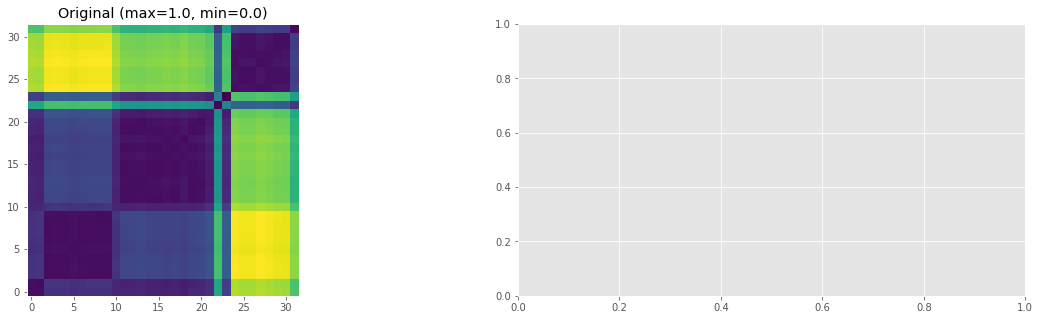

In [35]:
fig, axes = plt.subplots(1,2, figsize=(20,5))

original = X_treino_imagem[0,:,:,0]

axes[0].imshow(original, origin="lower");
axes[0].set_title("Original (max={:.1f}, min={:.1f})".format(np.max(original), np.min(original)));
axes[0].grid(False)

processada = X_treino_imagem_norm[0,:,:,0]
axes[1].imshow(processada, origin="lower");
axes[1].set_title("Processada (max={:.1f}, min={:.1f})".format(np.max(processada), np.min(processada)));
axes[1].grid(False)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20,5))

axes[0].plot(np.arange(len(X_treino[0])), X_treino[0]);
axes[0].set_title("Original (max={:.1f}, min={:.1f})".format(np.max(X_treino[0]), np.min(X_treino[0])))

serie_convertida = normalizar_dados([X_treino[0]])[0]
axes[1].plot(np.arange(len(serie_convertida)), serie_convertida);
axes[1].set_title("Convertida (max={:.1f}, min={:.1f})".format(np.max(serie_convertida), np.min(serie_convertida)))


## Metodologia Final/TCE (Transfer Learning, Class Weight e Early Stopping)

In [21]:
metricas = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]
early_stopping_auc = tf.keras.callbacks.EarlyStopping(
    min_delta=1e-5,
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True
)

### Split Treino/Teste

In [22]:
resultados = {
    "aparelho": [],
    "teste": [],
    "f1": [],
    "suporte_relativo": [],
    "auc":[],
    "carga_desconsiderada_total_positivo": [],
    "carga_desconsiderada_porc_positivo": [],
    "carga_desconsiderada_total_negativo": [],    
    "carga_desconsiderada_porc_negativo": [],
    "carga_desconsiderada_total_geral": [],
    "carga_desconsiderada_porc_geral": [],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = parametros_rp_aparelho[rotulo_aparelho]

    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    print("   - Detalhes da amostragem (lotes):")
    print("   ---")
    for item in Counter(y).items():
        print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()
    
    # Checando series estaveis
    estavel = []
    for i, x in enumerate(X):
        if len(np.unique(x)) == 1:
            estavel.append(i)
    print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
    print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
    print()
    
    print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
    print()
    
    # Convertendo series para imagem
    print("   - Preparando dados para modelagem (treino/teste)...")
    print("   ---")
    # Fazendo split dos dados (treino/teste)
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, 
        test_size=FRACAO_TESTE,
        stratify=y,
        random_state=SEED
    )
    print()

    print("      - Distribuições dos lotes:")
    print("        -> Treino:", Counter(y_treino))
    print("        -> Teste :", Counter(y_teste))

    X_treino_imagem, _ = preparar_amostras(
        X_treino, y_treino, 
        params_rp=CONFIG_RP_APARELHO,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    X_teste_imagem, _ = preparar_amostras(
        X_teste, y_teste, 
        params_rp=CONFIG_RP_APARELHO,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    
    # Normalizar dados p/ modelo
    X_treino_imagem = normalizar_dados(X_treino_imagem)
    X_teste_imagem = normalizar_dados(X_teste_imagem)
    
    print()
    
    ########################### METODOLOGIA FINAL ###########################
    # Selecionar informacoes sobre aparelhos em outras residencias
    dados_pretreino = {}
    for r in [1,2,4,5,6]:
        for e in redd.buildings[r].elec.meters:
            if e.label().lower().replace(" ","_") == CARGA:
                dados_pretreino[r] = e.instance() if not hasattr(e,'meters') else e.instance()[0]
    modelo_pretreino = convnet_metodologia(
        metrics=metricas,
        optimizer=tf.keras.optimizers.Adam(1e-3), 
        #bias_output=bias_inicial_output
    )    
    # Realizando pre-treinamento
    print(f"   - Realizando pré-treinamento do modelo ({dados_pretreino})...")
    for res, inst in dados_pretreino.items():
        try:
            X_pretreino, y_pretreino = carregar_dados_aparelho(
                janelas=Janelas(
                    base=redd,
                    id_residencia=res,
                    inicio_intervalo=PARAMETROS_DATASET["inicio_intervalo"],
                    fim_intervalo=PARAMETROS_DATASET["fim_intervalo"],
                    debug=False
                ),
                instancia=inst, 
                aparelho=CARGA, 
                taxa=TAXA,
                tamanho_janela=TAMANHO_JANELA,
            )
            X_pretreino, y_pretreino = preparar_amostras(
                X_pretreino, y_pretreino, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False 
            ) 

            # Normalizar dados p/ modelo
            X_pretreino = normalizar_dados(X_pretreino)

            # calculando punicao para classes (desbalanceamento)
            neg, pos = np.bincount(y_pretreino)
            total = neg + pos
            p0 = (1 / neg)*(total)/2.0 
            p1 = (1 / pos)*(total)/2.0
            pesos_classes_tl = {
                0: p0 if not np.isinf(p0) else 1e-3, 
                1: p1 if not np.isinf(p1) else 1e-3
            }

            # Treinando
            historico = modelo_pretreino.fit(
                X_pretreino, y_pretreino,
                validation_data=(X_pretreino, y_pretreino),
                epochs=EPOCAS,
                batch_size=int(len(y_pretreino)/3),#TAMANHO_LOTE_AUMENTADO,
                class_weight=pesos_classes_tl,
                callbacks=[early_stopping_auc],
                #verbose=VERBOSIDADE
                verbose=0
            )
        #     # Treinando (BASELINE)
        #     modelo_pretreino = treinamento_estrategico(
        #         modelo=modelo_pretreino, 
        #         X=X_pretreino, y=y_pretreino, 
        #         #validacao=(X_teste_imagem, y_teste), 
        #         epocas=10, 
        #         majoritaria=0, minoritaria=1, 
        #         peso_classe={0:1, 1:1}, 
        #         debug=False
        #     )
        #     print()

            # Avaliando
            y_hat = modelo_pretreino.predict(X_pretreino).round().astype(np.int16)

            print(classification_report(y_pretreino, y_hat))
            print()
            print(confusion_matrix(y_pretreino, y_hat))
            print()

            tf.keras.backend.clear_session()

            # Incrementando resultados
            score = f1_score(y_pretreino, y_hat, average="macro")
            auc_score = roc_auc_score(y_pretreino, y_hat) if np.unique(y_pretreino).shape[0]>1 else 1
            print("      -> Resultados residencia #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                res,
                score*100,
                auc_score,
            ))
            print()
        except Exception as e:
            print(f"      -> Resultados residencia #{res}: Não foi possível "+\
                  "pré-treinar o modelo com os dados desta residência.")
            print(f"         # MOTIVO: {str(e)}")
            print()
        
        
    # calculando punicao para classes (desbalanceamento)
    neg, pos = np.bincount(y_treino)
    total = neg + pos
    p0 = (1 / neg)*(total)/2.0 
    p1 = (1 / pos)*(total)/2.0
    pesos_classes = {
        0: p0 if not np.isinf(p0) else 1e-3, 
        1: p1 if not np.isinf(p1) else 1e-3
    }
    print("   - Punição de classes:", pesos_classes)
    print()

    print("   - Avaliando modelo, aguarde...")
    print("   ---")
    y_true, y_pred = [], []
    scores = []
    aucs = []
    suportes_relativos = []

    # Avaliando N vezes o conjunto treino/teste (consitencia)
    N = 10
    for i in tqdm_notebook(range(N)):
        
        # Instanciando modelo pre-treinado
        modelo = modelo_pretreino
        modelo.set_weights(modelo_pretreino.get_weights())
        
        # Treinando
        historico = modelo.fit(
            X_treino_imagem, y_treino,
            validation_data=(X_teste_imagem, y_teste),
            epochs=EPOCAS,
            batch_size=int(len(y_treino)/4),#TAMANHO_LOTE**2, # TODO: Validar heuristica do tamanho do lote
            class_weight=pesos_classes,
            callbacks=[early_stopping_auc],
            #verbose=VERBOSIDADE
            verbose=0
        )
#         # Treinando (BASELINE)
#         historico = modelo.fit(
#             X_treino_imagem, y_treino,
#             validation_data=(X_teste_imagem, y_teste),
#             epochs=EPOCAS,
#             batch_size=TAMANHO_LOTE,
#             #verbose=VERBOSIDADE
#             verbose=0
#         )

        
        y_teste_, y_pred_, score, auc_score, suporte_relativo, idx_descartados = \
            classificacao_threshold(
                modelo, X_teste_imagem, y_teste, 
                threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                grafico=False
            )
        

        tf.keras.backend.clear_session()

        # Incrementando resultados
        print("      -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
            i+1, 
            score*100,
            auc_score,
        ))
        scores.append(score)
        aucs.append(auc_score)
        suportes_relativos.append(suporte_relativo)
        y_true.extend(y_teste_)
        y_pred.extend(y_pred_)
        
        
        # Guardando resultados do modelo
        resultados["aparelho"].append(rotulo_aparelho)
        resultados["teste"].append(i+1)
        resultados["f1"].append(score)
        resultados["auc"].append(auc_score)
        resultados["suporte_relativo"].append(suporte_relativo)
        
        # TODO: calcular em função das amostras descartadas
        cdp = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "positivo"
        )
        resultados["carga_desconsiderada_total_positivo"].append(np.sum(cdp))
        resultados["carga_desconsiderada_porc_positivo"].append(
            np.sum(cdp)/np.sum(X_teste[y_teste==1])
        )
        
        cdn = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "negativo"
        )
        resultados["carga_desconsiderada_total_negativo"].append(np.sum(cdn))
        resultados["carga_desconsiderada_porc_negativo"].append(
            np.sum(cdn)/np.sum(X_teste[y_teste==0])
        )
            
        cdg = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "todos"
        )
        resultados["carga_desconsiderada_total_geral"].append(np.sum(cdg))
        resultados["carga_desconsiderada_porc_geral"].append(
            np.sum(cdg)/np.sum(X_teste)
        )

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()
    print("      -> Suportes Relativo:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(suportes_relativos) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(suportes_relativos)) )
    print("         . Mínimo        : {:.3f}".format(np.min(suportes_relativos)) )
    print("         . Máximo        : {:.3f}".format(np.max(suportes_relativos)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()

* Aparelho FRIDGE - 7:

   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 45, 0: 8})
        -> Teste : Counter({1: 15, 0: 3})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:44:56.533010 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:44:56.574005 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 07:45:02.488004 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:02.531009 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:45:05.356007 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:05.420005 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.3125, 1: 0.5888888888888889}

   - Avaliando modelo, aguarde...
   ---


W0729 07:45:06.492008 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:06.540005 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 45.45% / AUC = 0.500


W0729 07:45:07.429012 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:07.481007 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 45.45% / AUC = 0.500


W0729 07:45:08.304007 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:08.346007 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 45.45% / AUC = 0.500


W0729 07:45:09.160007 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:09.202045 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0729 07:45:10.040045 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:10.083008 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0729 07:45:10.928006 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:10.974007 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0729 07:45:11.792006 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:11.833007 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0729 07:45:12.661005 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:12.707009 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0729 07:45:13.522006 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:13.561010 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0729 07:45:14.437005 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:14.490011 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 83.64%
         . Desvio padrão : 25.00%
         . Mínimo        : 45.45%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.850
         . Desvio padrão : 0.229
         . Mínimo        : 0.500
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        30
           1       0.94      1.00      0.97       150

    accuracy                           0.95       180
   macro avg       0.97      0.85      0.90       180
weighted avg       0.95      0.95      0.95       180

      -> Matrix de confusao:

[[ 21   9]
 [  0 150]]

------



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:45:22.875009 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:22.918005 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.45      0.62       227
           1       0.08      1.00      0.15        11

    accuracy                           0.48       238
   macro avg       0.54      0.73      0.39       238
weighted avg       0.96      0.48      0.60       238


[[103 124]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 38.75% / AUC = 0.727




W0729 07:45:30.852047 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:30.897005 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       248
           1       0.12      1.00      0.22         6

    accuracy                           0.83       254
   macro avg       0.56      0.91      0.56       254
weighted avg       0.98      0.83      0.89       254


[[205  43]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 56.16% / AUC = 0.913

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:45:36.210746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:36.264705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.77      0.87       303
           1       0.09      1.00      0.17         7

    accuracy                           0.77       310
   macro avg       0.55      0.88      0.52       310
weighted avg       0.98      0.77      0.85       310


[[233  70]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 51.80% / AUC = 0.884

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:45:42.279707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:42.326704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       153
           1       0.33      1.00      0.50         3

    accuracy                           0.96       156
   macro avg       0.67      0.98      0.74       156
weighted avg       0.99      0.96      0.97       156


[[147   6]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 74.00% / AUC = 0.980

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099206349206349, 1: 25.700000000000003}

   - Avaliando modelo, aguarde...
   ---


W0729 07:45:48.736742 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:48.778745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 55.21% / AUC = 0.696


W0729 07:45:49.781706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:49.822743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 41.35% / AUC = 0.565


W0729 07:45:50.774705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:50.817706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 53.35% / AUC = 0.685


W0729 07:45:53.478702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:53.519707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 53.35% / AUC = 0.685


W0729 07:45:54.404707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:54.455706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 56.30% / AUC = 0.702


W0729 07:45:55.333704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:55.381743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 57.53% / AUC = 0.708


W0729 07:45:56.298709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:56.347708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 56.30% / AUC = 0.702


W0729 07:45:57.412709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:57.457708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 54.23% / AUC = 0.690


W0729 07:45:58.539707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:58.583748 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 60.67% / AUC = 0.720


W0729 07:45:59.467704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:45:59.513705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 62.77% / AUC = 0.726


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 55.10%
         . Desvio padrão : 5.43%
         . Mínimo        : 41.35%
         . Máximo        : 62.77%

      -> AUC:

         . Média geral   : 0.688
         . Desvio padrão : 0.043
         . Mínimo        : 0.565
         . Máximo        : 0.726

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       840
           1       0.09      0.50      0.15        20

    accuracy                           0.87       860
   macro avg       0.54      0.69      0.54       860
weighted avg       0.97      0.87      0.91       860

      -> Matrix de confusao:

[[736 104]
 [ 10  10]]

---------



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:46:10.061709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:10.109706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.77      0.87       158
           1       0.03      1.00      0.05         1

    accuracy                           0.77       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.77      0.87       159


[[122  36]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.20% / AUC = 0.886




W0729 07:46:16.329708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:16.381705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.91       168
           1       0.04      1.00      0.07         1

    accuracy                           0.84       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.84      0.91       169


[[141  27]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 49.08% / AUC = 0.920

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:46:23.584707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:23.623703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       195
           1       0.67      1.00      0.80        12

    accuracy                           0.97       207
   macro avg       0.83      0.98      0.89       207
weighted avg       0.98      0.97      0.97       207


[[189   6]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 89.22% / AUC = 0.985

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:46:33.031706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:33.076742 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       103
           1       0.08      1.00      0.14         1

    accuracy                           0.88       104
   macro avg       0.54      0.94      0.54       104
weighted avg       0.99      0.88      0.93       104


[[91 12]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 54.05% / AUC = 0.942

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5181818181818182, 1: 14.25}

   - Avaliando modelo, aguarde...
   ---


W0729 07:46:34.431709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:34.488706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0729 07:46:36.717705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:36.758742 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0729 07:46:37.638705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:37.682708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 89.54% / AUC = 0.991


W0729 07:46:38.648708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:38.688709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 82.88% / AUC = 0.750


W0729 07:46:39.567705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:39.610702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 89.54% / AUC = 0.991


W0729 07:46:40.446705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:40.495703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0729 07:46:41.352704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:41.396707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 82.88% / AUC = 0.750


W0729 07:46:42.223746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:42.270741 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0729 07:46:43.088704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:43.133705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 89.54% / AUC = 0.991


W0729 07:46:43.957709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:44.001710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 93.44%
         . Desvio padrão : 6.95%
         . Mínimo        : 82.88%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.947
         . Desvio padrão : 0.099
         . Mínimo        : 0.750
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       550
           1       0.86      0.90      0.88        20

    accuracy                           0.99       570
   macro avg       0.93      0.95      0.94       570
weighted avg       0.99      0.99      0.99       570

      -> Matrix de confusao:

[[547   3]
 [  2  18]]

-------



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:46:54.455706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:46:54.499744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.72      0.83       158
           1       0.02      1.00      0.04         1

    accuracy                           0.72       159
   macro avg       0.51      0.86      0.44       159
weighted avg       0.99      0.72      0.83       159


[[113  45]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 43.83% / AUC = 0.858




W0729 07:47:00.652708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:00.714706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       168
           1       0.03      1.00      0.06         1

    accuracy                           0.82       169
   macro avg       0.52      0.91      0.48       169
weighted avg       0.99      0.82      0.89       169


[[137  31]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 47.95% / AUC = 0.908

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:47:07.710702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:07.749707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       195
           1       0.63      1.00      0.77        12

    accuracy                           0.97       207
   macro avg       0.82      0.98      0.88       207
weighted avg       0.98      0.97      0.97       207


[[188   7]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 87.80% / AUC = 0.982

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:47:18.530704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:18.572703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       103
           1       0.06      1.00      0.12         1

    accuracy                           0.86       104
   macro avg       0.53      0.93      0.52       104
weighted avg       0.99      0.86      0.91       104


[[88 15]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 51.96% / AUC = 0.927

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5245398773006135, 1: 10.6875}

   - Avaliando modelo, aguarde...
   ---


W0729 07:47:19.869746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:19.914707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 46.20% / AUC = 0.809


W0729 07:47:22.442708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:22.494708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 52.25% / AUC = 0.659


W0729 07:47:23.331743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:23.378705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 64.81% / AUC = 0.723


W0729 07:47:24.743749 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:24.783743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 64.81% / AUC = 0.723


W0729 07:47:25.637705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:25.679704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 64.81% / AUC = 0.723


W0729 07:47:26.536705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:26.578705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 64.81% / AUC = 0.723


W0729 07:47:28.346748 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:28.387704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 61.95% / AUC = 0.714


W0729 07:47:29.241704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:29.288743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 64.81% / AUC = 0.723


W0729 07:47:30.473706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:30.515704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 64.81% / AUC = 0.723


W0729 07:47:31.348702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:31.391702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 61.95% / AUC = 0.714


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 61.12%
         . Desvio padrão : 6.20%
         . Mínimo        : 46.20%
         . Máximo        : 64.81%

      -> AUC:

         . Média geral   : 0.723
         . Desvio padrão : 0.034
         . Mínimo        : 0.659
         . Máximo        : 0.809

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       550
           1       0.16      0.55      0.25        20

    accuracy                           0.88       570
   macro avg       0.57      0.72      0.59       570
weighted avg       0.95      0.88      0.91       570

      -> Matrix de confusao:

[[493  57]
 [  9  11]]

---------



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:47:39.445706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:39.501706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.84      0.91       260
           1       0.45      0.89      0.60        38

    accuracy                           0.85       298
   macro avg       0.72      0.87      0.75       298
weighted avg       0.91      0.85      0.87       298


[[219  41]
 [  4  34]]

      -> Resultados residencia #1: F1-score = 75.43% / AUC = 0.869




W0729 07:47:47.904708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:47.951706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.95      0.70      0.81       271
           1       0.31      0.78      0.44        46

    accuracy                           0.72       317
   macro avg       0.63      0.74      0.63       317
weighted avg       0.86      0.72      0.76       317


[[191  80]
 [ 10  36]]

      -> Resultados residencia #2: F1-score = 62.69% / AUC = 0.744

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:47:57.294707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:47:57.334708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.80      0.87       108
           1       0.79      0.95      0.86        87

    accuracy                           0.87       195
   macro avg       0.87      0.88      0.87       195
weighted avg       0.88      0.87      0.87       195


[[86 22]
 [ 4 83]]

      -> Resultados residencia #5: F1-score = 86.66% / AUC = 0.875

   - Punição de classes: {0: 0.5262295081967213, 1: 10.03125}

   - Avaliando modelo, aguarde...
   ---


W0729 07:48:07.859745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:07.902705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 41.95% / AUC = 0.670


W0729 07:48:09.828707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:09.870744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 82.34% / AUC = 0.885


W0729 07:48:11.460708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:11.503708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 74.91% / AUC = 0.871


W0729 07:48:12.938743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:12.985749 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 77.07% / AUC = 0.875


W0729 07:48:14.487746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:14.529704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 77.07% / AUC = 0.875


W0729 07:48:15.774704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:15.823704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 77.07% / AUC = 0.875


W0729 07:48:16.856703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:16.897746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 72.98% / AUC = 0.866


W0729 07:48:17.895707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:17.940704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 74.91% / AUC = 0.871


W0729 07:48:20.137704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:20.179702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 74.91% / AUC = 0.871


W0729 07:48:21.295704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:21.338704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 74.91% / AUC = 0.871


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 72.81%
         . Desvio padrão : 10.56%
         . Mínimo        : 41.95%
         . Máximo        : 82.34%

      -> AUC:

         . Média geral   : 0.853
         . Desvio padrão : 0.061
         . Mínimo        : 0.670
         . Máximo        : 0.885

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1020
           1       0.29      0.80      0.43        50

    accuracy                           0.90      1070
   macro avg       0.64      0.85      0.69      1070
weighted avg       0.96      0.90      0.92      1070

      -> Matrix de confusao:

[[924  96]
 [ 10  40]]

--------

In [23]:
# Exportando resultados
df_tce = pd.DataFrame(resultados)
df_tce["metodologia"] = "Fnal/TCE"
df_tce.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_tce.xlsx"),
    index=False
)

### Validação Cruzada

In [24]:
resultados = {
    "aparelho": [],
    "iteracao": [],
    "teste": [],
    "f1": [],
    "suporte_relativo": [],
    "auc":[],
    "carga_desconsiderada_total_positivo": [],
    "carga_desconsiderada_porc_positivo": [],
    "carga_desconsiderada_total_negativo": [],    
    "carga_desconsiderada_porc_negativo": [],
    "carga_desconsiderada_total_geral": [],
    "carga_desconsiderada_porc_geral": [],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = parametros_rp_aparelho[rotulo_aparelho]

    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    print("   - Detalhes da amostragem (lotes):")
    print("   ---")
    for item in Counter(y).items():
        print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()
    
    # Checando series estaveis
    estavel = []
    for i, x in enumerate(X):
        if len(np.unique(x)) == 1:
            estavel.append(i)
    print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
    print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
    print()
    
    print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
    print()
    
    # Convertendo series para imagem (CV)
    for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

        iteracao = it + 1    
        print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
        print("   ---")
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]
        print()

        print("      - Distribuições dos lotes:")
        print("        -> Treino:", Counter(y_treino))
        print("        -> Teste :", Counter(y_teste))

        X_treino_imagem, _ = preparar_amostras(
            X_treino, y_treino, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )
        X_teste_imagem, _ = preparar_amostras(
            X_teste, y_teste, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )

        # Normalizar dados p/ modelo
        X_treino_imagem = normalizar_dados(X_treino_imagem)
        X_teste_imagem = normalizar_dados(X_teste_imagem)

        print()

        ########################### METODOLOGIA FINAL ###########################
        # Selecionar informacoes sobre aparelhos em outras residencias
        dados_pretreino = {}
        for r in [1,2,4,5,6]:
            for e in redd.buildings[r].elec.meters:
                if e.label().lower().replace(" ","_") == CARGA:
                    dados_pretreino[r] = e.instance() if not hasattr(e,'meters') else e.instance()[0]
        modelo_pretreino = convnet_metodologia(
            metrics=metricas,
            optimizer=tf.keras.optimizers.Adam(1e-3), 
            #bias_output=bias_inicial_output
        )    
        # Realizando pre-treinamento
        print(f"   - Realizando pré-treinamento do modelo ({dados_pretreino})...")
        for res, inst in dados_pretreino.items():
            try:
                X_pretreino, y_pretreino = carregar_dados_aparelho(
                    janelas=Janelas(
                        base=redd,
                        id_residencia=res,
                        inicio_intervalo=PARAMETROS_DATASET["inicio_intervalo"],
                        fim_intervalo=PARAMETROS_DATASET["fim_intervalo"],
                        debug=False
                    ),
                    instancia=inst, 
                    aparelho=CARGA, 
                    taxa=TAXA,
                    tamanho_janela=TAMANHO_JANELA,
                )
                X_pretreino, y_pretreino = preparar_amostras(
                    X_pretreino, y_pretreino, 
                    params_rp=CONFIG_RP_APARELHO,
                    tam_imagem=TAMANHO_IMAGEM,
                    normalizar=False 
                ) 

                # Normalizar dados p/ modelo
                X_pretreino = normalizar_dados(X_pretreino)

                # calculando punicao para classes (desbalanceamento)
                neg, pos = np.bincount(y_pretreino)
                total = neg + pos
                p0 = (1 / neg)*(total)/2.0 
                p1 = (1 / pos)*(total)/2.0
                pesos_classes_tl = {
                    0: p0 if not np.isinf(p0) else 1e-3, 
                    1: p1 if not np.isinf(p1) else 1e-3
                }

                # Treinando
                historico = modelo_pretreino.fit(
                    X_pretreino, y_pretreino,
                    validation_data=(X_pretreino, y_pretreino),
                    epochs=EPOCAS,
                    batch_size=int(len(y_pretreino)/3),#TAMANHO_LOTE_AUMENTADO,
                    class_weight=pesos_classes_tl,
                    callbacks=[early_stopping_auc],
                    #verbose=VERBOSIDADE
                    verbose=0
                )
            #     # Treinando (BASELINE)
            #     modelo_pretreino = treinamento_estrategico(
            #         modelo=modelo_pretreino, 
            #         X=X_pretreino, y=y_pretreino, 
            #         #validacao=(X_teste_imagem, y_teste), 
            #         epocas=10, 
            #         majoritaria=0, minoritaria=1, 
            #         peso_classe={0:1, 1:1}, 
            #         debug=False
            #     )
            #     print()

                # Avaliando
                y_hat = modelo_pretreino.predict(X_pretreino).round().astype(np.int16)

                print(classification_report(y_pretreino, y_hat))
                print()
                print(confusion_matrix(y_pretreino, y_hat))
                print()

                tf.keras.backend.clear_session()

                # Incrementando resultados
                score = f1_score(y_pretreino, y_hat, average="macro")
                auc_score = roc_auc_score(y_pretreino, y_hat) if np.unique(y_pretreino).shape[0]>1 else 1
                print("      -> Resultados residencia #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                    res,
                    score*100,
                    auc_score,
                ))
                print()
            except Exception as e:
                print(f"      -> Resultados residencia #{res}: Não foi possível "+\
                      "pré-treinar o modelo com os dados desta residência.")
                print(f"         # MOTIVO: {str(e)}")
                print()


        # calculando punicao para classes (desbalanceamento)
        neg, pos = np.bincount(y_treino)
        total = neg + pos
        p0 = (1 / neg)*(total)/2.0 
        p1 = (1 / pos)*(total)/2.0
        pesos_classes = {
            0: p0 if not np.isinf(p0) else 1e-3, 
            1: p1 if not np.isinf(p1) else 1e-3
        }
        print("   - Punição de classes:", pesos_classes)
        print()

        print("   - Avaliando modelo, aguarde...")
        print("   ---")
        y_true, y_pred = [], []
        scores = []
        aucs = []
        suportes_relativos = []

        # Avaliando N vezes o conjunto treino/teste (consitencia)
        N = 10
        for i in tqdm_notebook(range(N)):

            # Instanciando modelo pre-treinado
            modelo = modelo_pretreino
            modelo.set_weights(modelo_pretreino.get_weights())

            # Treinando
            historico = modelo.fit(
                X_treino_imagem, y_treino,
                validation_data=(X_teste_imagem, y_teste),
                epochs=EPOCAS,
                batch_size=int(len(y_treino)/4),#TAMANHO_LOTE**2, # TODO: Validar heuristica do tamanho do lote
                class_weight=pesos_classes,
                callbacks=[early_stopping_auc],
                #verbose=VERBOSIDADE
                verbose=0
            )
    #         # Treinando (BASELINE)
    #         historico = modelo.fit(
    #             X_treino_imagem, y_treino,
    #             validation_data=(X_teste_imagem, y_teste),
    #             epochs=EPOCAS,
    #             batch_size=TAMANHO_LOTE,
    #             #verbose=VERBOSIDADE
    #             verbose=0
    #         )


            y_teste_, y_pred_, score, auc_score, suporte_relativo, idx_descartados = \
                classificacao_threshold(
                    modelo, X_teste_imagem, y_teste, 
                    threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                    grafico=False
                )


            tf.keras.backend.clear_session()

            # Incrementando resultados
            print("      -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                i+1, 
                score*100,
                auc_score,
            ))
            scores.append(score)
            aucs.append(auc_score)
            suportes_relativos.append(suporte_relativo)
            y_true.extend(y_teste_)
            y_pred.extend(y_pred_)


            # Guardando resultados do modelo
            resultados["aparelho"].append(rotulo_aparelho)
            resultados["iteracao"].append(iteracao)
            resultados["teste"].append(i+1)
            resultados["f1"].append(score)
            resultados["auc"].append(auc_score)
            resultados["suporte_relativo"].append(suporte_relativo)

            # TODO: calcular em função das amostras descartadas
            cdp = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "positivo"
            )
            resultados["carga_desconsiderada_total_positivo"].append(np.sum(cdp))
            resultados["carga_desconsiderada_porc_positivo"].append(
                np.sum(cdp)/np.sum(X_teste[y_teste==1])
            )

            cdn = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "negativo"
            )
            resultados["carga_desconsiderada_total_negativo"].append(np.sum(cdn))
            resultados["carga_desconsiderada_porc_negativo"].append(
                np.sum(cdn)/np.sum(X_teste[y_teste==0])
            )

            cdg = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "todos"
            )
            resultados["carga_desconsiderada_total_geral"].append(np.sum(cdg))
            resultados["carga_desconsiderada_porc_geral"].append(
                np.sum(cdg)/np.sum(X_teste)
            )

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()
    print("      -> Suportes Relativo:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(suportes_relativos) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(suportes_relativos)) )
    print("         . Mínimo        : {:.3f}".format(np.min(suportes_relativos)) )
    print("         . Máximo        : {:.3f}".format(np.max(suportes_relativos)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
# Exportando resultados
df_tce_cv = pd.DataFrame(resultados)
df_tce_cv["metodologia"] = "Fnal/TCE"
df_tce_cv.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_tce_cv.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 9})
        -> Teste : Counter({1: 6, 0: 2})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:48:32.436704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:32.482707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 07:48:38.000710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:38.042705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:48:40.759706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:40.802704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.5, 1: 0.5833333333333333}

   - Avaliando modelo, aguarde...
   ---


W0729 07:48:41.809705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:41.857709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 42.86% / AUC = 0.500


W0729 07:48:42.677706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:42.718709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 42.86% / AUC = 0.500


W0729 07:48:43.477705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:43.521710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 42.86% / AUC = 0.500


W0729 07:48:44.299706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:44.341704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0729 07:48:45.088705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:45.131745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0729 07:48:45.899704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:45.943745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0729 07:48:46.745707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:46.783703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0729 07:48:47.546706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:47.597704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0729 07:48:48.369744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:48.429706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0729 07:48:49.197744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:49.246706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:48:54.590743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:48:54.636702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 07:49:00.391706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:00.448704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:49:03.156708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:03.197710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0729 07:49:04.165702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:04.207706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 46.15% / AUC = 0.500


W0729 07:49:05.647707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:05.684707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 46.15% / AUC = 0.500


W0729 07:49:06.335705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:06.378706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 46.15% / AUC = 0.500


W0729 07:49:06.991749 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:07.028706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 46.15% / AUC = 0.500


W0729 07:49:07.642707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:07.677705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 46.15% / AUC = 0.500


W0729 07:49:08.320706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:08.355710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 46.15% / AUC = 0.500


W0729 07:49:08.994706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:09.036746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 46.15% / AUC = 0.500


W0729 07:49:09.689710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:09.725710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 46.15% / AUC = 0.500


W0729 07:49:10.377743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:10.422707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 46.15% / AUC = 0.500


W0729 07:49:11.065708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:11.105745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 46.15% / AUC = 0.500

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:49:15.989737 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:16.026704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 07:49:21.433732 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:21.480705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:49:23.930705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:23.972704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0729 07:49:24.918746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:24.953704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 46.15% / AUC = 0.500


W0729 07:49:26.403711 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:26.451706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 46.15% / AUC = 0.500


W0729 07:49:27.091706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:27.129707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 46.15% / AUC = 0.500


W0729 07:49:27.778707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:27.816703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 46.15% / AUC = 0.500


W0729 07:49:28.464704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:28.506703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 46.15% / AUC = 0.500


W0729 07:49:29.163710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:29.199748 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0729 07:49:29.846704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:29.888706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0729 07:49:30.528705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:30.562706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0729 07:49:31.179746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:31.214707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0729 07:49:31.849702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:31.884703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:49:36.844707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:36.886703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95        49

    accuracy                           0.90        49
   macro avg       0.50      0.45      0.47        49
weighted avg       1.00      0.90      0.95        49


[[ 0  0]
 [ 5 44]]

      -> Resultados residencia #1: F1-score = 47.31% / AUC = 1.000




W0729 07:49:42.634705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:42.680706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:49:45.328706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:45.374704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0729 07:49:46.309741 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:46.346704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 78.79% / AUC = 0.917


W0729 07:49:47.806743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:47.843706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 78.79% / AUC = 0.917


W0729 07:49:48.510707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:48.549705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 78.79% / AUC = 0.917


W0729 07:49:49.212705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:49.257745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 78.79% / AUC = 0.917


W0729 07:49:49.919743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:49.955708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0729 07:49:50.617711 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:50.655707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0729 07:49:51.323708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:51.358703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0729 07:49:52.012709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:52.051742 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0729 07:49:52.701709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:52.735743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0729 07:49:53.385705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:53.434745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:49:58.476705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:49:58.523707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 07:50:04.335707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:04.371706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:50:06.707705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:06.742703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0729 07:50:07.539704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:07.575706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0729 07:50:08.876705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:08.912704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0729 07:50:09.563710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:09.596707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0729 07:50:10.248744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:10.284709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0729 07:50:10.918709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:10.959743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0729 07:50:11.617705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:11.653706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0729 07:50:12.313704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:12.356750 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0729 07:50:12.978749 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:13.013707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0729 07:50:13.680706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:13.716703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0729 07:50:14.353712 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:14.388702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:50:19.717706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:19.758703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 07:50:25.451704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:25.502703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:50:28.100711 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:28.141704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0729 07:50:29.079706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:29.119703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 46.15% / AUC = 0.500


W0729 07:50:30.560711 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:30.597707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 46.15% / AUC = 0.500


W0729 07:50:31.237705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:31.282707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 46.15% / AUC = 0.500


W0729 07:50:31.939745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:31.980705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 46.15% / AUC = 0.500


W0729 07:50:32.638712 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:32.675706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 46.15% / AUC = 0.500


W0729 07:50:33.321704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:33.356709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 46.15% / AUC = 0.500


W0729 07:50:33.990745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:34.035704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 46.15% / AUC = 0.500


W0729 07:50:34.672711 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:34.708706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 46.15% / AUC = 0.500


W0729 07:50:35.349705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:35.387709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 46.15% / AUC = 0.500


W0729 07:50:36.028746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:36.062704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 46.15% / AUC = 0.500

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:50:40.901744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:40.943707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 07:50:46.791708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:46.836743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:50:49.506707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:49.559707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0729 07:50:50.529703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:50.564703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 46.15% / AUC = 0.500


W0729 07:50:52.037734 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:52.077707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 46.15% / AUC = 0.500


W0729 07:50:52.720702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:52.758707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 46.15% / AUC = 0.500


W0729 07:50:53.412705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:53.464858 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0729 07:50:54.113744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:54.153743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0729 07:50:54.785705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:54.821703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0729 07:50:55.463704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:55.503704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0729 07:50:56.146706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:56.184703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0729 07:50:56.822709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:56.865711 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0729 07:50:57.514706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:50:57.553744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:51:02.655744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:02.697707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 07:51:07.977707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:08.021703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:51:10.593702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:10.627705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0729 07:51:11.437705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:11.473706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 46.15% / AUC = 0.500


W0729 07:51:12.695705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:12.731742 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 46.15% / AUC = 0.500


W0729 07:51:13.392704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:13.437707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 46.15% / AUC = 0.500


W0729 07:51:14.084706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:14.130707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 46.15% / AUC = 0.500


W0729 07:51:14.776705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:14.815706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 46.15% / AUC = 0.500


W0729 07:51:15.446704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:15.489703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 46.15% / AUC = 0.500


W0729 07:51:16.131705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:16.166705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 46.15% / AUC = 0.500


W0729 07:51:16.828710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:16.873708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 46.15% / AUC = 0.500


W0729 07:51:17.513705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:17.546705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 46.15% / AUC = 0.500


W0729 07:51:18.190704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:18.225742 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 46.15% / AUC = 0.500

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:51:23.256706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:23.307712 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 07:51:29.008708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:29.049709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:51:31.764708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:31.807706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0729 07:51:32.746746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:32.783748 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 46.15% / AUC = 0.500


W0729 07:51:34.239705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:34.275709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 46.15% / AUC = 0.500


W0729 07:51:34.918703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:34.952703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 46.15% / AUC = 0.500


W0729 07:51:35.599706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:35.644707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 46.15% / AUC = 0.500


W0729 07:51:36.298707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:36.335707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 46.15% / AUC = 0.500


W0729 07:51:36.973743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:37.007743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 46.15% / AUC = 0.500


W0729 07:51:37.661706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:37.700707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 46.15% / AUC = 0.500


W0729 07:51:38.343705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:38.390706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0729 07:51:39.014705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:39.047744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0729 07:51:39.690704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:39.724706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:51:44.821702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:44.864708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 07:51:50.516898 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:50.552703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:51:53.026746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:53.068744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0729 07:51:54.057704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:54.097707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 46.15% / AUC = 0.500


W0729 07:51:55.571707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:55.616708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 46.15% / AUC = 0.500


W0729 07:51:56.235716 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:56.271734 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0729 07:51:56.810706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:56.843705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0729 07:51:57.469748 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:57.503743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0729 07:51:58.168705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:58.208708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0729 07:51:58.859704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:58.895744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0729 07:51:59.517706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:51:59.552707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0729 07:52:00.211704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:00.258745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0729 07:52:00.929707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:00.965710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 89.23%
         . Desvio padrão : 21.54%
         . Mínimo        : 46.15%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.900
         . Desvio padrão : 0.200
         . Mínimo        : 0.500
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.97      1.00      0.98        60

    accuracy                           0.97        70
   macro avg       0.98      0.90      0.94        70
weighted avg       0.97      0.97      0.97        70

      -> Matrix de confusao:

[[ 8  2]
 [ 0 60]]

----------



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:52:08.808705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:08.857741 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       227
           1       0.25      1.00      0.40        11

    accuracy                           0.86       238
   macro avg       0.62      0.93      0.66       238
weighted avg       0.97      0.86      0.90       238


[[194  33]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 66.08% / AUC = 0.927




W0729 07:52:16.434706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:16.484707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       248
           1       0.16      1.00      0.27         6

    accuracy                           0.87       254
   macro avg       0.58      0.94      0.60       254
weighted avg       0.98      0.87      0.92       254


[[216  32]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 60.19% / AUC = 0.935

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:52:21.708706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:21.757745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.82      0.90       303
           1       0.08      0.71      0.15         7

    accuracy                           0.82       310
   macro avg       0.54      0.77      0.53       310
weighted avg       0.97      0.82      0.88       310


[[249  54]
 [  2   5]]

      -> Resultados residencia #4: F1-score = 52.52% / AUC = 0.768

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:52:26.317703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:26.357704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       153
           1       0.33      1.00      0.50         3

    accuracy                           0.96       156
   macro avg       0.67      0.98      0.74       156
weighted avg       0.99      0.96      0.97       156


[[147   6]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 74.00% / AUC = 0.980

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


W0729 07:52:32.810705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:32.846706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 49.71% / AUC = 0.853


W0729 07:52:35.009703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:35.045746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 49.71% / AUC = 0.853


W0729 07:52:35.754703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:35.795711 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 57.66% / AUC = 0.912


W0729 07:52:36.498711 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:36.533746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 60.32% / AUC = 0.926


W0729 07:52:37.222741 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:37.264710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 60.32% / AUC = 0.926


W0729 07:52:37.963745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:37.998705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 60.32% / AUC = 0.926


W0729 07:52:38.677747 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:38.712707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 60.32% / AUC = 0.926


W0729 07:52:39.415706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:39.454705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 60.32% / AUC = 0.926


W0729 07:52:40.154704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:40.200748 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 63.54% / AUC = 0.941


W0729 07:52:40.904702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:40.940705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 63.54% / AUC = 0.941

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:52:45.368732 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:45.426709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       227
           1       0.39      1.00      0.56        11

    accuracy                           0.93       238
   macro avg       0.70      0.96      0.76       238
weighted avg       0.97      0.93      0.94       238


[[210  17]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 76.26% / AUC = 0.963




W0729 07:52:57.175707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:52:57.222702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       248
           1       0.15      0.83      0.25         6

    accuracy                           0.88       254
   macro avg       0.57      0.86      0.59       254
weighted avg       0.98      0.88      0.92       254


[[219  29]
 [  1   5]]

      -> Resultados residencia #2: F1-score = 59.29% / AUC = 0.858

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:53:02.511707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:02.560703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.77      0.87       303
           1       0.09      1.00      0.17         7

    accuracy                           0.78       310
   macro avg       0.55      0.89      0.52       310
weighted avg       0.98      0.78      0.86       310


[[234  69]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 52.01% / AUC = 0.886

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:53:09.939745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:09.988708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       153
           1       0.18      1.00      0.30         3

    accuracy                           0.91       156
   macro avg       0.59      0.95      0.63       156
weighted avg       0.98      0.91      0.94       156


[[139  14]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 62.60% / AUC = 0.954

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


W0729 07:53:16.112702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:16.151707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 55.37% / AUC = 0.897


W0729 07:53:17.677706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:17.713704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 55.37% / AUC = 0.897


W0729 07:53:18.396703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:18.450710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 55.37% / AUC = 0.897


W0729 07:53:19.144706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:19.179704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 55.37% / AUC = 0.897


W0729 07:53:19.877706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:19.919704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 55.37% / AUC = 0.897


W0729 07:53:20.625704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:20.660706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 55.37% / AUC = 0.897


W0729 07:53:21.343702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:21.379706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 55.37% / AUC = 0.897


W0729 07:53:22.058708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:22.103706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 55.37% / AUC = 0.897


W0729 07:53:22.788743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:22.828707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 55.37% / AUC = 0.897


W0729 07:53:23.569707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:23.607705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 55.37% / AUC = 0.897

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:53:27.848731 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:27.898703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       227
           1       0.30      1.00      0.46        11

    accuracy                           0.89       238
   macro avg       0.65      0.94      0.70       238
weighted avg       0.97      0.89      0.92       238


[[201  26]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 69.88% / AUC = 0.943




W0729 07:53:38.234747 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:38.283702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.81      0.90       248
           1       0.12      1.00      0.21         6

    accuracy                           0.82       254
   macro avg       0.56      0.91      0.55       254
weighted avg       0.98      0.82      0.88       254


[[202  46]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 55.23% / AUC = 0.907

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:53:43.786703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:43.835703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.79      0.88       303
           1       0.07      0.71      0.13         7

    accuracy                           0.78       310
   macro avg       0.53      0.75      0.50       310
weighted avg       0.97      0.78      0.86       310


[[238  65]
 [  2   5]]

      -> Resultados residencia #4: F1-score = 50.32% / AUC = 0.750

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:53:48.568747 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:48.615705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       153
           1       0.25      1.00      0.40         3

    accuracy                           0.94       156
   macro avg       0.62      0.97      0.68       156
weighted avg       0.99      0.94      0.96       156


[[144   9]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 68.48% / AUC = 0.971

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


W0729 07:53:55.645707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:55.681749 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 49.28% / AUC = 0.500


W0729 07:53:57.173746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:57.210707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 48.53% / AUC = 0.485


W0729 07:53:57.902704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:57.948709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 47.76% / AUC = 0.471


W0729 07:53:58.641705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:58.683702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 47.76% / AUC = 0.471


W0729 07:53:59.378707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:53:59.419709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 47.76% / AUC = 0.471


W0729 07:54:00.151752 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:00.189706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 47.76% / AUC = 0.471


W0729 07:54:00.930704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:00.965743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 47.76% / AUC = 0.471


W0729 07:54:01.688704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:01.730706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 47.76% / AUC = 0.471


W0729 07:54:02.453707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:02.493705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 48.53% / AUC = 0.485


W0729 07:54:03.773707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:03.812703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 48.53% / AUC = 0.485

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:54:09.151704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:09.189702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       227
           1       0.35      1.00      0.52        11

    accuracy                           0.92       238
   macro avg       0.68      0.96      0.74       238
weighted avg       0.97      0.92      0.93       238


[[207  20]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 73.89% / AUC = 0.956




W0729 07:54:19.600703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:19.648745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       248
           1       0.17      1.00      0.29         6

    accuracy                           0.89       254
   macro avg       0.59      0.94      0.62       254
weighted avg       0.98      0.89      0.92       254


[[219  29]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 61.53% / AUC = 0.942

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:54:24.869740 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:24.921704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.75      0.85       303
           1       0.07      0.86      0.13         7

    accuracy                           0.75       310
   macro avg       0.53      0.80      0.49       310
weighted avg       0.97      0.75      0.84       310


[[226  77]
 [  1   6]]

      -> Resultados residencia #4: F1-score = 49.31% / AUC = 0.802

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:54:29.567741 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:29.609743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       153
           1       0.25      1.00      0.40         3

    accuracy                           0.94       156
   macro avg       0.62      0.97      0.68       156
weighted avg       0.99      0.94      0.96       156


[[144   9]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 68.48% / AUC = 0.971

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


W0729 07:54:35.652704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:35.694706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 39.29% / AUC = 1.000


W0729 07:54:36.525703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:36.570705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 39.29% / AUC = 1.000


W0729 07:54:37.394704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:37.446702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 39.29% / AUC = 1.000


W0729 07:54:38.270704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:38.312707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 39.29% / AUC = 1.000


W0729 07:54:39.128708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:39.177711 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 39.29% / AUC = 1.000


W0729 07:54:40.014704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:40.056708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 39.29% / AUC = 1.000


W0729 07:54:40.878704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:40.923709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 39.29% / AUC = 1.000


W0729 07:54:41.752710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:41.800705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 39.29% / AUC = 1.000


W0729 07:54:42.643707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:42.689746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 39.29% / AUC = 1.000


W0729 07:54:43.508702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:43.558745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 39.29% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:54:48.295702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:48.341743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       227
           1       0.33      1.00      0.50        11

    accuracy                           0.91       238
   macro avg       0.67      0.95      0.72       238
weighted avg       0.97      0.91      0.93       238


[[205  22]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 72.45% / AUC = 0.952




W0729 07:54:56.473704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:54:56.522702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.76      0.86       248
           1       0.09      1.00      0.17         6

    accuracy                           0.77       254
   macro avg       0.55      0.88      0.52       254
weighted avg       0.98      0.77      0.85       254


[[189  59]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 51.70% / AUC = 0.881

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:55:01.936744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:01.981703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.88      0.93       303
           1       0.10      0.57      0.17         7

    accuracy                           0.88       310
   macro avg       0.55      0.73      0.55       310
weighted avg       0.97      0.88      0.92       310


[[268  35]
 [  3   4]]

      -> Resultados residencia #4: F1-score = 55.39% / AUC = 0.728

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:55:05.999707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:06.046703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       153
           1       0.27      1.00      0.43         3

    accuracy                           0.95       156
   macro avg       0.64      0.97      0.70       156
weighted avg       0.99      0.95      0.96       156


[[145   8]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 70.09% / AUC = 0.974

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


W0729 07:55:12.717743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:12.759709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 39.29% / AUC = 1.000


W0729 07:55:13.577750 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:13.622706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 39.29% / AUC = 1.000


W0729 07:55:14.436707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:14.488710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 39.29% / AUC = 1.000


W0729 07:55:15.286704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:15.329703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 40.35% / AUC = 1.000


W0729 07:55:16.151749 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:16.198705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 39.29% / AUC = 1.000


W0729 07:55:17.030707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:17.075017 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 39.29% / AUC = 1.000


W0729 07:55:17.903704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:17.942709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 38.18% / AUC = 1.000


W0729 07:55:18.793743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:18.835707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 39.29% / AUC = 1.000


W0729 07:55:19.685703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:19.731705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 39.29% / AUC = 1.000


W0729 07:55:20.541708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:20.591705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 39.29% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:55:25.150743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:25.194745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       227
           1       0.32      1.00      0.49        11

    accuracy                           0.90       238
   macro avg       0.66      0.95      0.72       238
weighted avg       0.97      0.90      0.93       238


[[204  23]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 71.78% / AUC = 0.949




W0729 07:55:36.735704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:36.785704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.75      0.86       248
           1       0.09      1.00      0.16         6

    accuracy                           0.76       254
   macro avg       0.54      0.88      0.51       254
weighted avg       0.98      0.76      0.84       254


[[186  62]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 50.97% / AUC = 0.875

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:55:41.948704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:41.989703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.73      0.84       303
           1       0.08      1.00      0.14         7

    accuracy                           0.73       310
   macro avg       0.54      0.86      0.49       310
weighted avg       0.98      0.73      0.83       310


[[220  83]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 49.28% / AUC = 0.863

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:55:47.663704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:47.701705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.77      0.87       153
           1       0.08      1.00      0.15         3

    accuracy                           0.78       156
   macro avg       0.54      0.89      0.51       156
weighted avg       0.98      0.78      0.86       156


[[118  35]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 50.86% / AUC = 0.886

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


W0729 07:55:52.117746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:52.159704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 32.00% / AUC = 1.000


W0729 07:55:52.962703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:53.005707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 34.62% / AUC = 1.000


W0729 07:55:53.836704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:53.883703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 37.04% / AUC = 1.000


W0729 07:55:54.704705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:54.752704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 37.04% / AUC = 1.000


W0729 07:55:55.570710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:55.616709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 37.04% / AUC = 1.000


W0729 07:55:56.459704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:56.503743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 37.04% / AUC = 1.000


W0729 07:55:57.314704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:57.355706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 37.04% / AUC = 1.000


W0729 07:55:58.198733 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:58.240703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 38.18% / AUC = 1.000


W0729 07:55:59.054705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:59.097709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 39.29% / AUC = 1.000


W0729 07:55:59.912703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:55:59.961708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 41.38% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:56:04.710705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:04.755706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       227
           1       0.34      1.00      0.51        11

    accuracy                           0.91       238
   macro avg       0.67      0.95      0.73       238
weighted avg       0.97      0.91      0.93       238


[[206  21]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 73.16% / AUC = 0.954




W0729 07:56:16.454706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:16.503703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       248
           1       0.29      1.00      0.44         6

    accuracy                           0.94       254
   macro avg       0.64      0.97      0.71       254
weighted avg       0.98      0.94      0.96       254


[[233  15]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 70.66% / AUC = 0.970

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:56:23.418703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:23.476708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       303
           1       0.11      1.00      0.20         7

    accuracy                           0.82       310
   macro avg       0.56      0.91      0.55       310
weighted avg       0.98      0.82      0.88       310


[[247  56]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 54.91% / AUC = 0.908

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:56:33.981741 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:34.031705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.80      0.89       153
           1       0.09      1.00      0.17         3

    accuracy                           0.81       156
   macro avg       0.55      0.90      0.53       156
weighted avg       0.98      0.81      0.88       156


[[123  30]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 52.90% / AUC = 0.902

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0729 07:56:38.455706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:38.499707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 47.69% / AUC = 0.833


W0729 07:56:39.322742 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:39.366746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 47.69% / AUC = 0.833


W0729 07:56:40.177703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:40.221708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 47.69% / AUC = 0.833


W0729 07:56:41.050703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:41.093706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 41.38% / AUC = 0.364


W0729 07:56:41.925702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:41.970704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 41.38% / AUC = 0.364


W0729 07:56:42.813707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:42.853705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 41.38% / AUC = 0.364


W0729 07:56:43.688743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:43.731705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 41.38% / AUC = 0.364


W0729 07:56:44.620704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:44.672709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 41.38% / AUC = 0.364


W0729 07:56:45.508704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:45.548710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 41.38% / AUC = 0.364


W0729 07:56:46.379703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:46.427703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 41.38% / AUC = 0.364

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:56:51.094707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:56:51.146703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       227
           1       0.31      1.00      0.47        11

    accuracy                           0.89       238
   macro avg       0.65      0.94      0.70       238
weighted avg       0.97      0.89      0.92       238


[[202  25]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 70.49% / AUC = 0.945




W0729 07:57:04.252705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:04.296702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       248
           1       0.15      1.00      0.27         6

    accuracy                           0.87       254
   macro avg       0.58      0.93      0.60       254
weighted avg       0.98      0.87      0.91       254


[[215  33]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 59.77% / AUC = 0.933

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:57:09.470747 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:09.517744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.69      0.82       303
           1       0.07      1.00      0.13         7

    accuracy                           0.70       310
   macro avg       0.53      0.84      0.47       310
weighted avg       0.98      0.70      0.80       310


[[209  94]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 47.30% / AUC = 0.845

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:57:14.223703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:14.265743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.92       153
           1       0.12      1.00      0.21         3

    accuracy                           0.86       156
   macro avg       0.56      0.93      0.57       156
weighted avg       0.98      0.86      0.91       156


[[131  22]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 56.84% / AUC = 0.928

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0729 07:57:18.506707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:18.557741 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 51.20% / AUC = 0.864


W0729 07:57:19.377746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:19.432709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 45.16% / AUC = 0.424


W0729 07:57:21.655742 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:21.705707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 45.16% / AUC = 0.424


W0729 07:57:22.543705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:22.589707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 45.16% / AUC = 0.424


W0729 07:57:23.436704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:23.480705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 45.16% / AUC = 0.424


W0729 07:57:24.298703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:24.339706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 45.16% / AUC = 0.424


W0729 07:57:25.161704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:25.211738 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 45.16% / AUC = 0.424


W0729 07:57:26.029708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:26.069702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 45.16% / AUC = 0.424


W0729 07:57:26.893708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:26.942747 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 45.16% / AUC = 0.424


W0729 07:57:27.770704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:27.810708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 45.16% / AUC = 0.424

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:57:32.573704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:32.624706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.09      0.17       227
           1       0.05      1.00      0.10        11

    accuracy                           0.13       238
   macro avg       0.53      0.55      0.13       238
weighted avg       0.96      0.13      0.17       238


[[ 21 206]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 13.29% / AUC = 0.546




W0729 07:57:40.772704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:40.817704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.79      0.88       248
           1       0.10      1.00      0.19         6

    accuracy                           0.80       254
   macro avg       0.55      0.90      0.54       254
weighted avg       0.98      0.80      0.87       254


[[196  52]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 53.52% / AUC = 0.895

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:57:46.148727 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:46.200704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.49      0.65       303
           1       0.04      1.00      0.08         7

    accuracy                           0.50       310
   macro avg       0.52      0.74      0.37       310
weighted avg       0.98      0.50      0.64       310


[[147 156]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 36.78% / AUC = 0.743

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:57:50.833702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:50.873705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.76      0.87       153
           1       0.08      1.00      0.14         3

    accuracy                           0.77       156
   macro avg       0.54      0.88      0.50       156
weighted avg       0.98      0.77      0.85       156


[[117  36]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 50.48% / AUC = 0.882

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0729 07:57:55.668704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:55.710703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 51.20% / AUC = 0.864


W0729 07:57:57.709703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:57.750705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 51.20% / AUC = 0.864


W0729 07:57:58.613708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:58.657711 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 49.40% / AUC = 0.848


W0729 07:57:59.486746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:57:59.534743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 51.20% / AUC = 0.864


W0729 07:58:00.403706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:00.455704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 47.69% / AUC = 0.833


W0729 07:58:01.319707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:01.366707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 51.20% / AUC = 0.864


W0729 07:58:02.570706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:02.614706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 51.20% / AUC = 0.864


W0729 07:58:03.469702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:03.518705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 51.20% / AUC = 0.864


W0729 07:58:04.340708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:04.385703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 51.20% / AUC = 0.864


W0729 07:58:05.213704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:05.260707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 51.20% / AUC = 0.864

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:58:09.922747 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:09.972703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.21      0.34       227
           1       0.06      1.00      0.11        11

    accuracy                           0.24       238
   macro avg       0.53      0.60      0.23       238
weighted avg       0.96      0.24      0.33       238


[[ 47 180]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 22.60% / AUC = 0.604




W0729 07:58:18.120707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:18.178707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.74      0.85       248
           1       0.09      1.00      0.16         6

    accuracy                           0.75       254
   macro avg       0.54      0.87      0.50       254
weighted avg       0.98      0.75      0.84       254


[[184  64]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 50.49% / AUC = 0.871

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:58:23.360703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:23.417703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       303
           1       0.02      1.00      0.04         7

    accuracy                           0.02       310
   macro avg       0.01      0.50      0.02       310
weighted avg       0.00      0.02      0.00       310


[[  0 303]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 2.21% / AUC = 0.500

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:58:26.438705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:26.481703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       153
           1       0.08      1.00      0.15         3

    accuracy                           0.79       156
   macro avg       0.54      0.89      0.52       156
weighted avg       0.98      0.79      0.87       156


[[120  33]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 51.65% / AUC = 0.892

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0729 07:58:30.698708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:30.739706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 40.35% / AUC = 0.348


W0729 07:58:31.577704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:31.625710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 40.35% / AUC = 0.348


W0729 07:58:32.452707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:32.502708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 40.35% / AUC = 0.348


W0729 07:58:33.336706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:33.379705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 40.35% / AUC = 0.348


W0729 07:58:34.203743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:34.249706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 40.35% / AUC = 0.348


W0729 07:58:35.062705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:35.111702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 40.35% / AUC = 0.348


W0729 07:58:35.948746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:35.996746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 40.35% / AUC = 0.348


W0729 07:58:36.823711 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:36.867705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 39.29% / AUC = 0.333


W0729 07:58:37.762705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:37.802705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 39.29% / AUC = 0.333


W0729 07:58:38.615706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:38.658705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 39.29% / AUC = 0.333


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 40.03%
         . Desvio padrão : 0.49%
         . Mínimo        : 39.29%
         . Máximo        : 40.35%

      -> AUC:

         . Média geral   : 0.344
         . Desvio padrão : 0.007
         . Mínimo        : 0.333
         . Máximo        : 0.348

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.96      0.69      0.80       330
           1       0.00      0.00      0.00        10

    accuracy                           0.67       340
   macro avg       0.48      0.34      0.40       340
weighted avg       0.93      0.67      0.78       340

      -> Matrix de confusao:

[[227 103]
 [ 10   0]]

---------



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:58:49.532704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:49.567705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 07:58:55.751707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:58:55.803706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       168
           1       0.06      1.00      0.11         1

    accuracy                           0.91       169
   macro avg       0.53      0.95      0.53       169
weighted avg       0.99      0.91      0.95       169


[[152  16]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 53.06% / AUC = 0.952

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:59:03.870703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:03.915708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       195
           1       0.55      1.00      0.71        12

    accuracy                           0.95       207
   macro avg       0.77      0.97      0.84       207
weighted avg       0.97      0.95      0.96       207


[[185  10]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 83.98% / AUC = 0.974

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:59:15.576707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:15.618704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0729 07:59:17.019705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:17.060708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 35.70% / AUC = 0.705


W0729 07:59:17.969703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:18.014709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 20.38% / AUC = 0.591


W0729 07:59:19.173705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:19.214710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 20.38% / AUC = 0.591


W0729 07:59:20.015708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:20.054707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 46.23% / AUC = 0.795


W0729 07:59:20.881705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:20.923705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 46.23% / AUC = 0.795


W0729 07:59:21.714706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:21.762703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 38.39% / AUC = 0.727


W0729 07:59:22.570702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:22.611708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 46.23% / AUC = 0.795


W0729 07:59:23.396743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:23.442707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 41.03% / AUC = 0.364


W0729 07:59:24.825744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:24.864708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 38.39% / AUC = 0.727


W0729 07:59:25.755702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:25.795707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 51.65% / AUC = 0.841

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:59:32.664746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:32.703702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       158
           1       0.03      1.00      0.06         1

    accuracy                           0.79       159
   macro avg       0.51      0.89      0.47       159
weighted avg       0.99      0.79      0.87       159


[[124  34]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.75% / AUC = 0.892




W0729 07:59:38.900706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:38.951702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       168
           1       0.07      1.00      0.13         1

    accuracy                           0.92       169
   macro avg       0.54      0.96      0.55       169
weighted avg       0.99      0.92      0.95       169


[[155  13]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 54.65% / AUC = 0.961

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:59:46.826705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:46.867702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       195
           1       0.50      1.00      0.67        12

    accuracy                           0.94       207
   macro avg       0.75      0.97      0.82       207
weighted avg       0.97      0.94      0.95       207


[[183  12]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 81.75% / AUC = 0.969

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 07:59:55.300705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:55.337734 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0729 07:59:56.309703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:56.351706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 51.65% / AUC = 0.841


W0729 07:59:57.384733 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:57.431705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 51.65% / AUC = 0.841


W0729 07:59:58.225743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:58.270709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 54.61% / AUC = 0.864


W0729 07:59:59.065734 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:59.112705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 54.61% / AUC = 0.864


W0729 07:59:59.916742 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 07:59:59.962704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 54.61% / AUC = 0.864


W0729 08:00:00.801708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:00.854704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 54.61% / AUC = 0.864


W0729 08:00:01.646704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:01.690706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 54.61% / AUC = 0.864


W0729 08:00:02.513702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:02.561705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 54.61% / AUC = 0.864


W0729 08:00:03.342703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:03.389705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 54.61% / AUC = 0.864


W0729 08:00:04.211703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:04.250703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 54.61% / AUC = 0.864

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:00:11.131704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:11.168741 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.79      0.88       158
           1       0.03      1.00      0.06         1

    accuracy                           0.79       159
   macro avg       0.51      0.90      0.47       159
weighted avg       0.99      0.79      0.88       159


[[125  33]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 47.03% / AUC = 0.896




W0729 08:00:18.586708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:18.654706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.92       168
           1       0.04      1.00      0.08         1

    accuracy                           0.86       169
   macro avg       0.52      0.93      0.50       169
weighted avg       0.99      0.86      0.92       169


[[144  24]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 50.00% / AUC = 0.929

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:00:26.812704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:26.853704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       195
           1       0.55      1.00      0.71        12

    accuracy                           0.95       207
   macro avg       0.77      0.97      0.84       207
weighted avg       0.97      0.95      0.96       207


[[185  10]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 83.98% / AUC = 0.974

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:00:36.950706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:36.996704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       103
           1       0.07      1.00      0.13         1

    accuracy                           0.88       104
   macro avg       0.54      0.94      0.53       104
weighted avg       0.99      0.88      0.92       104


[[90 13]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 53.30% / AUC = 0.937

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0729 08:00:38.160706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:38.212707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 72.62% / AUC = 0.955


W0729 08:00:39.334705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:39.377707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 66.34% / AUC = 0.932


W0729 08:00:40.208704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:40.253705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 57.88% / AUC = 0.886


W0729 08:00:41.083748 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:41.138706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 61.67% / AUC = 0.909


W0729 08:00:41.971705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:42.030703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 61.67% / AUC = 0.909


W0729 08:00:42.864705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:42.914705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 54.61% / AUC = 0.864


W0729 08:00:43.743706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:43.791705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 61.67% / AUC = 0.909


W0729 08:00:44.611703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:44.659706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 61.67% / AUC = 0.909


W0729 08:00:45.483705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:45.525704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 66.34% / AUC = 0.932


W0729 08:00:46.397702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:46.443704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 72.62% / AUC = 0.955

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:00:53.360741 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:53.397702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       158
           1       1.00      1.00      1.00         1

    accuracy                           1.00       159
   macro avg       1.00      1.00      1.00       159
weighted avg       1.00      1.00      1.00       159


[[158   0]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 08:00:59.451707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:00:59.500704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       168
           1       0.09      1.00      0.17         1

    accuracy                           0.94       169
   macro avg       0.55      0.97      0.57       169
weighted avg       0.99      0.94      0.96       169


[[158  10]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 56.80% / AUC = 0.970

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:01:07.354702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:07.400714 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       195
           1       0.57      1.00      0.73        12

    accuracy                           0.96       207
   macro avg       0.79      0.98      0.85       207
weighted avg       0.98      0.96      0.96       207


[[186   9]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 85.18% / AUC = 0.977

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:01:17.510710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:17.553708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       103
           1       0.12      1.00      0.22         1

    accuracy                           0.93       104
   macro avg       0.56      0.97      0.59       104
weighted avg       0.99      0.93      0.96       104


[[96  7]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 59.35% / AUC = 0.966

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0729 08:01:18.950704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:18.998707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 38.39% / AUC = 0.727


W0729 08:01:19.929705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:19.970706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 46.23% / AUC = 0.795


W0729 08:01:20.761708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:20.810745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 46.23% / AUC = 0.795


W0729 08:01:21.604703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:21.647703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 51.65% / AUC = 0.841


W0729 08:01:22.444707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:22.499703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 51.65% / AUC = 0.841


W0729 08:01:23.260704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:23.308706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 57.88% / AUC = 0.886


W0729 08:01:24.190704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:24.237707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 57.88% / AUC = 0.886


W0729 08:01:25.028710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:25.071710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 57.88% / AUC = 0.886


W0729 08:01:26.017704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:26.060708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 57.88% / AUC = 0.886


W0729 08:01:26.857743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:26.903713 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 61.67% / AUC = 0.909

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:01:33.731707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:33.765703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       158
           1       0.05      1.00      0.09         1

    accuracy                           0.87       159
   macro avg       0.52      0.94      0.51       159
weighted avg       0.99      0.87      0.93       159


[[138  20]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 51.17% / AUC = 0.937




W0729 08:01:40.234707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:40.280746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       168
           1       0.12      1.00      0.22         1

    accuracy                           0.96       169
   macro avg       0.56      0.98      0.60       169
weighted avg       0.99      0.96      0.97       169


[[161   7]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 60.05% / AUC = 0.979

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:01:48.721746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:48.759704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       195
           1       0.60      1.00      0.75        12

    accuracy                           0.96       207
   macro avg       0.80      0.98      0.86       207
weighted avg       0.98      0.96      0.97       207


[[187   8]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 86.45% / AUC = 0.979

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:01:58.422707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:58.465703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       103
           1       0.20      1.00      0.33         1

    accuracy                           0.96       104
   macro avg       0.60      0.98      0.66       104
weighted avg       0.99      0.96      0.97       104


[[99  4]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 65.68% / AUC = 0.981

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0729 08:01:59.684705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:01:59.726705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.818


W0729 08:02:00.569705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:00.623706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0729 08:02:01.957705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:02.002703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500


W0729 08:02:02.798704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:02.842704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0729 08:02:03.667747 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:03.714704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 82.17% / AUC = 0.977


W0729 08:02:04.535704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:04.582744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 72.62% / AUC = 0.955


W0729 08:02:05.376708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:05.425705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 72.62% / AUC = 0.955


W0729 08:02:06.215703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:06.255709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 82.17% / AUC = 0.977


W0729 08:02:07.054704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:07.095743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0729 08:02:07.898702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:07.938707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:02:14.777711 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:14.813704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       158
           1       0.03      1.00      0.05         1

    accuracy                           0.78       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.78      0.87       159


[[123  35]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.47% / AUC = 0.889




W0729 08:02:21.025703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:21.069705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       168
           1       0.04      1.00      0.07         1

    accuracy                           0.85       169
   macro avg       0.52      0.93      0.50       169
weighted avg       0.99      0.85      0.91       169


[[143  25]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 49.68% / AUC = 0.926

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:02:28.602743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:28.646704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       195
           1       0.67      1.00      0.80        12

    accuracy                           0.97       207
   macro avg       0.83      0.98      0.89       207
weighted avg       0.98      0.97      0.97       207


[[189   6]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 89.22% / AUC = 0.985

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:02:37.382702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:37.432704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.90       103
           1       0.05      1.00      0.10         1

    accuracy                           0.83       104
   macro avg       0.53      0.91      0.50       104
weighted avg       0.99      0.83      0.90       104


[[85 18]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 50.21% / AUC = 0.913

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0729 08:02:38.548703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:38.590704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 41.03% / AUC = 0.364


W0729 08:02:39.378746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:39.439705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 41.03% / AUC = 0.364


W0729 08:02:40.220704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:40.276705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 41.03% / AUC = 0.364


W0729 08:02:41.074708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:41.115746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 41.03% / AUC = 0.364


W0729 08:02:41.902703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:41.944706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 42.50% / AUC = 0.386


W0729 08:02:42.796706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:42.842704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 42.50% / AUC = 0.386


W0729 08:02:43.652744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:43.693706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 41.03% / AUC = 0.364


W0729 08:02:44.475703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:44.518712 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 42.50% / AUC = 0.386


W0729 08:02:45.291702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:45.337704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 46.51% / AUC = 0.455


W0729 08:02:46.250703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:46.289707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 46.51% / AUC = 0.455

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:02:53.294742 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:53.333742 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 08:02:59.518704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:02:59.561705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       168
           1       0.07      1.00      0.12         1

    accuracy                           0.92       169
   macro avg       0.53      0.96      0.54       169
weighted avg       0.99      0.92      0.95       169


[[154  14]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 54.08% / AUC = 0.958

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:03:07.529707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:07.567703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       195
           1       0.57      1.00      0.73        12

    accuracy                           0.96       207
   macro avg       0.79      0.98      0.85       207
weighted avg       0.98      0.96      0.96       207


[[186   9]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 85.18% / AUC = 0.977

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:03:19.431706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:19.477702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0729 08:03:20.860710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:20.902714 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 46.23% / AUC = 0.795


W0729 08:03:21.684708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:21.728703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 46.23% / AUC = 0.795


W0729 08:03:22.525705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:22.566706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 46.23% / AUC = 0.795


W0729 08:03:23.332705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:23.371703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.818


W0729 08:03:24.186702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:24.237704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 46.23% / AUC = 0.795


W0729 08:03:25.022707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:25.072707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 51.65% / AUC = 0.841


W0729 08:03:25.855745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:25.902748 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 51.65% / AUC = 0.841


W0729 08:03:26.708706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:26.749707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 54.61% / AUC = 0.864


W0729 08:03:27.524729 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:27.563707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 57.88% / AUC = 0.886


W0729 08:03:28.361703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:28.403743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 54.61% / AUC = 0.864

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:03:35.307707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:35.346703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 08:03:41.479710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:41.523704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       168
           1       0.10      1.00      0.18         1

    accuracy                           0.95       169
   macro avg       0.55      0.97      0.58       169
weighted avg       0.99      0.95      0.97       169


[[159   9]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 57.71% / AUC = 0.973

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:03:49.537744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:49.578707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       195
           1       0.63      1.00      0.77        12

    accuracy                           0.97       207
   macro avg       0.82      0.98      0.88       207
weighted avg       0.98      0.97      0.97       207


[[188   7]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 87.80% / AUC = 0.982

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:03:59.765704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:03:59.810709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       103
           1       0.25      1.00      0.40         1

    accuracy                           0.97       104
   macro avg       0.62      0.99      0.69       104
weighted avg       0.99      0.97      0.98       104


[[100   3]
 [  0   1]]

      -> Resultados residencia #5: F1-score = 69.26% / AUC = 0.985

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0729 08:04:01.185705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:01.228703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 54.61% / AUC = 0.864


W0729 08:04:02.099709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:02.146708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 57.88% / AUC = 0.886


W0729 08:04:02.935734 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:02.973709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 61.67% / AUC = 0.909


W0729 08:04:03.771704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:03.815705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 66.34% / AUC = 0.932


W0729 08:04:04.605710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:04.650709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 61.67% / AUC = 0.909


W0729 08:04:05.559704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:05.604704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 72.62% / AUC = 0.955


W0729 08:04:06.403706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:06.455706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 82.17% / AUC = 0.977


W0729 08:04:07.243745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:07.289704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 82.17% / AUC = 0.977


W0729 08:04:08.089743 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:08.132708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 72.62% / AUC = 0.955


W0729 08:04:08.929746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:08.971704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 82.17% / AUC = 0.977

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:04:16.404706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:16.450704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 08:04:22.606704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:22.654703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       168
           1       0.10      1.00      0.18         1

    accuracy                           0.95       169
   macro avg       0.55      0.97      0.58       169
weighted avg       0.99      0.95      0.97       169


[[159   9]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 57.71% / AUC = 0.973

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:04:30.876703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:30.915702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       195
           1       0.80      1.00      0.89        12

    accuracy                           0.99       207
   macro avg       0.90      0.99      0.94       207
weighted avg       0.99      0.99      0.99       207


[[192   3]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 94.06% / AUC = 0.992

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:04:43.189706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:43.224708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       103
           1       0.11      1.00      0.20         1

    accuracy                           0.92       104
   macro avg       0.56      0.96      0.58       104
weighted avg       0.99      0.92      0.95       104


[[95  8]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 57.98% / AUC = 0.961

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


W0729 08:04:44.644704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:44.679705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 43.59% / AUC = 1.000


W0729 08:04:45.359737 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:45.394707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 45.00% / AUC = 1.000


W0729 08:04:46.133703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:46.170704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 45.00% / AUC = 1.000


W0729 08:04:46.977705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:47.015708 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 45.00% / AUC = 1.000


W0729 08:04:47.901707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:47.956705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 45.00% / AUC = 1.000


W0729 08:04:49.025703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:49.072746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 47.62% / AUC = 1.000


W0729 08:04:49.878704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:49.921706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 47.62% / AUC = 1.000


W0729 08:04:50.713705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:50.755705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 47.62% / AUC = 1.000


W0729 08:04:51.545747 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:51.585709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 47.62% / AUC = 1.000


W0729 08:04:52.394707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:52.448706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 47.62% / AUC = 1.000

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:04:59.810748 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:04:59.851749 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.77      0.87       158
           1       0.03      1.00      0.05         1

    accuracy                           0.77       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.77      0.87       159


[[122  36]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.20% / AUC = 0.886




W0729 08:05:06.135702 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:06.180704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       168
           1       0.03      1.00      0.06         1

    accuracy                           0.82       169
   macro avg       0.52      0.91      0.48       169
weighted avg       0.99      0.82      0.89       169


[[137  31]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 47.95% / AUC = 0.908

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:05:13.643704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:13.682703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       195
           1       0.50      1.00      0.67        12

    accuracy                           0.94       207
   macro avg       0.75      0.97      0.82       207
weighted avg       0.97      0.94      0.95       207


[[183  12]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 81.75% / AUC = 0.969

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:05:23.434750 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:23.476704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       103
           1       0.11      1.00      0.20         1

    accuracy                           0.92       104
   macro avg       0.56      0.96      0.58       104
weighted avg       0.99      0.92      0.95       104


[[95  8]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 57.98% / AUC = 0.961

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


W0729 08:05:24.651703 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:24.700904 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 35.29% / AUC = 1.000


W0729 08:05:25.492704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:25.531709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 35.29% / AUC = 1.000


W0729 08:05:26.345704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:26.387705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 35.29% / AUC = 1.000


W0729 08:05:27.186705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:27.231705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 37.14% / AUC = 1.000


W0729 08:05:28.018704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:28.061704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 35.29% / AUC = 1.000


W0729 08:05:28.852706 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:28.898704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 38.89% / AUC = 1.000


W0729 08:05:29.676704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:29.723707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 38.89% / AUC = 1.000


W0729 08:05:30.523745 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:30.562744 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 38.89% / AUC = 1.000


W0729 08:05:31.373704 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:31.428705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 38.89% / AUC = 1.000


W0729 08:05:32.230707 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:32.276705 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 40.54% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 37.44%
         . Desvio padrão : 1.91%
         . Mínimo        : 35.29%
         . Máximo        : 40.54%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      0.60      0.75       220
           1       0.00      0.00      0.00         0

    accuracy                           0.60       220
   macro avg       0.50      0.30      0.37       220
weighted avg       1.00      0.60      0.75       220

      -> Matrix de confusao:

[[132  88]
 [  0   0]]

---------



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:05:42.946710 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:42.985709 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 08:05:49.097422 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:49.151420 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       168
           1       0.12      1.00      0.22         1

    accuracy                           0.96       169
   macro avg       0.56      0.98      0.60       169
weighted avg       0.99      0.96      0.97       169


[[161   7]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 60.05% / AUC = 0.979

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:05:57.240990 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:05:57.296005 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       195
           1       0.50      1.00      0.67        12

    accuracy                           0.94       207
   macro avg       0.75      0.97      0.82       207
weighted avg       0.97      0.94      0.95       207


[[183  12]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 81.75% / AUC = 0.969

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:06:06.838485 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:06.890484 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0729 08:06:08.945479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:08.988480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 20.38% / AUC = 0.591


W0729 08:06:09.904480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:09.944479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 20.38% / AUC = 0.591


W0729 08:06:10.802484 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:10.853518 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 26.98% / AUC = 0.636


W0729 08:06:11.631479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:11.677479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 30.02% / AUC = 0.659


W0729 08:06:12.468478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:12.520480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 32.92% / AUC = 0.682


W0729 08:06:13.296478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:13.347518 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 35.70% / AUC = 0.705


W0729 08:06:14.144479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:14.183480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 38.39% / AUC = 0.727


W0729 08:06:14.981478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:15.029478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 41.03% / AUC = 0.750


W0729 08:06:15.840483 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:15.884483 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 41.03% / AUC = 0.750


W0729 08:06:16.707479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:16.751479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 46.23% / AUC = 0.795

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:06:23.632478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:23.679519 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       158
           1       0.04      1.00      0.08         1

    accuracy                           0.86       159
   macro avg       0.52      0.93      0.50       159
weighted avg       0.99      0.86      0.92       159


[[135  23]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 50.08% / AUC = 0.927




W0729 08:06:30.200479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:30.248477 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:06:38.707479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:38.751519 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       195
           1       0.39      1.00      0.56        12

    accuracy                           0.91       207
   macro avg       0.69      0.95      0.75       207
weighted avg       0.96      0.91      0.93       207


[[176  19]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 75.35% / AUC = 0.951

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:06:48.261479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:48.308477 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.93       103
           1       0.07      1.00      0.12         1

    accuracy                           0.87       104
   macro avg       0.53      0.93      0.53       104
weighted avg       0.99      0.87      0.92       104


[[89 14]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 52.60% / AUC = 0.932

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0729 08:06:49.553478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:49.594478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 26.98% / AUC = 0.636


W0729 08:06:50.394479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:50.446481 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 43.90% / AUC = 0.409


W0729 08:06:51.762480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:51.802484 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 47.73% / AUC = 0.477


W0729 08:06:53.311477 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:53.353482 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 45.24% / AUC = 0.432


W0729 08:06:54.142480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:54.184481 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 46.51% / AUC = 0.455


W0729 08:06:54.968478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:55.019480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 47.73% / AUC = 0.477


W0729 08:06:55.810484 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:55.856483 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 46.51% / AUC = 0.455


W0729 08:06:56.640479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:56.682481 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 46.51% / AUC = 0.455


W0729 08:06:57.696519 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:57.744479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 46.51% / AUC = 0.455


W0729 08:06:58.763518 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:06:58.806481 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 46.51% / AUC = 0.455

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:07:06.130483 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:06.175482 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.93       158
           1       0.04      1.00      0.08         1

    accuracy                           0.86       159
   macro avg       0.52      0.93      0.50       159
weighted avg       0.99      0.86      0.92       159


[[136  22]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 50.43% / AUC = 0.930




W0729 08:07:12.336480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:12.378479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       168
           1       0.50      1.00      0.67         1

    accuracy                           0.99       169
   macro avg       0.75      1.00      0.83       169
weighted avg       1.00      0.99      1.00       169


[[167   1]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 83.18% / AUC = 0.997

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:07:19.646482 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:19.684482 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       195
           1       0.46      1.00      0.63        12

    accuracy                           0.93       207
   macro avg       0.73      0.96      0.80       207
weighted avg       0.97      0.93      0.94       207


[[181  14]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 79.72% / AUC = 0.964

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:07:29.962480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:30.014479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       103
           1       0.50      1.00      0.67         1

    accuracy                           0.99       104
   macro avg       0.75      1.00      0.83       104
weighted avg       1.00      0.99      0.99       104


[[102   1]
 [  0   1]]

      -> Resultados residencia #5: F1-score = 83.09% / AUC = 0.995

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0729 08:07:31.287481 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:31.342480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 43.63% / AUC = 0.773


W0729 08:07:32.139477 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:32.186519 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 51.65% / AUC = 0.841


W0729 08:07:33.168480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:33.212478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 38.39% / AUC = 0.727


W0729 08:07:34.073478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:34.112481 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 43.63% / AUC = 0.773


W0729 08:07:34.924478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:34.970482 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.818


W0729 08:07:35.762479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:35.811477 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.818


W0729 08:07:36.603479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:36.647478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.818


W0729 08:07:37.438479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:37.480484 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.818


W0729 08:07:38.282478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:38.323480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.818


W0729 08:07:39.117480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:39.158479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 51.65% / AUC = 0.841

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:07:46.185518 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:46.223480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 08:07:52.454480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:07:52.505480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:08:00.541479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:00.603482 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       195
           1       0.00      0.00      0.00        12

    accuracy                           0.94       207
   macro avg       0.47      0.50      0.49       207
weighted avg       0.89      0.94      0.91       207


[[195   0]
 [ 12   0]]

      -> Resultados residencia #4: F1-score = 48.51% / AUC = 0.500

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:08:05.425478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:05.468478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       103
           1       0.12      1.00      0.22         1

    accuracy                           0.93       104
   macro avg       0.56      0.97      0.59       104
weighted avg       0.99      0.93      0.96       104


[[96  7]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 59.35% / AUC = 0.966

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0729 08:08:08.125479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:08.169481 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 54.61% / AUC = 0.864


W0729 08:08:09.614478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:09.667478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 54.61% / AUC = 0.864


W0729 08:08:10.465479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:10.515480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 54.61% / AUC = 0.864


W0729 08:08:11.328478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:11.369484 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 54.61% / AUC = 0.864


W0729 08:08:12.153479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:12.201482 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 54.61% / AUC = 0.864


W0729 08:08:12.997482 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:13.036484 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 54.61% / AUC = 0.864


W0729 08:08:13.826480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:13.865479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 54.61% / AUC = 0.864


W0729 08:08:14.685478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:14.728481 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 61.67% / AUC = 0.909


W0729 08:08:15.536479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:15.577481 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 72.62% / AUC = 0.955


W0729 08:08:16.387480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:16.443478 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 66.34% / AUC = 0.932

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:08:23.358480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:23.398479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.80      0.89       158
           1       0.03      1.00      0.06         1

    accuracy                           0.81       159
   macro avg       0.52      0.90      0.48       159
weighted avg       0.99      0.81      0.89       159


[[127  31]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 47.59% / AUC = 0.902




W0729 08:08:29.445438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:29.488439 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       168
           1       0.05      1.00      0.10         1

    accuracy                           0.89       169
   macro avg       0.53      0.94      0.52       169
weighted avg       0.99      0.89      0.94       169


[[149  19]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 51.77% / AUC = 0.943

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:08:36.887441 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:36.926438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       195
           1       0.80      1.00      0.89        12

    accuracy                           0.99       207
   macro avg       0.90      0.99      0.94       207
weighted avg       0.99      0.99      0.99       207


[[192   3]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 94.06% / AUC = 0.992

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:08:47.553437 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:47.605439 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       103
           1       0.14      1.00      0.25         1

    accuracy                           0.94       104
   macro avg       0.57      0.97      0.61       104
weighted avg       0.99      0.94      0.96       104


[[97  6]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 61.00% / AUC = 0.971

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0729 08:08:48.921438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:48.961438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 51.65% / AUC = 0.841


W0729 08:08:49.982480 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:50.026444 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 51.65% / AUC = 0.841


W0729 08:08:50.830440 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:50.875440 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 51.65% / AUC = 0.841


W0729 08:08:51.688440 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:51.730438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 51.65% / AUC = 0.841


W0729 08:08:52.542438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:52.586438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 51.65% / AUC = 0.841


W0729 08:08:53.371437 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:53.429440 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 54.61% / AUC = 0.864


W0729 08:08:54.214443 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:54.261479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 54.61% / AUC = 0.864


W0729 08:08:55.047438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:55.094438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 57.88% / AUC = 0.886


W0729 08:08:55.885438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:55.929438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 57.88% / AUC = 0.886


W0729 08:08:56.727439 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:08:56.766438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 61.67% / AUC = 0.909

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:09:03.907439 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:03.946440 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       158
           1       0.04      1.00      0.08         1

    accuracy                           0.86       159
   macro avg       0.52      0.93      0.50       159
weighted avg       0.99      0.86      0.92       159


[[135  23]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 50.08% / AUC = 0.927




W0729 08:09:10.066437 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:10.108439 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       168
           1       0.10      1.00      0.18         1

    accuracy                           0.95       169
   macro avg       0.55      0.97      0.58       169
weighted avg       0.99      0.95      0.97       169


[[159   9]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 57.71% / AUC = 0.973

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:09:17.479439 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:17.527437 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       195
           1       0.75      1.00      0.86        12

    accuracy                           0.98       207
   macro avg       0.88      0.99      0.92       207
weighted avg       0.99      0.98      0.98       207


[[191   4]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 92.34% / AUC = 0.990

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:09:27.213440 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:27.265442 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       103
           1       0.06      1.00      0.12         1

    accuracy                           0.86       104
   macro avg       0.53      0.93      0.52       104
weighted avg       0.99      0.86      0.91       104


[[88 15]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 51.96% / AUC = 0.927

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0729 08:09:28.355439 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:28.401443 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 54.61% / AUC = 0.864


W0729 08:09:29.483438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:29.524436 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 26.98% / AUC = 0.636


W0729 08:09:30.350438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:30.394437 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 32.92% / AUC = 0.682


W0729 08:09:31.184438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:31.227437 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 41.03% / AUC = 0.750


W0729 08:09:32.044440 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:32.087438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 46.23% / AUC = 0.795


W0729 08:09:32.900439 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:32.948438 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.818


W0729 08:09:33.764442 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:33.804440 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.818


W0729 08:09:34.611437 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:34.652439 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.818


W0729 08:09:35.440437 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:35.479440 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.818


W0729 08:09:36.270441 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:36.316439 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.818

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:09:43.254953 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:43.296954 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.74      0.85       158
           1       0.02      1.00      0.05         1

    accuracy                           0.74       159
   macro avg       0.51      0.87      0.45       159
weighted avg       0.99      0.74      0.85       159


[[117  41]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 44.87% / AUC = 0.870




W0729 08:09:49.566959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:49.622961 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       168
           1       0.04      1.00      0.07         1

    accuracy                           0.85       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.85      0.91       169


[[142  26]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 49.38% / AUC = 0.923

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:09:57.426954 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:09:57.464960 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       195
           1       0.60      1.00      0.75        12

    accuracy                           0.96       207
   macro avg       0.80      0.98      0.86       207
weighted avg       0.98      0.96      0.97       207


[[187   8]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 86.45% / AUC = 0.979

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:10:07.830955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:07.875955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00         1

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104


[[103   0]
 [  0   1]]

      -> Resultados residencia #5: F1-score = 100.00% / AUC = 1.000

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0729 08:10:09.113955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:09.159956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 54.61% / AUC = 0.864


W0729 08:10:11.053965 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:11.093995 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 54.61% / AUC = 0.864


W0729 08:10:11.927958 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:11.969956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 51.65% / AUC = 0.841


W0729 08:10:12.802957 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:12.853956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 51.65% / AUC = 0.841


W0729 08:10:13.680956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:13.724956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 51.65% / AUC = 0.841


W0729 08:10:14.541958 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:14.585957 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 51.65% / AUC = 0.841


W0729 08:10:15.410962 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:15.460959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 51.65% / AUC = 0.841


W0729 08:10:16.286957 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:16.333962 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 57.88% / AUC = 0.886


W0729 08:10:17.225956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:17.267956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 57.88% / AUC = 0.886


W0729 08:10:18.076956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:18.121955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 57.88% / AUC = 0.886

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:10:25.535955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:25.577955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 08:10:32.468956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:32.526958 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       168
           1       1.00      1.00      1.00         1

    accuracy                           1.00       169
   macro avg       1.00      1.00      1.00       169
weighted avg       1.00      1.00      1.00       169


[[168   0]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:10:40.846956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:40.892959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       195
           1       0.52      1.00      0.69        12

    accuracy                           0.95       207
   macro avg       0.76      0.97      0.83       207
weighted avg       0.97      0.95      0.95       207


[[184  11]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 82.83% / AUC = 0.972

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:10:51.404962 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:51.470956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0729 08:10:52.847958 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:52.892961 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 39.47% / AUC = 0.341


W0729 08:10:53.929955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:53.978959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 39.47% / AUC = 0.341


W0729 08:10:54.912961 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:54.972960 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 43.90% / AUC = 0.409


W0729 08:10:55.767956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:55.810959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 41.03% / AUC = 0.364


W0729 08:10:56.662955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:56.714958 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 41.03% / AUC = 0.364


W0729 08:10:57.608957 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:57.659959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 45.24% / AUC = 0.432


W0729 08:10:58.521955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:58.572959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 45.24% / AUC = 0.432


W0729 08:10:59.403960 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:10:59.453960 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500


W0729 08:11:01.023957 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:01.086959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500


W0729 08:11:01.967962 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:02.013956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:11:09.724960 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:09.769961 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.79      0.88       158
           1       0.03      1.00      0.06         1

    accuracy                           0.79       159
   macro avg       0.51      0.90      0.47       159
weighted avg       0.99      0.79      0.88       159


[[125  33]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 47.03% / AUC = 0.896




W0729 08:11:16.830953 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:16.879956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       168
           1       0.12      1.00      0.22         1

    accuracy                           0.96       169
   macro avg       0.56      0.98      0.60       169
weighted avg       0.99      0.96      0.97       169


[[161   7]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 60.05% / AUC = 0.979

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:11:25.787958 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:25.841957 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.97       195
           1       0.48      1.00      0.65        12

    accuracy                           0.94       207
   macro avg       0.74      0.97      0.81       207
weighted avg       0.97      0.94      0.95       207


[[182  13]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 80.71% / AUC = 0.967

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:11:35.788955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:35.842957 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.90       103
           1       0.05      1.00      0.10         1

    accuracy                           0.83       104
   macro avg       0.53      0.91      0.50       104
weighted avg       0.99      0.83      0.90       104


[[85 18]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 50.21% / AUC = 0.913

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


W0729 08:11:37.056961 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:37.109959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 51.11% / AUC = 0.833


W0729 08:11:38.313960 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:38.366959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 48.24% / AUC = 0.810


W0729 08:11:39.524957 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:39.569959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 66.15% / AUC = 0.929


W0729 08:11:40.465956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:40.516958 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 57.53% / AUC = 0.881


W0729 08:11:41.325955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:41.380956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 54.17% / AUC = 0.857


W0729 08:11:42.208959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:42.252954 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 54.17% / AUC = 0.857


W0729 08:11:43.088956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:43.130956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 61.40% / AUC = 0.905


W0729 08:11:44.367958 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:44.415958 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 61.40% / AUC = 0.905


W0729 08:11:45.242961 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:45.291954 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 61.40% / AUC = 0.905


W0729 08:11:46.124955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:46.165958 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 61.40% / AUC = 0.905

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:11:53.648996 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:53.691959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.77      0.87       158
           1       0.03      1.00      0.05         1

    accuracy                           0.77       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.77      0.87       159


[[122  36]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.20% / AUC = 0.886




W0729 08:11:59.749957 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:11:59.785955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.91       168
           1       0.04      1.00      0.07         1

    accuracy                           0.84       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.84      0.91       169


[[141  27]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 49.08% / AUC = 0.920

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:12:07.086959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:07.124994 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       195
           1       0.75      1.00      0.86        12

    accuracy                           0.98       207
   macro avg       0.88      0.99      0.92       207
weighted avg       0.99      0.98      0.98       207


[[191   4]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 92.34% / AUC = 0.990

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:12:17.787997 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:17.829956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       103
           1       0.50      1.00      0.67         1

    accuracy                           0.99       104
   macro avg       0.75      1.00      0.83       104
weighted avg       1.00      0.99      0.99       104


[[102   1]
 [  0   1]]

      -> Resultados residencia #5: F1-score = 83.09% / AUC = 0.995

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


W0729 08:12:19.049955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:19.091957 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 42.11% / AUC = 0.381


W0729 08:12:19.865957 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:19.905956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 43.59% / AUC = 0.405


W0729 08:12:20.696956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:20.737959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 45.00% / AUC = 0.429


W0729 08:12:21.537956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:21.584959 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 45.00% / AUC = 0.429


W0729 08:12:22.402956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:22.458958 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 43.59% / AUC = 0.405


W0729 08:12:23.239957 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:23.282955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 43.59% / AUC = 0.405


W0729 08:12:24.065956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:24.110995 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 43.59% / AUC = 0.405


W0729 08:12:24.915956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:24.956955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 43.59% / AUC = 0.405


W0729 08:12:25.742954 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:25.784957 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 43.59% / AUC = 0.405


W0729 08:12:26.600955 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:26.642956 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 43.59% / AUC = 0.405


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 43.72%
         . Desvio padrão : 0.77%
         . Mínimo        : 42.11%
         . Máximo        : 45.00%

      -> AUC:

         . Média geral   : 0.407
         . Desvio padrão : 0.013
         . Mínimo        : 0.381
         . Máximo        : 0.429

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       210
           1       0.00      0.00      0.00        10

    accuracy                           0.78       220
   macro avg       0.47      0.41      0.44       220
weighted avg       0.90      0.78      0.83       220

      -> Matrix de confusao:

[[171  39]
 [ 10   0]]

---------



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:12:34.813521 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:34.855523 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.83      0.90       260
           1       0.43      0.87      0.57        38

    accuracy                           0.84       298
   macro avg       0.70      0.85      0.74       298
weighted avg       0.91      0.84      0.86       298


[[216  44]
 [  5  33]]

      -> Resultados residencia #1: F1-score = 73.60% / AUC = 0.850




W0729 08:12:42.637535 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:42.689496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.21      0.35       271
           1       0.17      0.96      0.29        46

    accuracy                           0.32       317
   macro avg       0.57      0.59      0.32       317
weighted avg       0.85      0.32      0.34       317


[[ 58 213]
 [  2  44]]

      -> Resultados residencia #2: F1-score = 32.04% / AUC = 0.585

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:12:48.435494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:48.484493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.94      0.69      0.80       108
           1       0.71      0.94      0.81        87

    accuracy                           0.81       195
   macro avg       0.83      0.82      0.80       195
weighted avg       0.84      0.81      0.80       195


[[75 33]
 [ 5 82]]

      -> Resultados residencia #5: F1-score = 80.49% / AUC = 0.818

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0729 08:12:51.241497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:51.294496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 53.93% / AUC = 0.854


W0729 08:12:52.961498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:53.010496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 53.93% / AUC = 0.854


W0729 08:12:53.990495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:54.036495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 53.93% / AUC = 0.854


W0729 08:12:54.874497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:54.917495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 72.44% / AUC = 0.951


W0729 08:12:55.751495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:55.795493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 72.44% / AUC = 0.951


W0729 08:12:56.662496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:56.709511 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 72.44% / AUC = 0.951


W0729 08:12:57.579494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:57.631496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 72.44% / AUC = 0.951


W0729 08:12:58.507494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:58.554493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 72.44% / AUC = 0.951


W0729 08:12:59.412500 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:12:59.458495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 76.67% / AUC = 0.963


W0729 08:13:00.333497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:00.375496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 72.44% / AUC = 0.951

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:13:05.169494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:05.216496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       260
           1       1.00      0.18      0.31        38

    accuracy                           0.90       298
   macro avg       0.95      0.59      0.63       298
weighted avg       0.91      0.90      0.86       298


[[260   0]
 [ 31   7]]

      -> Resultados residencia #1: F1-score = 62.74% / AUC = 0.592




W0729 08:13:12.457498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:12.506496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.88      0.94      0.91       271
           1       0.38      0.22      0.28        46

    accuracy                           0.84       317
   macro avg       0.63      0.58      0.59       317
weighted avg       0.80      0.84      0.82       317


[[255  16]
 [ 36  10]]

      -> Resultados residencia #2: F1-score = 59.26% / AUC = 0.579

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:13:18.084496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:18.123493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.81      0.87       108
           1       0.80      0.95      0.87        87

    accuracy                           0.87       195
   macro avg       0.88      0.88      0.87       195
weighted avg       0.89      0.87      0.87       195


[[87 21]
 [ 4 83]]

      -> Resultados residencia #5: F1-score = 87.17% / AUC = 0.880

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0729 08:13:26.753495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:26.794497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 27.04% / AUC = 0.634


W0729 08:13:29.679498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:29.722496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 52.34% / AUC = 0.841


W0729 08:13:30.610534 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:30.651497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 54.74% / AUC = 0.665


W0729 08:13:31.500499 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:31.543496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 68.15% / AUC = 0.726


W0729 08:13:32.399496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:32.448498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 73.78% / AUC = 0.738


W0729 08:13:33.293538 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:33.334495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 68.15% / AUC = 0.726


W0729 08:13:34.254498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:34.299496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 73.78% / AUC = 0.738


W0729 08:13:35.174499 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:35.217494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 54.74% / AUC = 0.665


W0729 08:13:36.181494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:36.232498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 64.17% / AUC = 0.713


W0729 08:13:37.107495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:37.147497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 45.01% / AUC = 0.579

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:13:42.038496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:42.083498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.78      0.87       260
           1       0.38      0.92      0.54        38

    accuracy                           0.80       298
   macro avg       0.68      0.85      0.70       298
weighted avg       0.91      0.80      0.83       298


[[203  57]
 [  3  35]]

      -> Resultados residencia #1: F1-score = 70.49% / AUC = 0.851




W0729 08:13:50.340496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:50.388496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.94      0.57      0.71       271
           1       0.24      0.78      0.36        46

    accuracy                           0.60       317
   macro avg       0.59      0.68      0.53       317
weighted avg       0.84      0.60      0.66       317


[[154 117]
 [ 10  36]]

      -> Resultados residencia #2: F1-score = 53.49% / AUC = 0.675

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:13:59.397495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:13:59.445496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.80      0.88       108
           1       0.79      0.98      0.88        87

    accuracy                           0.88       195
   macro avg       0.89      0.89      0.88       195
weighted avg       0.90      0.88      0.88       195


[[86 22]
 [ 2 85]]

      -> Resultados residencia #5: F1-score = 87.69% / AUC = 0.887

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0729 08:14:09.523496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:09.564496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 30.32% / AUC = 0.659


W0729 08:14:10.404533 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:10.453495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 89.38% / AUC = 0.988


W0729 08:14:12.148498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:12.191537 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 66.05% / AUC = 0.927


W0729 08:14:13.015499 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:13.056493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 63.52% / AUC = 0.915


W0729 08:14:13.898502 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:13.943493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 63.52% / AUC = 0.915


W0729 08:14:14.788493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:14.829494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 68.98% / AUC = 0.939


W0729 08:14:16.464496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:16.504494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 68.98% / AUC = 0.939


W0729 08:14:17.333496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:17.380497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 68.98% / AUC = 0.939


W0729 08:14:18.591536 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:18.637536 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 68.98% / AUC = 0.939


W0729 08:14:19.478494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:19.527501 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 68.98% / AUC = 0.939

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:14:24.242493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:24.291496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.95      0.96       260
           1       0.71      0.84      0.77        38

    accuracy                           0.94       298
   macro avg       0.84      0.90      0.87       298
weighted avg       0.94      0.94      0.94       298


[[247  13]
 [  6  32]]

      -> Resultados residencia #1: F1-score = 86.70% / AUC = 0.896




W0729 08:14:33.534494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:33.586494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.91      0.82      0.86       271
           1       0.33      0.52      0.41        46

    accuracy                           0.78       317
   macro avg       0.62      0.67      0.64       317
weighted avg       0.83      0.78      0.80       317


[[223  48]
 [ 22  24]]

      -> Resultados residencia #2: F1-score = 63.56% / AUC = 0.672

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:14:39.244494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:39.288496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.81      0.87       108
           1       0.80      0.95      0.87        87

    accuracy                           0.87       195
   macro avg       0.88      0.88      0.87       195
weighted avg       0.89      0.87      0.87       195


[[87 21]
 [ 4 83]]

      -> Resultados residencia #5: F1-score = 87.17% / AUC = 0.880

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0729 08:14:45.920494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:45.965500 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 82.73% / AUC = 0.750


W0729 08:14:47.291493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:47.332494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 82.73% / AUC = 0.750


W0729 08:14:48.285493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:48.332495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 43.79% / AUC = 0.567


W0729 08:14:49.663496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:49.702499 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 51.58% / AUC = 0.640


W0729 08:14:51.122534 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:51.167496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 58.65% / AUC = 0.689


W0729 08:14:52.071495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:52.111498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 58.65% / AUC = 0.689


W0729 08:14:53.928539 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:53.974498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 61.12% / AUC = 0.701


W0729 08:14:54.825495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:54.869493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 58.65% / AUC = 0.689


W0729 08:14:55.731533 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:55.778500 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 58.65% / AUC = 0.689


W0729 08:14:57.110495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:14:57.149496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 58.65% / AUC = 0.689

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:15:01.989494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:15:02.038493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.72      0.83       260
           1       0.32      0.92      0.48        38

    accuracy                           0.74       298
   macro avg       0.65      0.82      0.66       298
weighted avg       0.90      0.74      0.79       298


[[187  73]
 [  3  35]]

      -> Resultados residencia #1: F1-score = 65.53% / AUC = 0.820




W0729 08:15:10.495497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:15:10.549496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.92      0.66      0.77       271
           1       0.25      0.67      0.36        46

    accuracy                           0.66       317
   macro avg       0.59      0.67      0.57       317
weighted avg       0.82      0.66      0.71       317


[[178  93]
 [ 15  31]]

      -> Resultados residencia #2: F1-score = 56.60% / AUC = 0.665

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:15:19.389539 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:15:19.441495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.80      0.88       108
           1       0.79      0.98      0.88        87

    accuracy                           0.88       195
   macro avg       0.89      0.89      0.88       195
weighted avg       0.90      0.88      0.88       195


[[86 22]
 [ 2 85]]

      -> Resultados residencia #5: F1-score = 87.69% / AUC = 0.887

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0729 08:15:27.940495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:15:27.980496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 41.36% / AUC = 0.543


W0729 08:15:29.713533 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:15:29.759495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 61.12% / AUC = 0.701


W0729 08:15:30.982495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:15:31.022534 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 56.57% / AUC = 0.677


W0729 08:15:33.695494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:15:33.742535 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 61.12% / AUC = 0.701


W0729 08:15:35.462497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:15:35.508496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 68.15% / AUC = 0.726


W0729 08:15:37.230493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:15:37.275493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 54.74% / AUC = 0.665


W0729 08:15:38.751499 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:15:38.798499 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 47.56% / AUC = 0.476


W0729 08:15:40.328495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:15:40.373496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 68.15% / AUC = 0.726


W0729 08:15:41.230493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:15:41.277496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 68.15% / AUC = 0.726


W0729 08:15:42.791495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:15:42.831537 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 68.15% / AUC = 0.726

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:15:47.934534 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:15:47.978533 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       260
           1       0.72      1.00      0.84        38

    accuracy                           0.95       298
   macro avg       0.86      0.97      0.90       298
weighted avg       0.96      0.95      0.95       298


[[245  15]
 [  0  38]]

      -> Resultados residencia #1: F1-score = 90.27% / AUC = 0.971




W0729 08:16:00.532500 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:00.581494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.88      0.82      0.85       271
           1       0.24      0.33      0.28        46

    accuracy                           0.75       317
   macro avg       0.56      0.57      0.56       317
weighted avg       0.79      0.75      0.77       317


[[223  48]
 [ 31  15]]

      -> Resultados residencia #2: F1-score = 56.24% / AUC = 0.574

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:16:05.889533 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:05.929497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.81      0.87       108
           1       0.80      0.95      0.87        87

    accuracy                           0.87       195
   macro avg       0.88      0.88      0.87       195
weighted avg       0.89      0.87      0.87       195


[[87 21]
 [ 4 83]]

      -> Resultados residencia #5: F1-score = 87.17% / AUC = 0.880

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0729 08:16:14.867498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:14.914496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 6.93% / AUC = 0.512


W0729 08:16:15.976494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:16.021496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 6.93% / AUC = 0.512


W0729 08:16:16.865536 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:16.909495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 9.30% / AUC = 0.524


W0729 08:16:17.752538 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:17.792499 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 15.87% / AUC = 0.561


W0729 08:16:18.632493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:18.676534 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 46.25% / AUC = 0.451


W0729 08:16:21.471495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:21.511534 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 46.25% / AUC = 0.451


W0729 08:16:22.367495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:22.414495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 42.20% / AUC = 0.756


W0729 08:16:23.377494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:23.428494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 46.91% / AUC = 0.463


W0729 08:16:25.250496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:25.290493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 46.91% / AUC = 0.463


W0729 08:16:26.124536 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:26.167496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 46.91% / AUC = 0.463

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:16:30.869539 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:30.926499 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       260
           1       0.72      0.74      0.73        38

    accuracy                           0.93       298
   macro avg       0.84      0.85      0.84       298
weighted avg       0.93      0.93      0.93       298


[[249  11]
 [ 10  28]]

      -> Resultados residencia #1: F1-score = 84.34% / AUC = 0.847




W0729 08:16:39.478493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:39.528498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.93      0.90      0.92       271
           1       0.51      0.59      0.55        46

    accuracy                           0.86       317
   macro avg       0.72      0.75      0.73       317
weighted avg       0.87      0.86      0.86       317


[[245  26]
 [ 19  27]]

      -> Resultados residencia #2: F1-score = 73.07% / AUC = 0.746

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:16:48.987500 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:49.027494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.81      0.87       108
           1       0.80      0.95      0.87        87

    accuracy                           0.87       195
   macro avg       0.88      0.88      0.87       195
weighted avg       0.89      0.87      0.87       195


[[87 21]
 [ 4 83]]

      -> Resultados residencia #5: F1-score = 87.17% / AUC = 0.880

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0729 08:16:55.863495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:55.904493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500


W0729 08:16:58.901497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:58.950495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 48.81% / AUC = 0.500


W0729 08:16:59.817494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:16:59.862537 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 68.15% / AUC = 0.726


W0729 08:17:01.025495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:01.066495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 82.73% / AUC = 0.750


W0729 08:17:01.937494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:01.979496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 68.15% / AUC = 0.726


W0729 08:17:02.824493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:02.868495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 68.15% / AUC = 0.726


W0729 08:17:03.719497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:03.763499 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 68.15% / AUC = 0.726


W0729 08:17:04.736494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:04.782533 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 64.17% / AUC = 0.713


W0729 08:17:05.752493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:05.802495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 64.17% / AUC = 0.713


W0729 08:17:06.722499 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:06.761538 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 64.17% / AUC = 0.713

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 18})
        -> Teste : Counter({0: 40, 1: 3})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:17:11.433494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:11.480496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.95      0.96       260
           1       0.70      0.82      0.76        38

    accuracy                           0.93       298
   macro avg       0.84      0.88      0.86       298
weighted avg       0.94      0.93      0.93       298


[[247  13]
 [  7  31]]

      -> Resultados residencia #1: F1-score = 85.86% / AUC = 0.883




W0729 08:17:19.847496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:19.888493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.91      0.20      0.32       271
           1       0.16      0.89      0.27        46

    accuracy                           0.30       317
   macro avg       0.54      0.54      0.30       317
weighted avg       0.80      0.30      0.31       317


[[ 53 218]
 [  5  41]]

      -> Resultados residencia #2: F1-score = 29.55% / AUC = 0.543

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:17:22.580503 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:22.620494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.80      0.87       108
           1       0.79      0.97      0.87        87

    accuracy                           0.87       195
   macro avg       0.88      0.88      0.87       195
weighted avg       0.89      0.87      0.87       195


[[86 22]
 [ 3 84]]

      -> Resultados residencia #5: F1-score = 87.18% / AUC = 0.881

   - Punição de classes: {0: 0.5245231607629428, 1: 10.694444444444445}

   - Avaliando modelo, aguarde...
   ---


W0729 08:17:31.004534 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:31.047535 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 57.34% / AUC = 0.721


W0729 08:17:32.563495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:32.611494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 59.22% / AUC = 0.733


W0729 08:17:33.447496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:33.487496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 57.34% / AUC = 0.721


W0729 08:17:34.918495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:34.967496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 51.58% / AUC = 0.567


W0729 08:17:35.803497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:35.852496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 44.87% / AUC = 0.438


W0729 08:17:36.725493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:36.766536 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 59.22% / AUC = 0.733


W0729 08:17:38.203533 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:38.244501 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 61.26% / AUC = 0.746


W0729 08:17:39.104498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:39.149497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 53.09% / AUC = 0.579


W0729 08:17:39.982495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:40.022501 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 53.09% / AUC = 0.579


W0729 08:17:40.901494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:40.941496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 61.12% / AUC = 0.629

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:17:45.870494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:45.915533 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.92      0.94       260
           1       0.58      0.82      0.68        38

    accuracy                           0.90       298
   macro avg       0.78      0.87      0.81       298
weighted avg       0.92      0.90      0.91       298


[[238  22]
 [  7  31]]

      -> Resultados residencia #1: F1-score = 81.19% / AUC = 0.866




W0729 08:17:54.827497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:17:54.876534 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.94      0.51      0.66       271
           1       0.22      0.80      0.34        46

    accuracy                           0.56       317
   macro avg       0.58      0.66      0.50       317
weighted avg       0.83      0.56      0.62       317


[[139 132]
 [  9  37]]

      -> Resultados residencia #2: F1-score = 50.38% / AUC = 0.659

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:18:00.524495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:00.564497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.81      0.88       108
           1       0.80      0.98      0.88        87

    accuracy                           0.88       195
   macro avg       0.89      0.89      0.88       195
weighted avg       0.90      0.88      0.88       195


[[87 21]
 [ 2 85]]

      -> Resultados residencia #5: F1-score = 88.20% / AUC = 0.891

   - Punição de classes: {0: 0.5258855585831063, 1: 10.157894736842104}

   - Avaliando modelo, aguarde...
   ---


W0729 08:18:11.519493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:11.560683 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 29.33% / AUC = 0.650


W0729 08:18:12.779494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:12.823496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 48.99% / AUC = 0.812


W0729 08:18:14.220495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:14.264536 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 61.11% / AUC = 0.900


W0729 08:18:15.833495 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:15.878537 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 68.10% / AUC = 0.725


W0729 08:18:17.269496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:17.310497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 64.10% / AUC = 0.713


W0729 08:18:18.133536 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:18.173498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 65.95% / AUC = 0.925


W0729 08:18:19.505493 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:19.545498 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 64.10% / AUC = 0.713


W0729 08:18:20.454494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:20.495494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 64.10% / AUC = 0.713


W0729 08:18:21.314531 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:21.353497 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 63.39% / AUC = 0.912


W0729 08:18:22.606494 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:22.651496 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 64.10% / AUC = 0.713

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:18:27.829135 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:27.873135 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       260
           1       0.76      0.68      0.72        38

    accuracy                           0.93       298
   macro avg       0.86      0.83      0.84       298
weighted avg       0.93      0.93      0.93       298


[[252   8]
 [ 12  26]]

      -> Resultados residencia #1: F1-score = 84.20% / AUC = 0.827




W0729 08:18:36.291136 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:36.340096 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.07      0.14       271
           1       0.15      1.00      0.27        46

    accuracy                           0.21       317
   macro avg       0.58      0.54      0.20       317
weighted avg       0.88      0.21      0.16       317


[[ 20 251]
 [  0  46]]

      -> Resultados residencia #2: F1-score = 20.28% / AUC = 0.537

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:18:39.196100 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:39.234097 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.80      0.88       108
           1       0.79      0.98      0.88        87

    accuracy                           0.88       195
   macro avg       0.89      0.89      0.88       195
weighted avg       0.90      0.88      0.88       195


[[86 22]
 [ 2 85]]

      -> Resultados residencia #5: F1-score = 87.69% / AUC = 0.887

   - Punição de classes: {0: 0.5258855585831063, 1: 10.157894736842104}

   - Avaliando modelo, aguarde...
   ---


W0729 08:18:48.955136 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:49.001099 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 82.72% / AUC = 0.750


W0729 08:18:50.111141 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:50.154136 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 68.89% / AUC = 0.938


W0729 08:18:51.235097 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:51.285095 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 65.95% / AUC = 0.925


W0729 08:18:52.128133 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:52.168102 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 68.89% / AUC = 0.938


W0729 08:18:53.017099 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:53.067100 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 68.89% / AUC = 0.938


W0729 08:18:53.934135 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:53.981098 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 65.95% / AUC = 0.925


W0729 08:18:54.853135 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:54.899101 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 68.89% / AUC = 0.938


W0729 08:18:55.754134 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:55.798099 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 65.95% / AUC = 0.925


W0729 08:18:56.660094 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:56.706097 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 65.95% / AUC = 0.925


W0729 08:18:57.557098 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:18:57.597136 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 65.95% / AUC = 0.925


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 68.80%
         . Desvio padrão : 4.84%
         . Mínimo        : 65.95%
         . Máximo        : 82.72%

      -> AUC:

         . Média geral   : 0.912
         . Desvio padrão : 0.054
         . Mínimo        : 0.750
         . Máximo        : 0.938

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      0.88      0.93       400
           1       0.28      0.95      0.43        20

    accuracy                           0.88       420
   macro avg       0.64      0.91      0.68       420
weighted avg       0.96      0.88      0.91       420

      -> Matrix de confusao:

[[350  50]
 [  1  19]]

---------

**NOTA:** O desbalanceamento pode estar impactar MUITO a convergência do modelo. Todavia, é esperado esta característica nos dados de NILM.

# Análise dos Resultados (1)

## Split Treino/Teste

In [25]:
df_baseline = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_baseline.xlsx"))
df_tce = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_tce.xlsx"))

df_analise = pd.concat([
    # Resultados das metodologias Baseline e Final
    df_baseline, 
    df_tce,
  
])
print("* Análise por metodologia:")
df_analise_metodologia = df_analise.groupby(["metodologia"]).agg({
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
}).reset_index().sort_values(('f1','mean'), ascending=False).set_index("metodologia")
display(df_analise_metodologia)
df_analise_metodologia.to_excel(os.path.join(caminho_dados_notebook, "df_analise1_metodologia.xlsx"))

print()
print("* Análise por aparelho/metodologia:")
df_analise_aparelho = df_analise.groupby(["aparelho","metodologia"]).agg({
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
})#.reset_index().sort_values(('f1','mean'), ascending=False).set_index(["aparelho","metodologia"])
display(df_analise_aparelho)
df_analise_aparelho.to_excel(os.path.join(caminho_dados_notebook, "df_analise1_aparelho.xlsx"))

* Análise por metodologia:


f1                                auc                 \
                 mean       std  max       min      mean       std  max   
metodologia                                                               
Baseline     0.756241  0.234418  1.0  0.480583  0.748431  0.230274  1.0   
Fnal/TCE     0.732231  0.194022  1.0  0.413470  0.812298  0.152312  1.0   

                       
                  min  
metodologia            
Baseline     0.485294  
Fnal/TCE     0.500000


* Análise por aparelho/metodologia:


f1                                \
                                   mean       std       max       min   
aparelho          metodologia                                           
dish_washer - 9   Baseline     0.494118  0.000000  0.494118  0.494118   
                  Fnal/TCE     0.551043  0.057223  0.627706  0.413470   
fridge - 7        Baseline     1.000000  0.000000  1.000000  1.000000   
                  Fnal/TCE     0.836364  0.263480  1.000000  0.454545   
microwave - 16    Baseline     0.542468  0.080428  0.710027  0.480583   
                  Fnal/TCE     0.728122  0.111313  0.823432  0.419530   
washer_dryer - 13 Baseline     0.898214  0.214583  1.000000  0.491071   
                  Fnal/TCE     0.934390  0.073309  1.000000  0.828829   
washer_dryer - 14 Baseline     0.846404  0.148657  1.000000  0.491071   
                  Fnal/TCE     0.611236  0.065367  0.648148  0.462022   

                                    auc                                
                                   mean       std       max       min  
aparelho          metodologia                                          
dish_washer - 9   Baseline     0.500000  0.000000  0.500000  0.500000  
                  Fnal/TCE     0.688095  0.045262  0.726190  0.565476  
fridge - 7        Baseline     1.000000  0.000000  1.000000  1.000000  
                  Fnal/TCE     0.850000  0.241523  1.000000  0.500000  
microwave - 16    Baseline     0.542157  0.067843  0.690196  0.485294  
                  Fnal/TCE     0.852941  0.064628  0.885294  0.669608  
washer_dryer - 13 Baseline     0.900000  0.210819  1.000000  0.500000  
                  Fnal/TCE     0.947273  0.104055  1.000000  0.750000  
washer_dryer - 14 Baseline     0.800000  0.158114  1.000000  0.500000  
                  Fnal/TCE     0.723182  0.036012  0.809091  0.659091

## Validação Cruzada

In [26]:
df_baseline_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_baseline_cv.xlsx"))
df_tce_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_tce_cv.xlsx"))

df_analise_cv = pd.concat([
    # Resultados das metodologias Baseline e Final
    df_baseline_cv, 
    df_tce_cv,  
])

print("* Análise por metodologia:")
df_analise_metodologia = df_analise_cv.groupby(["metodologia"]).agg({
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
}).reset_index().sort_values(('f1','mean'), ascending=False).set_index("metodologia")
display(df_analise_metodologia)
df_analise_metodologia.to_excel(os.path.join(caminho_dados_notebook, "df_analise1_metodologia_cv.xlsx"))

print()
print("* Análise por aparelho/metodologia:")
df_analise_aparelho = df_analise_cv.groupby(["aparelho","metodologia"]).agg({
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
})#.reset_index().sort_values(('f1','mean'), ascending=False).set_index(["aparelho","metodologia"])
display(df_analise_aparelho)
df_analise_aparelho.to_excel(os.path.join(caminho_dados_notebook, "df_analise1_aparelho_cv.xlsx"))

* Análise por metodologia:


f1                                auc                 \
                 mean       std  max       min      mean       std  max   
metodologia                                                               
Baseline     0.723893  0.242356  1.0  0.468354  0.734619  0.241820  1.0   
Fnal/TCE     0.557762  0.187337  1.0  0.069264  0.755711  0.216814  1.0   

                       
                  min  
metodologia            
Baseline     0.462500  
Fnal/TCE     0.333333


* Análise por aparelho/metodologia:


f1                                \
                                   mean       std       max       min   
aparelho          metodologia                                           
dish_washer - 9   Baseline     0.644841  0.233677  1.000000  0.492537   
                  Fnal/TCE     0.457460  0.072922  0.635417  0.320000   
fridge - 7        Baseline     0.983030  0.057837  1.000000  0.787879   
                  Fnal/TCE     0.721295  0.266272  1.000000  0.428571   
microwave - 16    Baseline     0.566259  0.130994  0.893827  0.468354   
                  Fnal/TCE     0.592223  0.151479  0.893827  0.069264   
washer_dryer - 13 Baseline     0.767045  0.252088  1.000000  0.477273   
                  Fnal/TCE     0.535641  0.156958  1.000000  0.203846   
washer_dryer - 14 Baseline     0.658289  0.227877  1.000000  0.488372   
                  Fnal/TCE     0.482191  0.091957  0.726190  0.203846   

                                    auc                                
                                   mean       std       max       min  
aparelho          metodologia                                          
dish_washer - 9   Baseline     0.650000  0.230283  1.000000  0.500000  
                  Fnal/TCE     0.746399  0.264199  1.000000  0.333333  
fridge - 7        Baseline     0.993333  0.022722  1.000000  0.916667  
                  Fnal/TCE     0.746667  0.248429  1.000000  0.500000  
microwave - 16    Baseline     0.569988  0.119056  0.987805  0.462500  
                  Fnal/TCE     0.741690  0.151483  0.987805  0.437500  
washer_dryer - 13 Baseline     0.777273  0.250802  1.000000  0.477273  
                  Fnal/TCE     0.838409  0.186909  1.000000  0.363636  
washer_dryer - 14 Baseline     0.682500  0.239424  1.000000  0.500000  
                  Fnal/TCE     0.705390  0.194180  0.954545  0.340909

**CONCLUSÕES:**

Analisando os resultados utilizando validação cruzada, podemos observar que:

1. A Metodologia Final/TCE melhorou apenas o aparelho Microwave (+9%), tendo desempenho PIOR em todos os outros
2. Analisando os dados do aparelho Fridge, é possível notar um fenômeno interessante: as amostras negativas refletem a momentos que TODOS os aparelhos estão desligados (fica a questão: é útil considerar este aparelho nas análises?);

Em resumo, percebe-se que a metodologia final/TCE é instável. Este comportamento pode estar AINDA diretamente envolvido com o FORTE desbalanceamento das classes, de modo que o Transfer Learning em outras residências (que também possuem poucas amostras) não fornece conhecimento necessário para o modelo. 

Vale ressaltar que as classes raras (< 5% das amostras) apresentam um grande desafio para modelos baseados em retropropagação, pois o cálculo do gradientes para os erros nessas amostras serão irrelevantes no processo de treinamento.

Sendo assim, é válido avaliar estratégias que de alguma forna EQUILIBRE a disponibilização de amostras raras no cálculo do gradiente. Logo, vamos desenvolver uma nova metodologia, baseada na geração equilibrada de classes nos minilotes. Dado que o aparelho que possui MAIS AMOSTRAS da classe rara no conjunto de treino (Microwave) contempla apenas 16 amostras desta, assumiremos que preservar estas durante toda a época, selecionando apenas a mesma quantidade de amostras MAJORITÁRIAS em cada minilote.

Chamaremos essa metodologia de Treinamento com Minilotes Equilibrados, baseado nos trabalhos de [Shimizu et. al (2020)](https://ieeexplore.ieee.org/document/8665709) e [Cappelletti et. al](https://www.sensorsportal.com/HTML/DIGEST/P_3087.htm).

# Hipóteses para Lidar com Desbalanceamento

## Metodologia: Transfer Learning (Baseline)

### Split Treino/Teste

In [27]:
resultados = {
    "aparelho": [],
    "teste": [],
    "f1": [],
    "suporte_relativo": [],
    "auc":[],
    "carga_desconsiderada_total_positivo": [],
    "carga_desconsiderada_porc_positivo": [],
    "carga_desconsiderada_total_negativo": [],    
    "carga_desconsiderada_porc_negativo": [],
    "carga_desconsiderada_total_geral": [],
    "carga_desconsiderada_porc_geral": [],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = parametros_rp_aparelho[rotulo_aparelho]

    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    print("   - Detalhes da amostragem (lotes):")
    print("   ---")
    for item in Counter(y).items():
        print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()
    
    # Checando series estaveis
    estavel = []
    for i, x in enumerate(X):
        if len(np.unique(x)) == 1:
            estavel.append(i)
    print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
    print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
    print()
    
    print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
    print()
    
    # Convertendo series para imagem
    print("   - Preparando dados para modelagem (treino/teste)...")
    print("   ---")
    # Fazendo split dos dados (treino/teste)
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, 
        test_size=FRACAO_TESTE,
        stratify=y,
        random_state=SEED
    )
    print()

    print("      - Distribuições dos lotes:")
    print("        -> Treino:", Counter(y_treino))
    print("        -> Teste :", Counter(y_teste))

    X_treino_imagem, _ = preparar_amostras(
        X_treino, y_treino, 
        params_rp=CONFIG_RP_APARELHO,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    X_teste_imagem, _ = preparar_amostras(
        X_teste, y_teste, 
        params_rp=CONFIG_RP_APARELHO,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    
    # Normalizar dados p/ modelo
    X_treino_imagem = normalizar_dados(X_treino_imagem)
    X_teste_imagem = normalizar_dados(X_teste_imagem)
    
    print()
    
    ########################### METODOLOGIA FINAL ###########################
    # Selecionar informacoes sobre aparelhos em outras residencias
    dados_pretreino = {}
    for r in [1,2,4,5,6]:
        for e in redd.buildings[r].elec.meters:
            if e.label().lower().replace(" ","_") == CARGA:
                dados_pretreino[r] = e.instance() if not hasattr(e,'meters') else e.instance()[0]
    modelo_pretreino = convnet_metodologia(
        metrics=metricas,
        optimizer=tf.keras.optimizers.Adam(1e-3), 
        #bias_output=bias_inicial_output
    )    
    # Realizando pre-treinamento
    print(f"   - Realizando pré-treinamento do modelo ({dados_pretreino})...")
    for res, inst in dados_pretreino.items():
        try:
            X_pretreino, y_pretreino = carregar_dados_aparelho(
                janelas=Janelas(
                    base=redd,
                    id_residencia=res,
                    inicio_intervalo=PARAMETROS_DATASET["inicio_intervalo"],
                    fim_intervalo=PARAMETROS_DATASET["fim_intervalo"],
                    debug=False
                ),
                instancia=inst, 
                aparelho=CARGA, 
                taxa=TAXA,
                tamanho_janela=TAMANHO_JANELA,
            )
            X_pretreino, y_pretreino = preparar_amostras(
                X_pretreino, y_pretreino, 
                params_rp=CONFIG_RP_APARELHO,
                tam_imagem=TAMANHO_IMAGEM,
                normalizar=False 
            ) 

            # Normalizar dados p/ modelo
            X_pretreino = normalizar_dados(X_pretreino)

            # calculando punicao para classes (desbalanceamento)
            neg, pos = np.bincount(y_pretreino)
            total = neg + pos
            p0 = (1 / neg)*(total)/2.0 
            p1 = (1 / pos)*(total)/2.0
            pesos_classes_tl = {
                0: p0 if not np.isinf(p0) else 1e-3, 
                1: p1 if not np.isinf(p1) else 1e-3
            }

            # Treinando
            historico = modelo_pretreino.fit(
                X_pretreino, y_pretreino,
                validation_data=(X_pretreino, y_pretreino),
                epochs=EPOCAS,
                batch_size=int(len(y_pretreino)/3),#TAMANHO_LOTE_AUMENTADO,
                class_weight=pesos_classes_tl,
                callbacks=[early_stopping_auc],
                #verbose=VERBOSIDADE
                verbose=0
            )
        #     # Treinando (BASELINE)
        #     modelo_pretreino = treinamento_estrategico(
        #         modelo=modelo_pretreino, 
        #         X=X_pretreino, y=y_pretreino, 
        #         #validacao=(X_teste_imagem, y_teste), 
        #         epocas=10, 
        #         majoritaria=0, minoritaria=1, 
        #         peso_classe={0:1, 1:1}, 
        #         debug=False
        #     )
        #     print()

            # Avaliando
            y_hat = modelo_pretreino.predict(X_pretreino).round().astype(np.int16)

            print(classification_report(y_pretreino, y_hat))
            print()
            print(confusion_matrix(y_pretreino, y_hat))
            print()

            tf.keras.backend.clear_session()

            # Incrementando resultados
            score = f1_score(y_pretreino, y_hat, average="macro")
            auc_score = roc_auc_score(y_pretreino, y_hat) if np.unique(y_pretreino).shape[0]>1 else 1
            print("      -> Resultados residencia #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                res,
                score*100,
                auc_score,
            ))
            print()
        except Exception as e:
            print(f"      -> Resultados residencia #{res}: Não foi possível "+\
                  "pré-treinar o modelo com os dados desta residência.")
            print(f"         # MOTIVO: {str(e)}")
            print()
        
        
    # calculando punicao para classes (desbalanceamento)
    neg, pos = np.bincount(y_treino)
    total = neg + pos
    p0 = (1 / neg)*(total)/2.0 
    p1 = (1 / pos)*(total)/2.0
    pesos_classes = {
        0: p0 if not np.isinf(p0) else 1e-3, 
        1: p1 if not np.isinf(p1) else 1e-3
    }
    print("   - Punição de classes:", pesos_classes)
    print()

    print("   - Avaliando modelo, aguarde...")
    print("   ---")
    y_true, y_pred = [], []
    scores = []
    aucs = []
    suportes_relativos = []

    # Avaliando N vezes o conjunto treino/teste (consitencia)
    N = 10
    for i in tqdm_notebook(range(N)):
        
        # Instanciando modelo pre-treinado
        modelo = modelo_pretreino
        modelo.set_weights(modelo_pretreino.get_weights())
        
        # Treinando
        historico = modelo.fit(
            X_treino_imagem, y_treino,
            validation_data=(X_teste_imagem, y_teste),
            epochs=EPOCAS,
            batch_size=TAMANHO_LOTE,
            callbacks=[early_stopping_auc],
            #verbose=VERBOSIDADE
            verbose=0
        )

        
        y_teste_, y_pred_, score, auc_score, suporte_relativo, idx_descartados = \
            classificacao_threshold(
                modelo, X_teste_imagem, y_teste, 
                threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                grafico=False
            )
        

        tf.keras.backend.clear_session()

        # Incrementando resultados
        print("      -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
            i+1, 
            score*100,
            auc_score,
        ))
        scores.append(score)
        aucs.append(auc_score)
        suportes_relativos.append(suporte_relativo)
        y_true.extend(y_teste_)
        y_pred.extend(y_pred_)
        
        
        # Guardando resultados do modelo
        resultados["aparelho"].append(rotulo_aparelho)
        resultados["teste"].append(i+1)
        resultados["f1"].append(score)
        resultados["auc"].append(auc_score)
        resultados["suporte_relativo"].append(suporte_relativo)
        
        # TODO: calcular em função das amostras descartadas
        cdp = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "positivo"
        )
        resultados["carga_desconsiderada_total_positivo"].append(np.sum(cdp))
        resultados["carga_desconsiderada_porc_positivo"].append(
            np.sum(cdp)/np.sum(X_teste[y_teste==1])
        )
        
        cdn = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "negativo"
        )
        resultados["carga_desconsiderada_total_negativo"].append(np.sum(cdn))
        resultados["carga_desconsiderada_porc_negativo"].append(
            np.sum(cdn)/np.sum(X_teste[y_teste==0])
        )
            
        cdg = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "todos"
        )
        resultados["carga_desconsiderada_total_geral"].append(np.sum(cdg))
        resultados["carga_desconsiderada_porc_geral"].append(
            np.sum(cdg)/np.sum(X_teste)
        )

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()
    print("      -> Suportes Relativo:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(suportes_relativos) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(suportes_relativos)) )
    print("         . Mínimo        : {:.3f}".format(np.min(suportes_relativos)) )
    print("         . Máximo        : {:.3f}".format(np.max(suportes_relativos)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
# Exportando resultados
df_transfer_learning = pd.DataFrame(resultados)
df_transfer_learning["metodologia"] = "Transfer Learning (Baseline)"
df_transfer_learning.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_transfer_learning.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 45, 0: 8})
        -> Teste : Counter({1: 15, 0: 3})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:19:10.822096 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:19:10.867097 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 08:19:16.561096 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:19:16.604097 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:19:19.534100 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:19:19.576096 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.3125, 1: 0.5888888888888889}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 45.45% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 45.45% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 45.45% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 45.45% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 45.45% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 45.45% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 45.45% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 45.45% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 45.45% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 45.45% / AUC = 0.500


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 45.45%
         . Desvio padrão : 0.00%
         . Mínimo        : 45.45%
         . Máximo        : 45.45%

      -> AUC:

         . Média geral   : 0.500
         . Desvio padrão : 0.000
         . Mínimo        : 0.500
         . Máximo        : 0.500

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio p



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:19:35.074098 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:19:35.120136 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.14      0.24       227
           1       0.05      1.00      0.10        11

    accuracy                           0.18       238
   macro avg       0.53      0.57      0.17       238
weighted avg       0.96      0.18      0.23       238


[[ 31 196]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 17.06% / AUC = 0.568




W0729 08:19:43.196097 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:19:43.237098 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       248
           1       0.10      1.00      0.18         6

    accuracy                           0.79       254
   macro avg       0.55      0.89      0.53       254
weighted avg       0.98      0.79      0.86       254


[[194  54]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 52.98% / AUC = 0.891

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:19:49.870100 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:19:49.916095 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       303
           1       0.02      1.00      0.04         7

    accuracy                           0.02       310
   macro avg       0.01      0.50      0.02       310
weighted avg       0.00      0.02      0.00       310


[[  0 303]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 2.21% / AUC = 0.500

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:19:53.109100 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:19:53.151097 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.97       153
           1       0.23      1.00      0.38         3

    accuracy                           0.94       156
   macro avg       0.62      0.97      0.67       156
weighted avg       0.99      0.94      0.95       156


[[143  10]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 67.06% / AUC = 0.967

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099206349206349, 1: 25.700000000000003}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 47.56% / AUC = 0.464
      -> # TENTATIVA #2: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.41% / AUC = 0.500


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 49.23%
         . Desvio padrão : 0.56%
         . Mínimo        : 47.56%
         . Máximo        : 49.41%

      -> AUC:

         . Média geral   : 0.496
         . Desvio padrão : 0.011
         . Mínimo        : 0.464
         . Máximo        : 0.500

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio p



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:20:25.023097 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:20:25.055096 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 08:20:30.753101 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:20:30.795096 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       168
           1       0.00      0.00      0.00         1

    accuracy                           0.99       169
   macro avg       0.50      0.50      0.50       169
weighted avg       0.99      0.99      0.99       169


[[168   0]
 [  1   0]]

      -> Resultados residencia #2: F1-score = 49.85% / AUC = 0.500

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:20:38.292096 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:20:38.325095 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       195
           1       0.63      1.00      0.77        12

    accuracy                           0.97       207
   macro avg       0.82      0.98      0.88       207
weighted avg       0.98      0.97      0.97       207


[[188   7]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 87.80% / AUC = 0.982

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:20:48.358096 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:20:48.402101 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       103
           1       0.20      1.00      0.33         1

    accuracy                           0.96       104
   macro avg       0.60      0.98      0.66       104
weighted avg       0.99      0.96      0.97       104


[[99  4]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 65.68% / AUC = 0.981

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5181818181818182, 1: 14.25}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #2: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #3: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #4: F1-score = 49.11% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #6: F1-score = 49.11% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.11% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.11% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.11% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.11% / AUC = 0.500


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 62.62%
         . Desvio padrão : 16.55%
         . Mínimo        : 49.11%
         . Máximo        : 82.88%

      -> AUC:

         . Média geral   : 0.600
         . Desvio padrão : 0.122
         . Mínimo        : 0.500
         . Máximo        : 0.750

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio 



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:21:11.585098 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:21:11.624100 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       158
           1       0.12      1.00      0.22         1

    accuracy                           0.96       159
   macro avg       0.56      0.98      0.60       159
weighted avg       0.99      0.96      0.97       159


[[151   7]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 59.98% / AUC = 0.978




W0729 08:21:17.805126 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:21:17.841132 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       168
           1       0.12      1.00      0.22         1

    accuracy                           0.96       169
   macro avg       0.56      0.98      0.60       169
weighted avg       0.99      0.96      0.97       169


[[161   7]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 60.05% / AUC = 0.979

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:21:25.634136 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:21:25.673099 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       195
           1       0.67      1.00      0.80        12

    accuracy                           0.97       207
   macro avg       0.83      0.98      0.89       207
weighted avg       0.98      0.97      0.97       207


[[189   6]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 89.22% / AUC = 0.985

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:21:35.213135 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:21:35.257135 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       103
           1       0.17      1.00      0.29         1

    accuracy                           0.95       104
   macro avg       0.58      0.98      0.63       104
weighted avg       0.99      0.95      0.97       104


[[98  5]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 63.04% / AUC = 0.976

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5245398773006135, 1: 10.6875}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #4: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #5: F1-score = 49.11% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #8: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 86.35%
         . Desvio padrão : 14.81%
         . Mínimo        : 49.11%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.825
         . Desvio padrão : 0.160
         . Mínimo        : 0.500
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . De



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:21:56.881098 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:21:56.938097 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.91      0.94       260
           1       0.58      0.87      0.69        38

    accuracy                           0.90       298
   macro avg       0.78      0.89      0.82       298
weighted avg       0.93      0.90      0.91       298


[[236  24]
 [  5  33]]

      -> Resultados residencia #1: F1-score = 81.84% / AUC = 0.888




W0729 08:22:05.356097 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:22:05.407095 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.92      0.85      0.88       271
           1       0.38      0.57      0.46        46

    accuracy                           0.80       317
   macro avg       0.65      0.71      0.67       317
weighted avg       0.84      0.80      0.82       317


[[229  42]
 [ 20  26]]

      -> Resultados residencia #2: F1-score = 66.85% / AUC = 0.705

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:22:13.350134 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:22:13.398133 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.81      0.89       108
           1       0.80      0.99      0.89        87

    accuracy                           0.89       195
   macro avg       0.90      0.90      0.89       195
weighted avg       0.91      0.89      0.89       195


[[87 21]
 [ 1 86]]

      -> Resultados residencia #5: F1-score = 88.72% / AUC = 0.897

   - Punição de classes: {0: 0.5262295081967213, 1: 10.03125}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.80% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.80% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.56% / AUC = 0.495
      -> # TENTATIVA #4: F1-score = 48.56% / AUC = 0.495
      -> # TENTATIVA #5: F1-score = 63.08% / AUC = 0.595
      -> # TENTATIVA #6: F1-score = 65.71% / AUC = 0.600
      -> # TENTATIVA #7: F1-score = 65.71% / AUC = 0.600
      -> # TENTATIVA #8: F1-score = 65.71% / AUC = 0.600
      -> # TENTATIVA #9: F1-score = 65.71% / AUC = 0.600
      -> # TENTATIVA #10: F1-score = 65.71% / AUC = 0.600


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 58.63%
         . Desvio padrão : 8.16%
         . Mínimo        : 48.56%
         . Máximo        : 65.71%

      -> AUC:

         . Média geral   : 0.559
         . Desvio padrão : 0.050
         . Mínimo        : 0.495
         . Máximo        : 0.600

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio p

### Validação Cruzada

In [28]:
resultados = {
    "aparelho": [],
    "iteracao": [],
    "teste": [],
    "f1": [],
    "suporte_relativo": [],
    "auc":[],
    "carga_desconsiderada_total_positivo": [],
    "carga_desconsiderada_porc_positivo": [],
    "carga_desconsiderada_total_negativo": [],    
    "carga_desconsiderada_porc_negativo": [],
    "carga_desconsiderada_total_geral": [],
    "carga_desconsiderada_porc_geral": [],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = parametros_rp_aparelho[rotulo_aparelho]

    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    print("   - Detalhes da amostragem (lotes):")
    print("   ---")
    for item in Counter(y).items():
        print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()
    
    # Checando series estaveis
    estavel = []
    for i, x in enumerate(X):
        if len(np.unique(x)) == 1:
            estavel.append(i)
    print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
    print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
    print()
    
    print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
    print()
    
    # Convertendo series para imagem (CV)
    for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

        iteracao = it + 1    
        print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
        print("   ---")
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]
        print()


        print("      - Distribuições dos lotes:")
        print("        -> Treino:", Counter(y_treino))
        print("        -> Teste :", Counter(y_teste))

        X_treino_imagem, _ = preparar_amostras(
            X_treino, y_treino, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )
        X_teste_imagem, _ = preparar_amostras(
            X_teste, y_teste, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )

        # Normalizar dados p/ modelo
        X_treino_imagem = normalizar_dados(X_treino_imagem)
        X_teste_imagem = normalizar_dados(X_teste_imagem)

        print()

        ########################### METODOLOGIA FINAL ###########################
        # Selecionar informacoes sobre aparelhos em outras residencias
        dados_pretreino = {}
        for r in [1,2,4,5,6]:
            for e in redd.buildings[r].elec.meters:
                if e.label().lower().replace(" ","_") == CARGA:
                    dados_pretreino[r] = e.instance() if not hasattr(e,'meters') else e.instance()[0]
        modelo_pretreino = convnet_metodologia(
            metrics=metricas,
            optimizer=tf.keras.optimizers.Adam(1e-3), 
            #bias_output=bias_inicial_output
        )    
        # Realizando pre-treinamento
        print(f"   - Realizando pré-treinamento do modelo ({dados_pretreino})...")
        for res, inst in dados_pretreino.items():
            try:
                X_pretreino, y_pretreino = carregar_dados_aparelho(
                    janelas=Janelas(
                        base=redd,
                        id_residencia=res,
                        inicio_intervalo=PARAMETROS_DATASET["inicio_intervalo"],
                        fim_intervalo=PARAMETROS_DATASET["fim_intervalo"],
                        debug=False
                    ),
                    instancia=inst, 
                    aparelho=CARGA, 
                    taxa=TAXA,
                    tamanho_janela=TAMANHO_JANELA,
                )
                X_pretreino, y_pretreino = preparar_amostras(
                    X_pretreino, y_pretreino, 
                    params_rp=CONFIG_RP_APARELHO,
                    tam_imagem=TAMANHO_IMAGEM,
                    normalizar=False 
                ) 

                # Normalizar dados p/ modelo
                X_pretreino = normalizar_dados(X_pretreino)

                # calculando punicao para classes (desbalanceamento)
                neg, pos = np.bincount(y_pretreino)
                total = neg + pos
                p0 = (1 / neg)*(total)/2.0 
                p1 = (1 / pos)*(total)/2.0
                pesos_classes_tl = {
                    0: p0 if not np.isinf(p0) else 1e-3, 
                    1: p1 if not np.isinf(p1) else 1e-3
                }

                # Treinando
                historico = modelo_pretreino.fit(
                    X_pretreino, y_pretreino,
                    validation_data=(X_pretreino, y_pretreino),
                    epochs=EPOCAS,
                    batch_size=int(len(y_pretreino)/3),#TAMANHO_LOTE_AUMENTADO,
                    class_weight=pesos_classes_tl,
                    callbacks=[early_stopping_auc],
                    #verbose=VERBOSIDADE
                    verbose=0
                )
            #     # Treinando (BASELINE)
            #     modelo_pretreino = treinamento_estrategico(
            #         modelo=modelo_pretreino, 
            #         X=X_pretreino, y=y_pretreino, 
            #         #validacao=(X_teste_imagem, y_teste), 
            #         epocas=10, 
            #         majoritaria=0, minoritaria=1, 
            #         peso_classe={0:1, 1:1}, 
            #         debug=False
            #     )
            #     print()

                # Avaliando
                y_hat = modelo_pretreino.predict(X_pretreino).round().astype(np.int16)

                print(classification_report(y_pretreino, y_hat))
                print()
                print(confusion_matrix(y_pretreino, y_hat))
                print()

                tf.keras.backend.clear_session()

                # Incrementando resultados
                score = f1_score(y_pretreino, y_hat, average="macro")
                auc_score = roc_auc_score(y_pretreino, y_hat) if np.unique(y_pretreino).shape[0]>1 else 1
                print("      -> Resultados residencia #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                    res,
                    score*100,
                    auc_score,
                ))
                print()
            except Exception as e:
                print(f"      -> Resultados residencia #{res}: Não foi possível "+\
                      "pré-treinar o modelo com os dados desta residência.")
                print(f"         # MOTIVO: {str(e)}")
                print()


        # calculando punicao para classes (desbalanceamento)
        neg, pos = np.bincount(y_treino)
        total = neg + pos
        p0 = (1 / neg)*(total)/2.0 
        p1 = (1 / pos)*(total)/2.0
        pesos_classes = {
            0: p0 if not np.isinf(p0) else 1e-3, 
            1: p1 if not np.isinf(p1) else 1e-3
        }
        print("   - Punição de classes:", pesos_classes)
        print()

        print("   - Avaliando modelo, aguarde...")
        print("   ---")
        y_true, y_pred = [], []
        scores = []
        aucs = []
        suportes_relativos = []

        # Avaliando N vezes o conjunto treino/teste (consitencia)
        N = 10
        for i in tqdm_notebook(range(N)):

            # Instanciando modelo pre-treinado
            modelo = modelo_pretreino
            modelo.set_weights(modelo_pretreino.get_weights())

            # Treinando
            historico = modelo.fit(
                X_treino_imagem, y_treino,
                validation_data=(X_teste_imagem, y_teste),
                epochs=EPOCAS,
                batch_size=TAMANHO_LOTE,
                callbacks=[early_stopping_auc],
                #verbose=VERBOSIDADE
                verbose=0
            )


            y_teste_, y_pred_, score, auc_score, suporte_relativo, idx_descartados = \
                classificacao_threshold(
                    modelo, X_teste_imagem, y_teste, 
                    threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                    grafico=False
                )


            tf.keras.backend.clear_session()

            # Incrementando resultados
            print("      -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                i+1, 
                score*100,
                auc_score,
            ))
            scores.append(score)
            aucs.append(auc_score)
            suportes_relativos.append(suporte_relativo)
            y_true.extend(y_teste_)
            y_pred.extend(y_pred_)


            # Guardando resultados do modelo
            resultados["aparelho"].append(rotulo_aparelho)
            resultados["iteracao"].append(iteracao)
            resultados["teste"].append(i+1)
            resultados["f1"].append(score)
            resultados["auc"].append(auc_score)
            resultados["suporte_relativo"].append(suporte_relativo)

            # TODO: calcular em função das amostras descartadas
            cdp = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "positivo"
            )
            resultados["carga_desconsiderada_total_positivo"].append(np.sum(cdp))
            resultados["carga_desconsiderada_porc_positivo"].append(
                np.sum(cdp)/np.sum(X_teste[y_teste==1])
            )

            cdn = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "negativo"
            )
            resultados["carga_desconsiderada_total_negativo"].append(np.sum(cdn))
            resultados["carga_desconsiderada_porc_negativo"].append(
                np.sum(cdn)/np.sum(X_teste[y_teste==0])
            )

            cdg = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "todos"
            )
            resultados["carga_desconsiderada_total_geral"].append(np.sum(cdg))
            resultados["carga_desconsiderada_porc_geral"].append(
                np.sum(cdg)/np.sum(X_teste)
            )

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()
    print("      -> Suportes Relativo:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(suportes_relativos) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(suportes_relativos)) )
    print("         . Mínimo        : {:.3f}".format(np.min(suportes_relativos)) )
    print("         . Máximo        : {:.3f}".format(np.max(suportes_relativos)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
# Exportando resultados
df_transfer_learning_cv = pd.DataFrame(resultados)
df_transfer_learning_cv["metodologia"] = "Transfer Learning (Baseline)"
df_transfer_learning_cv.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_transfer_learning_cv.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 9})
        -> Teste : Counter({1: 6, 0: 2})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:22:57.536098 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:22:57.581099 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 08:23:03.595125 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:23:03.630097 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:23:06.399099 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:23:06.445098 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.5, 1: 0.5833333333333333}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 42.86% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 42.86% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 42.86% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 42.86% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 42.86% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 42.86% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 42.86% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 42.86% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 42.86% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 42.86% / AUC = 0.500

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:23:19.133138 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:23:19.173136 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 08:23:25.118100 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:23:25.165095 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:23:28.091098 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:23:28.133100 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 46.15% / AUC = 0.500

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:23:39.983135 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:23:40.023137 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 08:23:45.983098 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:23:46.026097 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:23:48.928097 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:23:48.962097 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:24:01.432628 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:24:01.472630 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 08:24:07.372627 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:24:07.431627 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:24:10.379628 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:24:10.425671 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 46.15% / AUC = 0.500

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:24:22.119632 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:24:22.167628 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.94      0.97        49

    accuracy                           0.94        49
   macro avg       0.50      0.47      0.48        49
weighted avg       1.00      0.94      0.97        49


[[ 0  0]
 [ 3 46]]

      -> Resultados residencia #1: F1-score = 48.42% / AUC = 1.000




W0729 08:24:28.064391 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:24:28.103391 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:24:30.851429 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:24:30.893433 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:24:43.394434 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:24:43.450393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.92      0.96        49

    accuracy                           0.92        49
   macro avg       0.50      0.46      0.48        49
weighted avg       1.00      0.92      0.96        49


[[ 0  0]
 [ 4 45]]

      -> Resultados residencia #1: F1-score = 47.87% / AUC = 1.000




W0729 08:24:49.796396 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:24:49.849392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:24:52.988393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:24:53.030392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.89      0.94        19

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32


[[13  0]
 [ 2 17]]

      -> Resultados residencia #5: F1-score = 93.65% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:25:05.356393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:25:05.395391 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 08:25:11.337393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:25:11.383393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:25:14.313394 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:25:14.350394 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 46.15% / AUC = 0.500

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:25:25.593436 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:25:25.636391 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 08:25:31.643434 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:25:31.684431 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:25:34.643392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:25:34.685392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:25:47.011394 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:25:47.046391 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 08:25:52.791399 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:25:52.831434 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:25:55.852393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:25:55.899393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 46.15% / AUC = 0.500

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Realizando pré-treinamento do modelo ({1: 5, 2: 9, 5: 18, 6: 8})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:26:07.862393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:26:07.903393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        49

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


[[49]]

      -> Resultados residencia #1: F1-score = 100.00% / AUC = 1.000




W0729 08:26:13.501434 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:26:13.540433 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


[[52]]

      -> Resultados residencia #2: F1-score = 100.00% / AUC = 1.000

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:26:16.513392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:26:16.560391 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.75        19

    accuracy                           0.59        32
   macro avg       0.30      0.50      0.37        32
weighted avg       0.35      0.59      0.44        32


[[ 0 13]
 [ 0 19]]

      -> Resultados residencia #5: F1-score = 37.25% / AUC = 0.500

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 46.15% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 62.31%
         . Desvio padrão : 24.68%
         . Mínimo        : 46.15%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.650
         . Desvio padrão : 0.229
         . Mínimo        : 0.500
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Des



   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:26:31.781397 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:26:31.825396 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.75      0.86       227
           1       0.16      1.00      0.28        11

    accuracy                           0.76       238
   macro avg       0.58      0.87      0.57       238
weighted avg       0.96      0.76      0.83       238


[[170  57]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 56.75% / AUC = 0.874




W0729 08:26:40.186395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:26:40.225421 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.81      0.89       248
           1       0.11      1.00      0.20         6

    accuracy                           0.81       254
   macro avg       0.56      0.90      0.55       254
weighted avg       0.98      0.81      0.88       254


[[200  48]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 54.64% / AUC = 0.903

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:26:45.582431 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:26:45.630395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.97       303
           1       0.26      1.00      0.41         7

    accuracy                           0.94       310
   macro avg       0.63      0.97      0.69       310
weighted avg       0.98      0.94      0.95       310


[[283  20]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 68.88% / AUC = 0.967

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:26:56.482392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:26:56.523393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       153
           1       0.21      1.00      0.35         3

    accuracy                           0.93       156
   macro avg       0.61      0.96      0.66       156
weighted avg       0.98      0.93      0.95       156


[[142  11]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 65.78% / AUC = 0.964

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.28% / AUC = 0.500

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:27:21.121390 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:27:21.165391 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       227
           1       0.48      1.00      0.65        11

    accuracy                           0.95       238
   macro avg       0.74      0.97      0.81       238
weighted avg       0.98      0.95      0.96       238


[[215  12]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 81.00% / AUC = 0.974




W0729 08:27:33.074392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:27:33.130392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       248
           1       0.12      1.00      0.21         6

    accuracy                           0.82       254
   macro avg       0.56      0.91      0.56       254
weighted avg       0.98      0.82      0.88       254


[[203  45]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 55.54% / AUC = 0.909

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:27:38.721390 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:27:38.768397 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       303
           1       0.25      1.00      0.40         7

    accuracy                           0.93       310
   macro avg       0.62      0.97      0.68       310
weighted avg       0.98      0.93      0.95       310


[[282  21]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 68.21% / AUC = 0.965

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:27:49.551391 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:27:49.591431 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       153
           1       0.38      1.00      0.55         3

    accuracy                           0.97       156
   macro avg       0.69      0.98      0.76       156
weighted avg       0.99      0.97      0.97       156


[[148   5]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 76.44% / AUC = 0.984

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.28% / AUC = 0.500

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:28:13.305395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:28:13.348392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       227
           1       0.35      1.00      0.52        11

    accuracy                           0.92       238
   macro avg       0.68      0.96      0.74       238
weighted avg       0.97      0.92      0.93       238


[[207  20]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 73.89% / AUC = 0.956




W0729 08:28:25.778420 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:28:25.815392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.93       248
           1       0.16      1.00      0.28         6

    accuracy                           0.88       254
   macro avg       0.58      0.94      0.61       254
weighted avg       0.98      0.88      0.92       254


[[217  31]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 60.62% / AUC = 0.938

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:28:30.621423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:28:30.659420 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       303
           1       0.19      1.00      0.33         7

    accuracy                           0.91       310
   macro avg       0.60      0.95      0.64       310
weighted avg       0.98      0.91      0.94       310


[[274  29]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 63.77% / AUC = 0.952

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:28:43.047397 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:28:43.085430 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       153
           1       0.27      1.00      0.43         3

    accuracy                           0.95       156
   macro avg       0.64      0.97      0.70       156
weighted avg       0.99      0.95      0.96       156


[[145   8]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 70.09% / AUC = 0.974

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.28% / AUC = 0.500

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:29:08.044394 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:29:08.098398 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.47      0.64       227
           1       0.08      1.00      0.15        11

    accuracy                           0.50       238
   macro avg       0.54      0.74      0.40       238
weighted avg       0.96      0.50      0.62       238


[[107 120]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 39.78% / AUC = 0.736




W0729 08:29:16.248392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:29:16.295421 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.73      0.84       248
           1       0.08      1.00      0.15         6

    accuracy                           0.73       254
   macro avg       0.54      0.86      0.50       254
weighted avg       0.98      0.73      0.82       254


[[180  68]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 49.56% / AUC = 0.863

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:29:21.614395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:29:21.661396 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.77      0.87       303
           1       0.09      1.00      0.17         7

    accuracy                           0.78       310
   macro avg       0.55      0.89      0.52       310
weighted avg       0.98      0.78      0.86       310


[[234  69]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 52.01% / AUC = 0.886

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:29:26.266432 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:29:26.305392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       153
           1       0.20      1.00      0.33         3

    accuracy                           0.92       156
   macro avg       0.60      0.96      0.65       156
weighted avg       0.98      0.92      0.95       156


[[141  12]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 64.63% / AUC = 0.961

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:29:48.568392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:29:48.618391 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.76      0.87       227
           1       0.17      1.00      0.29        11

    accuracy                           0.77       238
   macro avg       0.58      0.88      0.58       238
weighted avg       0.96      0.77      0.84       238


[[173  54]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 57.72% / AUC = 0.881




W0729 08:29:58.085392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:29:58.132395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       248
           1       0.15      1.00      0.27         6

    accuracy                           0.87       254
   macro avg       0.58      0.93      0.60       254
weighted avg       0.98      0.87      0.91       254


[[215  33]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 59.77% / AUC = 0.933

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:30:03.684392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:30:03.736391 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.79      0.88       303
           1       0.10      1.00      0.18         7

    accuracy                           0.80       310
   macro avg       0.55      0.90      0.53       310
weighted avg       0.98      0.80      0.87       310


[[240  63]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 53.29% / AUC = 0.896

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:30:09.297392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:30:09.336395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       153
           1       0.08      1.00      0.15         3

    accuracy                           0.78       156
   macro avg       0.54      0.89      0.51       156
weighted avg       0.98      0.78      0.86       156


[[119  34]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 51.25% / AUC = 0.889

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 41.38% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 45.16% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:30:32.936435 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:30:32.983392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.72      0.84       227
           1       0.15      1.00      0.26        11

    accuracy                           0.73       238
   macro avg       0.57      0.86      0.55       238
weighted avg       0.96      0.73      0.81       238


[[163  64]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 54.59% / AUC = 0.859




W0729 08:30:41.514392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:30:41.566393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.92       248
           1       0.13      0.83      0.22         6

    accuracy                           0.86       254
   macro avg       0.56      0.85      0.57       254
weighted avg       0.97      0.86      0.91       254


[[214  34]
 [  1   5]]

      -> Resultados residencia #2: F1-score = 57.33% / AUC = 0.848

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:30:47.331392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:30:47.373393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.80      0.89       303
           1       0.09      0.86      0.16         7

    accuracy                           0.80       310
   macro avg       0.54      0.83      0.52       310
weighted avg       0.98      0.80      0.87       310


[[242  61]
 [  1   6]]

      -> Resultados residencia #4: F1-score = 52.43% / AUC = 0.828

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:30:52.444395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:30:52.482395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       153
           1       0.30      1.00      0.46         3

    accuracy                           0.96       156
   macro avg       0.65      0.98      0.72       156
weighted avg       0.99      0.96      0.97       156


[[146   7]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 71.91% / AUC = 0.977

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:31:18.191436 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:31:18.242436 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.34      0.51       227
           1       0.07      1.00      0.13        11

    accuracy                           0.37       238
   macro avg       0.53      0.67      0.32       238
weighted avg       0.96      0.37      0.49       238


[[ 78 149]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 32.01% / AUC = 0.672




W0729 08:31:26.362392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:31:26.416393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.79      0.88       248
           1       0.10      1.00      0.18         6

    accuracy                           0.79       254
   macro avg       0.55      0.89      0.53       254
weighted avg       0.98      0.79      0.86       254


[[195  53]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 53.25% / AUC = 0.893

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:31:33.746395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:31:33.799434 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       303
           1       0.02      1.00      0.04         7

    accuracy                           0.02       310
   macro avg       0.01      0.50      0.02       310
weighted avg       0.00      0.02      0.00       310


[[  0 303]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 2.21% / AUC = 0.500

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:31:37.149390 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:31:37.187395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       153
           1       0.20      1.00      0.33         3

    accuracy                           0.92       156
   macro avg       0.60      0.96      0.65       156
weighted avg       0.98      0.92      0.95       156


[[141  12]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 64.63% / AUC = 0.961

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 0.500

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:32:01.903392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:32:01.951390 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.74      0.85       227
           1       0.16      1.00      0.27        11

    accuracy                           0.75       238
   macro avg       0.58      0.87      0.56       238
weighted avg       0.96      0.75      0.82       238


[[168  59]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 56.11% / AUC = 0.870




W0729 08:32:10.167393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:32:10.217394 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.81      0.89       248
           1       0.11      1.00      0.20         6

    accuracy                           0.81       254
   macro avg       0.56      0.90      0.55       254
weighted avg       0.98      0.81      0.88       254


[[200  48]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 54.64% / AUC = 0.903

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:32:17.550393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:32:17.596394 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.77      0.87       303
           1       0.09      1.00      0.17         7

    accuracy                           0.78       310
   macro avg       0.55      0.89      0.52       310
weighted avg       0.98      0.78      0.86       310


[[234  69]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 52.01% / AUC = 0.886

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:32:22.396394 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:32:22.444396 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.93       153
           1       0.12      1.00      0.22         3

    accuracy                           0.87       156
   macro avg       0.56      0.93      0.57       156
weighted avg       0.98      0.87      0.91       156


[[132  21]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 57.43% / AUC = 0.931

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 0.500

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:32:47.494432 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:32:47.536436 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.81      0.90       227
           1       0.20      1.00      0.34        11

    accuracy                           0.82       238
   macro avg       0.60      0.91      0.62       238
weighted avg       0.96      0.82      0.87       238


[[184  43]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 61.69% / AUC = 0.905




W0729 08:32:55.518393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:32:55.562397 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.81      0.90       248
           1       0.12      1.00      0.21         6

    accuracy                           0.82       254
   macro avg       0.56      0.91      0.55       254
weighted avg       0.98      0.82      0.88       254


[[202  46]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 55.23% / AUC = 0.907

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:33:01.209398 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:33:01.258433 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.76      0.87       303
           1       0.09      1.00      0.16         7

    accuracy                           0.77       310
   macro avg       0.54      0.88      0.51       310
weighted avg       0.98      0.77      0.85       310


[[231  72]
 [  0   7]]

      -> Resultados residencia #4: F1-score = 51.40% / AUC = 0.881

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:33:06.228393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:33:06.266435 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       153
           1       0.33      1.00      0.50         3

    accuracy                           0.96       156
   macro avg       0.67      0.98      0.74       156
weighted avg       0.99      0.96      0.97       156


[[147   6]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 74.00% / AUC = 0.980

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 0.500

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 6, 2: 10, 4: 15, 5: 20, 6: 9})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:33:32.011420 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:33:32.049421 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       227
           1       0.22      1.00      0.36        11

    accuracy                           0.84       238
   macro avg       0.61      0.91      0.63       238
weighted avg       0.96      0.84      0.88       238


[[188  39]
 [  0  11]]

      -> Resultados residencia #1: F1-score = 63.33% / AUC = 0.914




W0729 08:33:39.688428 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:33:39.730393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       248
           1       0.17      1.00      0.29         6

    accuracy                           0.88       254
   macro avg       0.58      0.94      0.61       254
weighted avg       0.98      0.88      0.92       254


[[218  30]
 [  0   6]]

      -> Resultados residencia #2: F1-score = 61.07% / AUC = 0.940

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:33:44.883569 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:33:44.934393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.84      0.91       303
           1       0.09      0.71      0.17         7

    accuracy                           0.84       310
   macro avg       0.54      0.78      0.54       310
weighted avg       0.97      0.84      0.89       310


[[255  48]
 [  2   5]]

      -> Resultados residencia #4: F1-score = 53.87% / AUC = 0.778

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:33:49.822392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:33:49.860437 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.97       153
           1       0.23      1.00      0.38         3

    accuracy                           0.94       156
   macro avg       0.62      0.97      0.67       156
weighted avg       0.99      0.94      0.95       156


[[143  10]
 [  0   3]]

      -> Resultados residencia #5: F1-score = 67.06% / AUC = 0.967

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 47.69% / AUC = 0.470
      -> # TENTATIVA #2: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 0.500


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 49.10%
         . Desvio padrão : 0.47%
         . Mínimo        : 47.69%
         . Máximo        : 49.25%

      -> AUC:

         . Média geral   : 0.497
         . Desvio padrão : 0.009
         . Mínimo        : 0.470
         . Máximo        : 0.500

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio p



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:34:21.454397 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:34:21.491390 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.80      0.89       158
           1       0.03      1.00      0.06         1

    accuracy                           0.81       159
   macro avg       0.52      0.90      0.48       159
weighted avg       0.99      0.81      0.89       159


[[127  31]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 47.59% / AUC = 0.902




W0729 08:34:27.800393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:34:27.846393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       168
           1       0.08      1.00      0.14         1

    accuracy                           0.93       169
   macro avg       0.54      0.96      0.55       169
weighted avg       0.99      0.93      0.96       169


[[156  12]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 55.29% / AUC = 0.964

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:34:35.470421 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:34:35.504422 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       195
           1       0.71      1.00      0.83        12

    accuracy                           0.98       207
   macro avg       0.85      0.99      0.91       207
weighted avg       0.98      0.98      0.98       207


[[190   5]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 90.73% / AUC = 0.987

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:34:44.636435 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:34:44.678397 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.85      0.92       103
           1       0.06      1.00      0.12         1

    accuracy                           0.86       104
   macro avg       0.53      0.93      0.52       104
weighted avg       0.99      0.86      0.91       104


[[88 15]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 51.96% / AUC = 0.927

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: F1-score = 47.73% / AUC = 0.477

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:35:04.981431 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:35:05.022393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.72      0.84       158
           1       0.02      1.00      0.04         1

    accuracy                           0.72       159
   macro avg       0.51      0.86      0.44       159
weighted avg       0.99      0.72      0.83       159


[[114  44]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 44.09% / AUC = 0.861




W0729 08:35:11.624392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:35:11.676394 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       168
           1       0.03      1.00      0.06         1

    accuracy                           0.82       169
   macro avg       0.52      0.91      0.48       169
weighted avg       0.99      0.82      0.90       169


[[138  30]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.22% / AUC = 0.911

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:35:19.995435 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:35:20.034393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       195
           1       0.67      1.00      0.80        12

    accuracy                           0.97       207
   macro avg       0.83      0.98      0.89       207
weighted avg       0.98      0.97      0.97       207


[[189   6]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 89.22% / AUC = 0.985

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:35:31.535392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:35:31.577398 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.92       103
           1       0.06      1.00      0.11         1

    accuracy                           0.85       104
   macro avg       0.53      0.92      0.51       104
weighted avg       0.99      0.85      0.91       104


[[87 16]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 51.35% / AUC = 0.922

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:35:50.210395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:35:50.255432 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 08:35:56.657391 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:35:56.704392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       168
           1       0.10      1.00      0.18         1

    accuracy                           0.95       169
   macro avg       0.55      0.97      0.58       169
weighted avg       0.99      0.95      0.97       169


[[159   9]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 57.71% / AUC = 0.973

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:36:04.617393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:36:04.656431 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.76      0.87       195
           1       0.21      1.00      0.34        12

    accuracy                           0.78       207
   macro avg       0.60      0.88      0.60       207
weighted avg       0.95      0.78      0.84       207


[[149  46]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 60.46% / AUC = 0.882

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:36:11.079433 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:36:11.120392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.86      0.93       103
           1       0.07      1.00      0.12         1

    accuracy                           0.87       104
   macro avg       0.53      0.93      0.53       104
weighted avg       0.99      0.87      0.92       104


[[89 14]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 52.60% / AUC = 0.932

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 82.17% / AUC = 0.977

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:36:29.852429 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:36:29.892396 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.68      0.81       158
           1       0.02      1.00      0.04         1

    accuracy                           0.69       159
   macro avg       0.51      0.84      0.43       159
weighted avg       0.99      0.69      0.81       159


[[108  50]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 42.52% / AUC = 0.842




W0729 08:36:36.230395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:36:36.297393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.91       168
           1       0.04      1.00      0.07         1

    accuracy                           0.84       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.84      0.91       169


[[141  27]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 49.08% / AUC = 0.920

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:36:44.306420 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:36:44.340393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       195
           1       0.63      1.00      0.77        12

    accuracy                           0.97       207
   macro avg       0.82      0.98      0.88       207
weighted avg       0.98      0.97      0.97       207


[[188   7]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 87.80% / AUC = 0.982

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:36:54.746394 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:36:54.846396 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.80      0.89       103
           1       0.05      1.00      0.09         1

    accuracy                           0.80       104
   macro avg       0.52      0.90      0.49       104
weighted avg       0.99      0.80      0.88       104


[[82 21]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 48.67% / AUC = 0.898

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #3: F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #4: F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #5: F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #6: F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:37:14.437390 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:37:14.472390 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.69      0.82       158
           1       0.02      1.00      0.04         1

    accuracy                           0.69       159
   macro avg       0.51      0.84      0.43       159
weighted avg       0.99      0.69      0.81       159


[[109  49]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 42.78% / AUC = 0.845




W0729 08:37:20.320395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:37:20.363393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       168
           1       0.03      1.00      0.06         1

    accuracy                           0.82       169
   macro avg       0.52      0.91      0.48       169
weighted avg       0.99      0.82      0.89       169


[[137  31]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 47.95% / AUC = 0.908

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:37:27.989421 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:37:28.028423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       195
           1       0.60      1.00      0.75        12

    accuracy                           0.96       207
   macro avg       0.80      0.98      0.86       207
weighted avg       0.98      0.96      0.97       207


[[187   8]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 86.45% / AUC = 0.979

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:37:38.589394 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:37:38.639393 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       103
           1       0.14      1.00      0.25         1

    accuracy                           0.94       104
   macro avg       0.57      0.97      0.61       104
weighted avg       0.99      0.94      0.96       104


[[97  6]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 61.00% / AUC = 0.971

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:37:57.255395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:37:57.294395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       158
           1       0.04      1.00      0.07         1

    accuracy                           0.83       159
   macro avg       0.52      0.91      0.49       159
weighted avg       0.99      0.83      0.90       159


[[131  27]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 48.78% / AUC = 0.915




W0729 08:38:04.053395 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:38:04.090392 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       168
           1       0.12      1.00      0.22         1

    accuracy                           0.96       169
   macro avg       0.56      0.98      0.60       169
weighted avg       0.99      0.96      0.97       169


[[161   7]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 60.05% / AUC = 0.979

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:38:12.613970 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:38:12.656972 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       195
           1       0.44      1.00      0.62        12

    accuracy                           0.93       207
   macro avg       0.72      0.96      0.79       207
weighted avg       0.97      0.93      0.94       207


[[180  15]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 78.77% / AUC = 0.962

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:38:22.309973 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:38:22.353971 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       103
           1       0.12      1.00      0.22         1

    accuracy                           0.93       104
   macro avg       0.56      0.97      0.59       104
weighted avg       0.99      0.93      0.96       104


[[96  7]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 59.35% / AUC = 0.966

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:38:41.404972 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:38:41.460006 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       158
           1       0.03      1.00      0.05         1

    accuracy                           0.78       159
   macro avg       0.51      0.89      0.46       159
weighted avg       0.99      0.78      0.87       159


[[123  35]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.47% / AUC = 0.889




W0729 08:38:47.947007 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:38:47.993968 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.91       168
           1       0.04      1.00      0.07         1

    accuracy                           0.84       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.84      0.91       169


[[141  27]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 49.08% / AUC = 0.920

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:38:55.986972 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:38:56.027008 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       195
           1       0.60      1.00      0.75        12

    accuracy                           0.96       207
   macro avg       0.80      0.98      0.86       207
weighted avg       0.98      0.96      0.97       207


[[187   8]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 86.45% / AUC = 0.979

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:39:05.132009 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:39:05.179008 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       103
           1       0.08      1.00      0.15         1

    accuracy                           0.89       104
   macro avg       0.54      0.95      0.55       104
weighted avg       0.99      0.89      0.94       104


[[92 11]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 54.87% / AUC = 0.947

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:39:24.118168 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:39:24.150168 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.78      0.88       158
           1       0.03      1.00      0.06         1

    accuracy                           0.79       159
   macro avg       0.51      0.89      0.47       159
weighted avg       0.99      0.79      0.87       159


[[124  34]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 46.75% / AUC = 0.892




W0729 08:39:30.242209 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:39:30.292164 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       168
           1       0.04      1.00      0.08         1

    accuracy                           0.87       169
   macro avg       0.52      0.93      0.51       169
weighted avg       0.99      0.87      0.92       169


[[146  22]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 50.66% / AUC = 0.935

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:39:38.251169 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:39:38.284165 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       195
           1       0.75      1.00      0.86        12

    accuracy                           0.98       207
   macro avg       0.88      0.99      0.92       207
weighted avg       0.99      0.98      0.98       207


[[191   4]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 92.34% / AUC = 0.990

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:39:48.475168 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:39:48.512165 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.10      1.00      0.18         1

    accuracy                           0.91       104
   macro avg       0.55      0.96      0.57       104
weighted avg       0.99      0.91      0.95       104


[[94  9]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 56.81% / AUC = 0.956

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:40:07.081164 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:40:07.117165 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 08:40:13.432164 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:40:13.476168 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       168
           1       0.11      1.00      0.20         1

    accuracy                           0.95       169
   macro avg       0.56      0.98      0.59       169
weighted avg       0.99      0.95      0.97       169


[[160   8]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 58.78% / AUC = 0.976

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:40:22.084206 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:40:22.122164 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       195
           1       0.57      1.00      0.73        12

    accuracy                           0.96       207
   macro avg       0.79      0.98      0.85       207
weighted avg       0.98      0.96      0.96       207


[[186   9]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 85.18% / AUC = 0.977

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:40:33.047164 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:40:33.089164 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       103
           1       0.12      1.00      0.22         1

    accuracy                           0.93       104
   macro avg       0.56      0.97      0.59       104
weighted avg       0.99      0.93      0.96       104


[[96  7]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 59.35% / AUC = 0.966

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:40:52.029206 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:40:52.068168 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.80      0.89       158
           1       0.03      1.00      0.06         1

    accuracy                           0.81       159
   macro avg       0.52      0.90      0.48       159
weighted avg       0.99      0.81      0.89       159


[[127  31]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 47.59% / AUC = 0.902




W0729 08:40:58.936193 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:40:58.973166 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.84      0.91       168
           1       0.04      1.00      0.07         1

    accuracy                           0.84       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.84      0.91       169


[[141  27]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 49.08% / AUC = 0.920

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:41:06.597164 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:41:06.630166 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       195
           1       0.60      1.00      0.75        12

    accuracy                           0.96       207
   macro avg       0.80      0.98      0.86       207
weighted avg       0.98      0.96      0.97       207


[[187   8]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 86.45% / AUC = 0.979

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:41:16.971206 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:41:17.018170 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       103
           1       0.14      1.00      0.25         1

    accuracy                           0.94       104
   macro avg       0.57      0.97      0.61       104
weighted avg       0.99      0.94      0.96       104


[[97  6]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 61.00% / AUC = 0.971

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.84% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 48.84% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 48.84% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 48.84% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 79.53%
         . Desvio padrão : 25.06%
         . Mínimo        : 48.84%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . 



   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:41:38.113168 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:41:38.151171 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.89      0.94       158
           1       0.05      1.00      0.10         1

    accuracy                           0.89       159
   macro avg       0.53      0.94      0.52       159
weighted avg       0.99      0.89      0.93       159


[[140  18]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 51.98% / AUC = 0.943




W0729 08:41:44.777194 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:41:44.821195 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       168
           1       0.17      1.00      0.29         1

    accuracy                           0.97       169
   macro avg       0.58      0.99      0.64       169
weighted avg       1.00      0.97      0.98       169


[[163   5]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 63.53% / AUC = 0.985

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:41:53.665164 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:41:53.703166 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.99      0.99       195
           1       0.86      1.00      0.92        12

    accuracy                           0.99       207
   macro avg       0.93      0.99      0.96       207
weighted avg       0.99      0.99      0.99       207


[[193   2]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 95.90% / AUC = 0.995

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:42:07.215165 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:42:07.259206 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       103
           1       0.14      1.00      0.25         1

    accuracy                           0.94       104
   macro avg       0.57      0.97      0.61       104
weighted avg       0.99      0.94      0.96       104


[[97  6]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 61.00% / AUC = 0.971

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:42:29.314193 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:42:29.348165 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 08:42:34.931204 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:42:34.976169 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       168
           1       0.17      1.00      0.29         1

    accuracy                           0.97       169
   macro avg       0.58      0.99      0.64       169
weighted avg       1.00      0.97      0.98       169


[[163   5]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 63.53% / AUC = 0.985

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:42:43.476165 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:42:43.524165 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       195
           1       0.52      1.00      0.69        12

    accuracy                           0.95       207
   macro avg       0.76      0.97      0.83       207
weighted avg       0.97      0.95      0.95       207


[[184  11]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 82.83% / AUC = 0.972

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:42:54.642165 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:42:54.686167 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       103
           1       0.11      1.00      0.20         1

    accuracy                           0.92       104
   macro avg       0.56      0.96      0.58       104
weighted avg       0.99      0.92      0.95       104


[[95  8]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 57.98% / AUC = 0.961

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:43:13.964164 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:43:14.002167 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.80      0.89       158
           1       0.03      1.00      0.06         1

    accuracy                           0.81       159
   macro avg       0.52      0.90      0.48       159
weighted avg       0.99      0.81      0.89       159


[[127  31]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 47.59% / AUC = 0.902




W0729 08:43:20.547166 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:43:20.591169 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       168
           1       0.07      1.00      0.12         1

    accuracy                           0.92       169
   macro avg       0.53      0.96      0.54       169
weighted avg       0.99      0.92      0.95       169


[[154  14]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 54.08% / AUC = 0.958

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:43:28.281166 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:43:28.313168 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       195
           1       0.46      1.00      0.63        12

    accuracy                           0.93       207
   macro avg       0.73      0.96      0.80       207
weighted avg       0.97      0.93      0.94       207


[[181  14]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 79.72% / AUC = 0.964

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:43:37.019169 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:43:37.061169 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       103
           1       0.09      1.00      0.17         1

    accuracy                           0.90       104
   macro avg       0.55      0.95      0.56       104
weighted avg       0.99      0.90      0.94       104


[[93 10]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 55.78% / AUC = 0.951

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: F1-score = 82.17% / AUC = 0.977

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:43:56.503193 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:43:56.536169 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.68      0.81       158
           1       0.02      1.00      0.04         1

    accuracy                           0.69       159
   macro avg       0.51      0.84      0.43       159
weighted avg       0.99      0.69      0.81       159


[[108  50]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 42.52% / AUC = 0.842




W0729 08:44:02.920165 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:44:02.964168 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       168
           1       0.03      1.00      0.06         1

    accuracy                           0.82       169
   macro avg       0.52      0.91      0.48       169
weighted avg       0.99      0.82      0.90       169


[[138  30]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.22% / AUC = 0.911

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:44:10.974168 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:44:11.008168 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       195
           1       0.71      1.00      0.83        12

    accuracy                           0.98       207
   macro avg       0.85      0.99      0.91       207
weighted avg       0.98      0.98      0.98       207


[[190   5]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 90.73% / AUC = 0.987

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:44:23.171170 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:44:23.215165 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       103
           1       0.11      1.00      0.20         1

    accuracy                           0.92       104
   macro avg       0.56      0.96      0.58       104
weighted avg       0.99      0.92      0.95       104


[[95  8]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 57.98% / AUC = 0.961

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:44:42.782166 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:44:42.813164 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 08:44:48.667169 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:44:48.711164 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       168
           1       0.09      1.00      0.17         1

    accuracy                           0.94       169
   macro avg       0.55      0.97      0.57       169
weighted avg       0.99      0.94      0.96       169


[[158  10]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 56.80% / AUC = 0.970

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:44:57.060168 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:44:57.100167 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       195
           1       0.38      1.00      0.55        12

    accuracy                           0.90       207
   macro avg       0.69      0.95      0.75       207
weighted avg       0.96      0.90      0.92       207


[[175  20]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 74.57% / AUC = 0.949

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:45:08.838088 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:45:08.880129 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       103
           1       0.14      1.00      0.25         1

    accuracy                           0.94       104
   macro avg       0.57      0.97      0.61       104
weighted avg       0.99      0.94      0.96       104


[[97  6]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 61.00% / AUC = 0.971

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:45:27.575089 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:45:27.612090 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 08:45:34.001090 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:45:34.045092 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       168
           1       0.11      1.00      0.20         1

    accuracy                           0.95       169
   macro avg       0.56      0.98      0.59       169
weighted avg       0.99      0.95      0.97       169


[[160   8]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 58.78% / AUC = 0.976

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:45:41.958090 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:45:41.998091 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       195
           1       0.71      1.00      0.83        12

    accuracy                           0.98       207
   macro avg       0.85      0.99      0.91       207
weighted avg       0.98      0.98      0.98       207


[[190   5]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 90.73% / AUC = 0.987

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:45:53.031088 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:45:53.081088 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.92      0.96       103
           1       0.11      1.00      0.20         1

    accuracy                           0.92       104
   macro avg       0.56      0.96      0.58       104
weighted avg       0.99      0.92      0.95       104


[[95  8]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 57.98% / AUC = 0.961

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:46:11.825421 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:46:11.865423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 08:46:18.272427 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:46:18.317423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       168
           1       0.25      1.00      0.40         1

    accuracy                           0.98       169
   macro avg       0.62      0.99      0.70       169
weighted avg       1.00      0.98      0.99       169


[[165   3]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 69.55% / AUC = 0.991

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:46:26.145464 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:46:26.193429 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       195
           1       0.67      1.00      0.80        12

    accuracy                           0.97       207
   macro avg       0.83      0.98      0.89       207
weighted avg       0.98      0.97      0.97       207


[[189   6]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 89.22% / AUC = 0.985

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:46:36.222429 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:46:36.263425 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       103
           1       0.14      1.00      0.25         1

    accuracy                           0.94       104
   macro avg       0.57      0.97      0.61       104
weighted avg       0.99      0.94      0.96       104


[[97  6]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 61.00% / AUC = 0.971

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:46:55.495466 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:46:55.538421 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       158
           1       0.07      1.00      0.12         1

    accuracy                           0.91       159
   macro avg       0.53      0.96      0.54       159
weighted avg       0.99      0.91      0.95       159


[[144  14]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 53.93% / AUC = 0.956




W0729 08:47:02.136424 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:47:02.180424 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.95      0.98       168
           1       0.11      1.00      0.20         1

    accuracy                           0.95       169
   macro avg       0.56      0.98      0.59       169
weighted avg       0.99      0.95      0.97       169


[[160   8]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 58.78% / AUC = 0.976

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:47:10.085427 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:47:10.124423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       195
           1       0.60      1.00      0.75        12

    accuracy                           0.96       207
   macro avg       0.80      0.98      0.86       207
weighted avg       0.98      0.96      0.97       207


[[187   8]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 86.45% / AUC = 0.979

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:47:19.796424 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:47:19.839428 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       103
           1       0.20      1.00      0.33         1

    accuracy                           0.96       104
   macro avg       0.60      0.98      0.66       104
weighted avg       0.99      0.96      0.97       104


[[99  4]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 65.68% / AUC = 0.981

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:47:39.419428 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:47:39.460423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.68      0.81       158
           1       0.02      1.00      0.04         1

    accuracy                           0.69       159
   macro avg       0.51      0.84      0.43       159
weighted avg       0.99      0.69      0.81       159


[[108  50]
 [  0   1]]

      -> Resultados residencia #1: F1-score = 42.52% / AUC = 0.842




W0729 08:47:45.713422 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:47:45.760425 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.83      0.91       168
           1       0.03      1.00      0.07         1

    accuracy                           0.83       169
   macro avg       0.52      0.92      0.49       169
weighted avg       0.99      0.83      0.90       169


[[140  28]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 48.79% / AUC = 0.917

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:47:53.684424 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:47:53.723424 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       195
           1       0.80      1.00      0.89        12

    accuracy                           0.99       207
   macro avg       0.90      0.99      0.94       207
weighted avg       0.99      0.99      0.99       207


[[192   3]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 94.06% / AUC = 0.992

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:48:05.568464 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:48:05.617901 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       103
           1       0.50      1.00      0.67         1

    accuracy                           0.99       104
   macro avg       0.75      1.00      0.83       104
weighted avg       1.00      0.99      0.99       104


[[102   1]
 [  0   1]]

      -> Resultados residencia #5: F1-score = 83.09% / AUC = 0.995

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.84% / AUC = 0.500

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})




   - Realizando pré-treinamento do modelo ({1: 10, 2: 7, 4: 7, 5: 8, 6: 4})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:48:24.783427 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:48:24.818425 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       158
           1       0.00      0.00      0.00         1

    accuracy                           0.99       159
   macro avg       0.50      0.50      0.50       159
weighted avg       0.99      0.99      0.99       159


[[158   0]
 [  1   0]]

      -> Resultados residencia #1: F1-score = 49.84% / AUC = 0.500




W0729 08:48:31.035453 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:48:31.072452 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       168
           1       0.12      1.00      0.22         1

    accuracy                           0.96       169
   macro avg       0.56      0.98      0.60       169
weighted avg       0.99      0.96      0.97       169


[[161   7]
 [  0   1]]

      -> Resultados residencia #2: F1-score = 60.05% / AUC = 0.979

Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:48:38.806454 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:48:38.842426 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       195
           1       0.60      1.00      0.75        12

    accuracy                           0.96       207
   macro avg       0.80      0.98      0.86       207
weighted avg       0.98      0.96      0.97       207


[[187   8]
 [  0  12]]

      -> Resultados residencia #4: F1-score = 86.45% / AUC = 0.979

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:48:49.921426 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:48:49.965460 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       103
           1       0.08      1.00      0.14         1

    accuracy                           0.88       104
   macro avg       0.54      0.94      0.54       104
weighted avg       0.99      0.88      0.93       104


[[91 12]
 [ 0  1]]

      -> Resultados residencia #5: F1-score = 54.05% / AUC = 0.942

      -> Resultados residencia #6: Não foi possível pré-treinar o modelo com os dados desta residência.
         # MOTIVO: 'NoneType' object has no attribute 'values'

   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.84% / AUC = 0.500


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 48.84%
         . Desvio padrão : 0.00%
         . Mínimo        : 48.84%
         . Máximo        : 48.84%

      -> AUC:

         . Média geral   : 0.500
         . Desvio padrão : 0.000
         . Mínimo        : 0.500
         . Máximo        : 0.500

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio p



   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:49:13.636422 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:49:13.691460 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       260
           1       0.86      0.79      0.82        38

    accuracy                           0.96       298
   macro avg       0.91      0.89      0.90       298
weighted avg       0.96      0.96      0.96       298


[[255   5]
 [  8  30]]

      -> Resultados residencia #1: F1-score = 89.85% / AUC = 0.885




W0729 08:49:22.538462 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:49:22.586424 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.92      0.57      0.70       271
           1       0.22      0.72      0.34        46

    accuracy                           0.59       317
   macro avg       0.57      0.64      0.52       317
weighted avg       0.82      0.59      0.65       317


[[154 117]
 [ 13  33]]

      -> Resultados residencia #2: F1-score = 52.00% / AUC = 0.643

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:49:28.738423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:49:28.777424 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.81      0.89       108
           1       0.81      1.00      0.89        87

    accuracy                           0.89       195
   macro avg       0.90      0.90      0.89       195
weighted avg       0.91      0.89      0.89       195


[[87 21]
 [ 0 87]]

      -> Resultados residencia #5: F1-score = 89.23% / AUC = 0.903

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #2: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #3: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #4: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #5: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #6: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #7: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #8: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #9: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #10: F1-score = 73.78% / AUC = 0.738

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:49:59.358422 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:49:59.413426 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.94      0.95      0.94       260
           1       0.61      0.58      0.59        38

    accuracy                           0.90       298
   macro avg       0.78      0.76      0.77       298
weighted avg       0.90      0.90      0.90       298


[[246  14]
 [ 16  22]]

      -> Resultados residencia #1: F1-score = 76.86% / AUC = 0.763




W0729 08:50:07.942427 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:50:07.991427 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.91      0.87      0.89       271
           1       0.40      0.50      0.44        46

    accuracy                           0.82       317
   macro avg       0.65      0.69      0.67       317
weighted avg       0.84      0.82      0.83       317


[[236  35]
 [ 23  23]]

      -> Resultados residencia #2: F1-score = 66.64% / AUC = 0.685

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:50:13.923425 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:50:13.965424 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       1.00      0.81      0.89       108
           1       0.81      1.00      0.89        87

    accuracy                           0.89       195
   macro avg       0.90      0.90      0.89       195
weighted avg       0.91      0.89      0.89       195


[[87 21]
 [ 0 87]]

      -> Resultados residencia #5: F1-score = 89.23% / AUC = 0.903

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #3: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #4: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #5: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #6: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #7: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #8: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #9: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #10: F1-score = 73.78% / AUC = 0.738

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:50:54.626423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:50:54.674425 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.85      0.91       260
           1       0.46      0.87      0.61        38

    accuracy                           0.86       298
   macro avg       0.72      0.86      0.76       298
weighted avg       0.91      0.86      0.87       298


[[222  38]
 [  5  33]]

      -> Resultados residencia #1: F1-score = 75.86% / AUC = 0.861




W0729 08:51:03.334423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:51:03.381426 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.39      0.56       271
           1       0.21      0.93      0.34        46

    accuracy                           0.47       317
   macro avg       0.59      0.66      0.45       317
weighted avg       0.86      0.47      0.53       317


[[106 165]
 [  3  43]]

      -> Resultados residencia #2: F1-score = 44.82% / AUC = 0.663

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:51:11.930424 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:51:11.969423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.79      0.88       108
           1       0.79      0.99      0.88        87

    accuracy                           0.88       195
   macro avg       0.89      0.89      0.88       195
weighted avg       0.90      0.88      0.88       195


[[85 23]
 [ 1 86]]

      -> Resultados residencia #5: F1-score = 87.69% / AUC = 0.888

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.81% / AUC = 0.500

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:51:44.187425 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:51:44.233424 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.93      0.99      0.96       260
           1       0.90      0.47      0.62        38

    accuracy                           0.93       298
   macro avg       0.91      0.73      0.79       298
weighted avg       0.92      0.93      0.92       298


[[258   2]
 [ 20  18]]

      -> Resultados residencia #1: F1-score = 78.99% / AUC = 0.733




W0729 08:51:53.042465 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:51:53.091465 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.87      0.97      0.92       271
           1       0.46      0.13      0.20        46

    accuracy                           0.85       317
   macro avg       0.66      0.55      0.56       317
weighted avg       0.81      0.85      0.81       317


[[264   7]
 [ 40   6]]

      -> Resultados residencia #2: F1-score = 56.08% / AUC = 0.552

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:51:59.057461 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:51:59.095423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.81      0.87       108
           1       0.80      0.95      0.87        87

    accuracy                           0.87       195
   macro avg       0.88      0.88      0.87       195
weighted avg       0.89      0.87      0.87       195


[[87 21]
 [ 4 83]]

      -> Resultados residencia #5: F1-score = 87.17% / AUC = 0.880

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.81% / AUC = 0.500

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:52:29.440421 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:52:29.509425 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.94      0.95       260
           1       0.64      0.71      0.67        38

    accuracy                           0.91       298
   macro avg       0.80      0.83      0.81       298
weighted avg       0.92      0.91      0.91       298


[[245  15]
 [ 11  27]]

      -> Resultados residencia #1: F1-score = 81.23% / AUC = 0.826




W0729 08:52:38.328422 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:52:38.374424 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.76      0.85       271
           1       0.37      0.80      0.50        46

    accuracy                           0.77       317
   macro avg       0.66      0.78      0.68       317
weighted avg       0.87      0.77      0.80       317


[[207  64]
 [  9  37]]

      -> Resultados residencia #2: F1-score = 67.68% / AUC = 0.784

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:52:48.060423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:52:48.097422 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.80      0.88       108
           1       0.79      0.98      0.88        87

    accuracy                           0.88       195
   macro avg       0.89      0.89      0.88       195
weighted avg       0.90      0.88      0.88       195


[[86 22]
 [ 2 85]]

      -> Resultados residencia #5: F1-score = 87.69% / AUC = 0.887

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #3: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #4: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #5: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #6: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #7: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #8: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #9: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #10: F1-score = 73.78% / AUC = 0.738

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:53:33.918458 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:53:33.965425 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.85      0.91       260
           1       0.46      0.87      0.60        38

    accuracy                           0.85       298
   macro avg       0.72      0.86      0.75       298
weighted avg       0.91      0.85      0.87       298


[[221  39]
 [  5  33]]

      -> Resultados residencia #1: F1-score = 75.47% / AUC = 0.859




W0729 08:53:42.493462 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:53:42.538423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       271
           1       0.15      1.00      0.25        46

    accuracy                           0.15       317
   macro avg       0.07      0.50      0.13       317
weighted avg       0.02      0.15      0.04       317


[[  0 271]
 [  0  46]]

      -> Resultados residencia #2: F1-score = 12.67% / AUC = 0.500

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:53:45.615425 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:53:45.655424 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.80      0.88       108
           1       0.80      0.99      0.88        87

    accuracy                           0.88       195
   macro avg       0.89      0.89      0.88       195
weighted avg       0.90      0.88      0.88       195


[[86 22]
 [ 1 86]]

      -> Resultados residencia #5: F1-score = 88.21% / AUC = 0.892

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.81% / AUC = 0.500

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:54:17.945452 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:54:17.981423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.95      0.96       260
           1       0.71      0.84      0.77        38

    accuracy                           0.94       298
   macro avg       0.84      0.90      0.87       298
weighted avg       0.94      0.94      0.94       298


[[247  13]
 [  6  32]]

      -> Resultados residencia #1: F1-score = 86.70% / AUC = 0.896




W0729 08:54:26.014422 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:54:26.061426 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.95      0.63      0.76       271
           1       0.27      0.80      0.41        46

    accuracy                           0.66       317
   macro avg       0.61      0.72      0.58       317
weighted avg       0.85      0.66      0.71       317


[[172  99]
 [  9  37]]

      -> Resultados residencia #2: F1-score = 58.38% / AUC = 0.720

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:54:35.670423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:54:35.714428 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.96      0.81      0.87       108
           1       0.80      0.95      0.87        87

    accuracy                           0.87       195
   macro avg       0.88      0.88      0.87       195
weighted avg       0.89      0.87      0.87       195


[[87 21]
 [ 4 83]]

      -> Resultados residencia #5: F1-score = 87.17% / AUC = 0.880

   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.81% / AUC = 0.500

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 18})
        -> Teste : Counter({0: 40, 1: 3})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:55:09.594430 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:55:09.639464 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.87      0.92       260
           1       0.49      0.87      0.62        38

    accuracy                           0.87       298
   macro avg       0.73      0.87      0.77       298
weighted avg       0.92      0.87      0.88       298


[[225  35]
 [  5  33]]

      -> Resultados residencia #1: F1-score = 77.05% / AUC = 0.867




W0729 08:55:18.535424 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:55:18.594426 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.93      0.10      0.18       271
           1       0.15      0.96      0.26        46

    accuracy                           0.22       317
   macro avg       0.54      0.53      0.22       317
weighted avg       0.82      0.22      0.19       317


[[ 27 244]
 [  2  44]]

      -> Resultados residencia #2: F1-score = 22.17% / AUC = 0.528

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:55:21.678423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:55:21.723424 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.80      0.88       108
           1       0.80      0.99      0.88        87

    accuracy                           0.88       195
   macro avg       0.89      0.89      0.88       195
weighted avg       0.90      0.88      0.88       195


[[86 22]
 [ 1 86]]

      -> Resultados residencia #5: F1-score = 88.21% / AUC = 0.892

   - Punição de classes: {0: 0.5245231607629428, 1: 10.694444444444445}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.19% / AUC = 0.500

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:55:56.955422 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:55:57.001460 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.91      0.94       260
           1       0.58      0.84      0.69        38

    accuracy                           0.90       298
   macro avg       0.78      0.88      0.82       298
weighted avg       0.93      0.90      0.91       298


[[237  23]
 [  6  32]]

      -> Resultados residencia #1: F1-score = 81.53% / AUC = 0.877




W0729 08:56:05.778427 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:56:05.830426 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.92      0.08      0.16       271
           1       0.15      0.96      0.26        46

    accuracy                           0.21       317
   macro avg       0.54      0.52      0.21       317
weighted avg       0.81      0.21      0.17       317


[[ 23 248]
 [  2  44]]

      -> Resultados residencia #2: F1-score = 20.79% / AUC = 0.521

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:56:09.013427 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:56:09.054423 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.97      0.80      0.87       108
           1       0.79      0.97      0.87        87

    accuracy                           0.87       195
   macro avg       0.88      0.88      0.87       195
weighted avg       0.89      0.87      0.87       195


[[86 22]
 [ 3 84]]

      -> Resultados residencia #5: F1-score = 87.18% / AUC = 0.881

   - Punição de classes: {0: 0.5258855585831063, 1: 10.157894736842104}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 47.50% / AUC = 0.475
      -> # TENTATIVA #2: F1-score = 47.50% / AUC = 0.475
      -> # TENTATIVA #3: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #4: F1-score = 47.50% / AUC = 0.475
      -> # TENTATIVA #5: F1-score = 47.50% / AUC = 0.475
      -> # TENTATIVA #6: F1-score = 47.50% / AUC = 0.475
      -> # TENTATIVA #7: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #8: F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #9: F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #10: F1-score = 68.10% / AUC = 0.725

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})




   - Realizando pré-treinamento do modelo ({1: 11, 2: 6, 5: 3})...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:56:42.075965 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:56:42.116965 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.99      0.98      0.98       260
           1       0.88      0.92      0.90        38

    accuracy                           0.97       298
   macro avg       0.93      0.95      0.94       298
weighted avg       0.97      0.97      0.97       298


[[255   5]
 [  3  35]]

      -> Resultados residencia #1: F1-score = 94.10% / AUC = 0.951




W0729 08:56:53.998965 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:56:54.039965 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.93      0.77      0.84       271
           1       0.33      0.67      0.45        46

    accuracy                           0.76       317
   macro avg       0.63      0.72      0.65       317
weighted avg       0.85      0.76      0.79       317


[[209  62]
 [ 15  31]]

      -> Resultados residencia #2: F1-score = 64.52% / AUC = 0.723

Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



W0729 08:56:59.888965 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0729 08:56:59.925964 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


              precision    recall  f1-score   support

           0       0.98      0.80      0.88       108
           1       0.79      0.98      0.88        87

    accuracy                           0.88       195
   macro avg       0.89      0.89      0.88       195
weighted avg       0.90      0.88      0.88       195


[[86 22]
 [ 2 85]]

      -> Resultados residencia #5: F1-score = 87.69% / AUC = 0.887

   - Punição de classes: {0: 0.5258855585831063, 1: 10.157894736842104}

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #2: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #3: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #4: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #5: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #6: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #7: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #8: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #9: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #10: F1-score = 73.75% / AUC = 0.737


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 73.75%
         . Desvio padrão : 0.00%
         . Mínimo        : 73.75%
         . Máximo        : 73.75%

      -> AUC:

         . Média geral   : 0.737
         . Desvio padrão : 0.000
         . Mínimo        : 0.737
         . Máximo        : 0.737

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio p

## Metodologia: Treinamento Estratégico (Minilotes Equilibrados)

In [29]:
# Rotina de treinamento estratificado (ideia principal: usar o lote de positivos
# em todos os minibatchs de treinamento do modelo)
def treinamento_estrategico(
    modelo,
    X, y,
    validacao=None,
    epocas=5,
    majoritaria=0,
    minoritaria=1,
    peso_classe='auto',
    debug = True
):
    from sklearn.utils import shuffle
    
    if validacao:
        X_teste = validacao[0]
        y_teste = validacao[1]
    
    # Totalizando por classe
    total = Counter(y)
    total_maj = total[majoritaria]
    total_min = total[minoritaria]
    
    if peso_classe == "auto":
        peso_classe = {
            majoritaria: 1,
            minoritaria: total_maj/total_min
        }

    # Selecionando indice das amostras por classe
    idx_min = [y_[0] for y_ in np.argwhere(y == minoritaria)]
    idx_maj = [y_[0] for y_ in np.argwhere(y == majoritaria)]

    for e in range(epocas):

        if debug: print(f"Época {e+1}")

        np.random.shuffle(idx_maj)
        np.random.shuffle(idx_min)
        for b,i in enumerate(np.arange(total_maj, step=total_min)):

            # Lote da classe maioritaria
            idx_lote = idx_maj[i:i+total_min]

            # Lote final (shuffle majoritaria + minoritaria)
            X_lote, y_lote = shuffle(
                np.concatenate([X[idx_lote], X[idx_min]]),
                np.concatenate([y[idx_lote], y[idx_min]]),
            )
            # Treinando no lote equilibrado
            m_treino = modelo.train_on_batch(X_lote, y_lote, class_weight=peso_classe)

            if debug:
                if validacao is None:
                    sys.stdout.write('\r - Batch {}/{}: {}'.format(
                        b, int(np.floor(total_maj/total_min)),
                        " ".join([f"{metrica}: {round(valor,4) if metrica=='loss' else round(valor,2)}" for metrica, valor in dict(zip(modelo.metrics_names, m_treino)).items()]))
                    )
                    sys.stdout.flush()
                else:
                    m_teste = modelo.evaluate(X_teste, verbose=0)
                    sys.stdout.write('\r - Batch {}/{}: {} | {}'.format(
                        b, int(np.floor(total_maj/total_min)),
                        " ".join([f"{metrica}: {round(valor,4) if metrica=='loss' else round(valor,2)}" for metrica, valor in dict(zip(modelo.metrics_names, m_treino)).items()]),
                        " ".join([f"val_{metrica}: {round(valor,4) if metrica=='loss' else round(valor,3)}" for metrica, valor in dict(zip(modelo.metrics_names, m_teste)).items()]))
                    )
                    sys.stdout.flush()
        if debug: print()
    
    if debug: print()
    return modelo

# Rotina de construcao DINAMICA do modelo (baseado em hiperparametrizacao)
def build(
    optimizer='adam',
    loss = 'binary_crossentropy', 
    metrics=['accuracy'],
    bias_output = None,
    arquitetura={
        "conv": {
            "modules":1, 
            "layers": 1,
            "filters": 8,
            "kernel_size":3,
            "strides":1,
            "padding":"same"
        },
        "pooling": {
            "mode": "max",
            "size":2,
            "strides": 1,
            "padding": "same"
        }
    },
    initializer=None
):
        
    model = Sequential()
    
    model.add(tf.keras.layers.Input(shape=(32,32,1)))
    
    conv = arquitetura["conv"]
    pooling = arquitetura["pooling"]
    
    for _ in range(conv["modules"]):
        for _ in range(conv["layers"]):
                                  
            if initializer is not None:
                init = initializer
            else:
                #https://www.researchgate.net/post/Proper_Weight_Initialization_for_ReLU_and_PReLU
                init = tf.keras.initializers.RandomNormal(
                    stddev=np.sqrt(1/(conv["kernel_size"]*conv["kernel_size"]*1))
                ) 
                                          
            model.add(Conv2D(
                filters=conv["filters"], 
                kernel_size=conv["kernel_size"], 
                strides=conv["strides"], 
                padding=conv["padding"], 
                activation="relu",
                #kernel_initializer=initializer
                kernel_initializer=init
            ))
        if pooling["mode"] == "max":
            model.add(MaxPooling2D(
                pool_size=pooling["size"], 
                strides=pooling["strides"], 
                padding=pooling["padding"], 
            ))    
        else:
            model.add(AveragePooling2D(
                pool_size=pooling["size"], 
                strides=pooling["strides"], 
                padding=pooling["padding"], 
            ))   
            
    model.add(Flatten())
                                  
    model.add(Dense(128, activation='relu', 
                    #kernel_initializer=tf.keras.initializers.RandomNormal(stddev=np.sqrt(2/128*128))
                   ))
#     model.add(Dropout(0.25))
    
    if bias_output is not None:
        bias_output = tf.keras.initializers.Constant(bias_output)

    model.add(Dense(1, activation='sigmoid', bias_initializer=bias_output))

    model.compile(optimizer=optimizer, loss=[loss], metrics=metrics)
    
    return model
                                  
# # Instanciando o modelo
# modelo = build(
#     optimizer=tf.keras.optimizers.Adam(1e-3),
#     #loss_function='binary_crossentropy',#focal_loss.BinaryFocalLoss(gamma=0.1),        
#     loss='binary_crossentropy',
#     metrics=metricas,
# )
# modelo.summary()
def classe_majoritaria(d):
    """ a) criar lista de chaves e valores; 
     b) return da chave com mais ocorrencias"""  
    v=list(d.values())
    k=list(d.keys())
    return k[v.index(max(v))]
def classe_minoritaria(d):
    """ a) criar lista de chaves e valores; 
     b) return da chave com menos ocorrencias"""  
    v=list(d.values())
    k=list(d.keys())
    return k[v.index(min(v))]

### Split Treino/Teste

In [30]:
resultados = {
    "aparelho": [],
    "teste": [],
    "f1": [],
    "auc":[],
    "carga_desconsiderada_total_positivo": [],
    "carga_desconsiderada_porc_positivo": [],
    "carga_desconsiderada_total_negativo": [],    
    "carga_desconsiderada_porc_negativo": [],
    "carga_desconsiderada_total_geral": [],
    "carga_desconsiderada_porc_geral": [],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = parametros_rp_aparelho[rotulo_aparelho]

    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    print("   - Detalhes da amostragem (lotes):")
    print("   ---")
    for item in Counter(y).items():
        print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()
    
    # Checando series estaveis
    estavel = []
    for i, x in enumerate(X):
        if len(np.unique(x)) == 1:
            estavel.append(i)
    print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
    print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
    print()
    
    print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
    print()
    
    # Convertendo series para imagem
    print("   - Preparando dados para modelagem (treino/teste)...")
    print("   ---")
    # Fazendo split dos dados (treino/teste)
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, 
        test_size=FRACAO_TESTE,
        stratify=y,
        random_state=SEED
    )
    print()

    print("      - Distribuições dos lotes:")
    print("        -> Treino:", Counter(y_treino))
    print("        -> Teste :", Counter(y_teste))

    X_treino_imagem, _ = preparar_amostras(
        X_treino, y_treino, 
        params_rp=CONFIG_RP_APARELHO,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    X_teste_imagem, _ = preparar_amostras(
        X_teste, y_teste, 
        params_rp=CONFIG_RP_APARELHO,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    
    # Normalizar dados p/ modelo
    X_treino_imagem = normalizar_dados(X_treino_imagem)
    X_teste_imagem = normalizar_dados(X_teste_imagem)
    
    print()

    print("   - Avaliando modelo, aguarde...")
    print("   ---")
    y_true, y_pred = [], []
    scores = []
    aucs = []

    # Avaliando N vezes o conjunto treino/teste (consitencia)
    N = 10
    for i in tqdm_notebook(range(N)):
        
        ##################### METODOLOGIA ANTIGA #####################
        # Treinamento estratico (lotes equilibrados)
        modelo = treinamento_estrategico(
            modelo=convnet_metodologia(
                input_shape_= TAMANHO_IMAGEM,
                output_dim = 1,
                loss_function='binary_crossentropy',
                metrics=['accuracy'],
                output_activation='sigmoid'
            ), 
            X=X_treino_imagem, y=y_treino, 
            #validacao=(X_teste_imagem, y_teste), 
            epocas=EPOCAS, 
            majoritaria=classe_majoritaria(Counter(y_treino)), 
            minoritaria=classe_minoritaria(Counter(y_treino)), 
            peso_classe={classe_majoritaria(Counter(y_treino)):1, 
                         classe_minoritaria(Counter(y_treino)):1}, 
            debug=False
        )

        # Avaliando
        y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
        ##################### METODOLOGIA ANTIGA #####################

        tf.keras.backend.clear_session()

        # Incrementando resultados
        score = f1_score(y_teste, y_hat, average="macro")
        auc_score = roc_auc_score(y_teste, y_hat)
        print("      -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
            i+1, 
            score*100,
            auc_score,
        ))
        scores.append(score)
        aucs.append(auc_score)
        y_true.extend(y_teste)
        y_pred.extend(y_hat)
        
        # Guardando resultados do modelo
        resultados["aparelho"].append(rotulo_aparelho)
        resultados["teste"].append(i+1)
        resultados["f1"].append(score)
        resultados["auc"].append(auc_score)
        
        cdp = calcular_carga_desconsiderada(y_hat, y_teste, X_teste, 
                                          modo_calculo = "positivo")
        resultados["carga_desconsiderada_total_positivo"].append(np.sum(cdp))
        resultados["carga_desconsiderada_porc_positivo"].append(
            np.sum(cdp)/np.sum(X_teste[y_teste==1])
        )
        
        cdn = calcular_carga_desconsiderada(y_hat, y_teste, X_teste, 
                                          modo_calculo = "negativo")
        resultados["carga_desconsiderada_total_negativo"].append(np.sum(cdn))
        resultados["carga_desconsiderada_porc_negativo"].append(
            np.sum(cdn)/np.sum(X_teste[y_teste==0])
        )
            
        cdg = calcular_carga_desconsiderada(y_hat, y_teste, X_teste, 
                                          modo_calculo = "todos")
        resultados["carga_desconsiderada_total_geral"].append(np.sum(cdg))
        resultados["carga_desconsiderada_porc_geral"].append(
            np.sum(cdg)/np.sum(X_teste)
        )

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
# Exportando resultados
df_treinamento_estrategico = pd.DataFrame(resultados)
df_treinamento_estrategico["metodologia"] = "Treinamento Estratégico"
df_treinamento_estrategico.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_treinamento_estrategico.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 45, 0: 8})
        -> Teste : Counter({1: 15, 0: 3})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recal



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.41% / AUC = 0.500


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 49.41%
         . Desvio padrão : 0.00%
         . Mínimo        : 49.41%
         . Máximo        : 49.41%

      -> AUC:

         . Média geral   : 0.500
         . Desvio padrão : 0.000
         . Mínimo        : 0.500
         . Máximo        : 0.500

      -> Relatório de classificação:

              precision    recall  f1-score  



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 96.58%
         . Desvio padrão : 6.85%
         . Mínimo        : 82.88%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.950
         . Desvio padrão : 0.100
         . Mínimo        : 0.750
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recall  f



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #2: F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #3: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #4: F1-score = 48.65% / AUC = 0.491
      -> # TENTATIVA #5: F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #6: F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #7: F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #8: F1-score = 74.09% / AUC = 0.741
      -> # TENTATIVA #9: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #10: F1-score = 89.54% / AUC = 0.991


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 77.94%
         . Desvio padrão : 11.70%
         . Mínimo        : 48.65%
         . Máximo        : 89.54%

      -> AUC:

         . Média geral   : 0.793
         . Desvio padrão : 0.149
         . Mínimo        : 0.491
         . Máximo        : 0.991

      -> Relatório de classificação:

              precision    recall  f1-score 



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 74.03% / AUC = 0.695
      -> # TENTATIVA #2: F1-score = 74.03% / AUC = 0.695
      -> # TENTATIVA #3: F1-score = 71.00% / AUC = 0.690
      -> # TENTATIVA #4: F1-score = 63.08% / AUC = 0.595
      -> # TENTATIVA #5: F1-score = 59.40% / AUC = 0.585
      -> # TENTATIVA #6: F1-score = 61.04% / AUC = 0.590
      -> # TENTATIVA #7: F1-score = 71.00% / AUC = 0.690
      -> # TENTATIVA #8: F1-score = 63.08% / AUC = 0.595
      -> # TENTATIVA #9: F1-score = 82.60% / AUC = 0.795
      -> # TENTATIVA #10: F1-score = 63.08% / AUC = 0.595


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 68.23%
         . Desvio padrão : 7.06%
         . Mínimo        : 59.40%
         . Máximo        : 82.60%

      -> AUC:

         . Média geral   : 0.653
         . Desvio padrão : 0.067
         . Mínimo        : 0.585
         . Máximo        : 0.795

      -> Relatório de classificação:

              precision    recall  f1-score  

### Validação Cruzada

In [31]:
resultados = {
    "aparelho": [],
    "iteracao": [],
    "teste": [],
    "f1": [],
    "auc":[],
    "carga_desconsiderada_total_positivo": [],
    "carga_desconsiderada_porc_positivo": [],
    "carga_desconsiderada_total_negativo": [],    
    "carga_desconsiderada_porc_negativo": [],
    "carga_desconsiderada_total_geral": [],
    "carga_desconsiderada_porc_geral": [],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = parametros_rp_aparelho[rotulo_aparelho]

    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    print("   - Detalhes da amostragem (lotes):")
    print("   ---")
    for item in Counter(y).items():
        print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()
    
    # Checando series estaveis
    estavel = []
    for i, x in enumerate(X):
        if len(np.unique(x)) == 1:
            estavel.append(i)
    print("      - Séries estáveis (1 amplitude)         : {} ({:.2f}%)".format(len(estavel), len(estavel)/len(X)*100) )
    print("      - Distribuicao de classes nestas séries :", Counter(y[estavel]))
    print()
    
    print("      - Estatísticas das séries: = Min. / Max. / Média / STD:", X.min(), X.max(), X.mean(), X.std())
    print()
    
    # Convertendo series para imagem (CV)
    for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

        iteracao = it + 1    
        print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
        print("   ---")
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]
        print()

        print("      - Distribuições dos lotes:")
        print("        -> Treino:", Counter(y_treino))
        print("        -> Teste :", Counter(y_teste))

        X_treino_imagem, _ = preparar_amostras(
            X_treino, y_treino, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )
        X_teste_imagem, _ = preparar_amostras(
            X_teste, y_teste, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )

        # Normalizar dados p/ modelo
        X_treino_imagem = normalizar_dados(X_treino_imagem)
        X_teste_imagem = normalizar_dados(X_teste_imagem)

        print()

        print("   - Avaliando modelo, aguarde...")
        print("   ---")
        y_true, y_pred = [], []
        scores = []
        aucs = []

        # Avaliando N vezes o conjunto treino/teste (consitencia)
        N = 10
        for i in tqdm_notebook(range(N)):

            ##################### METODOLOGIA ANTIGA #####################
            # Treinamento estratico (lotes equilibrados)
            modelo = treinamento_estrategico(
                modelo=convnet_metodologia(
                    input_shape_= TAMANHO_IMAGEM,
                    output_dim = 1,
                    loss_function='binary_crossentropy',
                    metrics=['accuracy'],
                    output_activation='sigmoid'
                ), 
                X=X_treino_imagem, y=y_treino, 
                #validacao=(X_teste_imagem, y_teste), 
                epocas=EPOCAS, 
                majoritaria=classe_majoritaria(Counter(y_treino)), 
                minoritaria=classe_minoritaria(Counter(y_treino)), 
                peso_classe={classe_majoritaria(Counter(y_treino)):1, 
                             classe_minoritaria(Counter(y_treino)):1}, 
                debug=False
            )

            # Avaliando
            y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
            ##################### METODOLOGIA ANTIGA #####################

            tf.keras.backend.clear_session()

            # Incrementando resultados
            score = f1_score(y_teste, y_hat, average="macro")
            try:
                auc_score = roc_auc_score(y_teste, y_hat)
            except:
                if score == 1:
                    auc_score = 1
                else:
                    auc_score = 0.5
            print("      -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                i+1, 
                score*100,
                auc_score,
            ))
            scores.append(score)
            aucs.append(auc_score)
            y_true.extend(y_teste)
            y_pred.extend(y_hat)

            # Guardando resultados do modelo
            resultados["aparelho"].append(rotulo_aparelho)
            resultados["iteracao"].append(iteracao)
            resultados["teste"].append(i+1)
            resultados["f1"].append(score)
            resultados["auc"].append(auc_score)

            cdp = calcular_carga_desconsiderada(y_hat, y_teste, X_teste, 
                                              modo_calculo = "positivo")
            resultados["carga_desconsiderada_total_positivo"].append(np.sum(cdp))
            resultados["carga_desconsiderada_porc_positivo"].append(
                np.sum(cdp)/np.sum(X_teste[y_teste==1])
            )

            cdn = calcular_carga_desconsiderada(y_hat, y_teste, X_teste, 
                                              modo_calculo = "negativo")
            resultados["carga_desconsiderada_total_negativo"].append(np.sum(cdn))
            resultados["carga_desconsiderada_porc_negativo"].append(
                np.sum(cdn)/np.sum(X_teste[y_teste==0])
            )

            cdg = calcular_carga_desconsiderada(y_hat, y_teste, X_teste, 
                                              modo_calculo = "todos")
            resultados["carga_desconsiderada_total_geral"].append(np.sum(cdg))
            resultados["carga_desconsiderada_porc_geral"].append(
                np.sum(cdg)/np.sum(X_teste)
            )

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
# Exportando resultados
df_treinamento_estrategico_cv = pd.DataFrame(resultados)
df_treinamento_estrategico_cv["metodologia"] = "Treinamento Estratégico"
df_treinamento_estrategico_cv.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_treinamento_estrategico_cv.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Detalhes da amostragem (lotes):
   ---
      - Classe `1`: 60 amostras (84.5%)
      - Classe `0`: 11 amostras (15.5%)

      - Séries estáveis (1 amplitude)         : 11 (15.49%)
      - Distribuicao de classes nestas séries : Counter({0: 11})

      - Estatísticas das séries: = Min. / Max. / Média / STD: 120.127144 7648.587 414.62894 672.1024

   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 9})
        -> Teste : Counter({1: 6, 0: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #7: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #10: F1-score = 78.79% / AUC = 0.917

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recal



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.53% / AUC = 0.485
      -> # TENTATIVA #4: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.28% / AUC = 0.500

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.28% / AUC = 0.500

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.28% / AUC = 0.500

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 46.03% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 47.69% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 47.69% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.48% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 47.69% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 46.88% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 0.500

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 0.500

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 0.500

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 0.500

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 0.500


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 49.10%
         . Desvio padrão : 0.31%
         . Mínimo        : 48.48%
         . Máximo        : 49.25%

      -> AUC:

         . Média geral   : 0.497
         . Desvio padrão : 0.006
         . Mínimo        : 0.485
         . Máximo        : 0.500

      -> Relatório de classificação:

              precision    recall  f1-score  



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: F1-score = 47.73% / AUC = 0.477

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recal



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: F1-score = 82.17% / AUC = 0.977

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #4: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #7: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.84% / AUC = 0.500

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #2: F1-score = 46.34% / AUC = 0.452
      -> # TENTATIVA #3: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #4: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #5: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #6: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #7: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #8: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #9: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #10: F1-score = 47.62% / AUC = 0.476


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 47.49%
         . Desvio padrão : 0.38%
         . Mínimo        : 46.34%
         . Máximo        : 47.62%

      -> AUC:

         . Média geral   : 0.474
         . Desvio padrão : 0.007
         . Mínimo        : 0.452
         . Máximo        : 0.476

      -> Relatório de classificação:

              precision    recall  f1-score  



   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #2: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #3: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #4: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #5: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #6: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #7: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #9: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #10: F1-score = 82.73% / AUC = 0.750

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #2: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #3: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #4: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #5: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #6: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #7: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #8: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #9: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #10: F1-score = 73.78% / AUC = 0.738

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #4: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #5: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #9: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.19% / AUC = 0.488

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #2: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #3: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #4: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #5: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #6: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #7: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #8: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #9: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #10: F1-score = 73.78% / AUC = 0.738

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #2: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #3: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #4: F1-score = 46.91% / AUC = 0.463
      -> # TENTATIVA #5: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #6: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #7: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #8: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #9: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #10: F1-score = 68.15% / AUC = 0.726

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #2: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #3: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #4: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #5: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #6: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #8: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #9: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #10: F1-score = 48.19% / AUC = 0.488

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #3: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #8: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #9: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.81% / AUC = 0.500

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 18})
        -> Teste : Counter({0: 40, 1: 3})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 47.56% / AUC = 0.487
      -> # TENTATIVA #4: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 47.56% / AUC = 0.487

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.72% / AUC = 0.750
      -> # TENTATIVA #2: F1-score = 48.78% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 82.72% / AUC = 0.750
      -> # TENTATIVA #4: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #5: F1-score = 82.72% / AUC = 0.750
      -> # TENTATIVA #6: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #7: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #8: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #9: F1-score = 64.10% / AUC = 0.713
      -> # TENTATIVA #10: F1-score = 48.15% / AUC = 0.487

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})




   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #2: F1-score = 47.50% / AUC = 0.475
      -> # TENTATIVA #3: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #4: F1-score = 82.72% / AUC = 0.750
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 48.78% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.78% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #9: F1-score = 82.72% / AUC = 0.750
      -> # TENTATIVA #10: F1-score = 82.72% / AUC = 0.750


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 63.77%
         . Desvio padrão : 19.58%
         . Mínimo        : 47.50%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.619
         . Desvio padrão : 0.173
         . Mínimo        : 0.475
         . Máximo        : 1.000

      -> Relatório de classificação:

              precision    recall  f1-scor

## Metodologia: Class Weight

### Split Treino/Teste

In [32]:
resultados = {
    "aparelho": [],
    "teste": [],
    "f1": [],
    "suporte_relativo": [],
    "auc":[],
    "carga_desconsiderada_total_positivo": [],
    "carga_desconsiderada_porc_positivo": [],
    "carga_desconsiderada_total_negativo": [],    
    "carga_desconsiderada_porc_negativo": [],
    "carga_desconsiderada_total_geral": [],
    "carga_desconsiderada_porc_geral": [],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = parametros_rp_aparelho[rotulo_aparelho]

    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    # Convertendo series para imagem
    print("   - Preparando dados para modelagem (treino/teste)...")
    print("   ---")
    # Fazendo split dos dados (treino/teste)
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, 
        test_size=FRACAO_TESTE,
        stratify=y,
        random_state=SEED
    )
    print()

    print("      - Distribuições dos lotes:")
    print("        -> Treino:", Counter(y_treino))
    print("        -> Teste :", Counter(y_teste))

    X_treino_imagem, _ = preparar_amostras(
        X_treino, y_treino, 
        params_rp=CONFIG_RP_APARELHO,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    X_teste_imagem, _ = preparar_amostras(
        X_teste, y_teste, 
        params_rp=CONFIG_RP_APARELHO,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    
    # Normalizar dados p/ modelo
    X_treino_imagem = normalizar_dados(X_treino_imagem)
    X_teste_imagem = normalizar_dados(X_teste_imagem)
    
    print()
    
    # calculando punicao para classes (desbalanceamento)
    neg, pos = np.bincount(y_treino)
    total = neg + pos
    p0 = (1 / neg)*(total)/2.0 
    p1 = (1 / pos)*(total)/2.0
    pesos_classes = {
        0: p0 if not np.isinf(p0) else 1e-3, 
        1: p1 if not np.isinf(p1) else 1e-3
    }
    print("   - Punição de classes:", pesos_classes)
    print()

    print("   - Avaliando modelo, aguarde...")
    print("   ---")
    y_true, y_pred = [], []
    scores = []
    aucs = []
    suportes_relativos = []

    # Avaliando N vezes o conjunto treino/teste (consitencia)
    N = 10
    for i in tqdm_notebook(range(N)):
        
        # Instanciando modelo pre-treinado
        modelo = convnet_metodologia(
            input_shape_= TAMANHO_IMAGEM,
            output_dim = 1,
            loss_function='binary_crossentropy',
            metrics=['accuracy'],
            output_activation='sigmoid'
        )
        
        # Treinando
        historico = modelo.fit(
            X_treino_imagem, y_treino,
            validation_data=(X_teste_imagem, y_teste),
            epochs=EPOCAS,
            batch_size=TAMANHO_LOTE,
            class_weight=pesos_classes,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=1e-5,
                              patience=10,
                              verbose=0, mode='auto')],
            #verbose=VERBOSIDADE
            verbose=0
        )
        
        y_teste_, y_pred_, score, auc_score, suporte_relativo, idx_descartados = \
            classificacao_threshold(
                modelo, X_teste_imagem, y_teste, 
                threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                grafico=False
            )
        

        tf.keras.backend.clear_session()

        # Incrementando resultados
        print("      -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
            i+1, 
            score*100,
            auc_score,
        ))
        scores.append(score)
        aucs.append(auc_score)
        suportes_relativos.append(suporte_relativo)
        y_true.extend(y_teste_)
        y_pred.extend(y_pred_)
        
        
        # Guardando resultados do modelo
        resultados["aparelho"].append(rotulo_aparelho)
        resultados["teste"].append(i+1)
        resultados["f1"].append(score)
        resultados["auc"].append(auc_score)
        resultados["suporte_relativo"].append(suporte_relativo)
        
        # TODO: calcular em função das amostras descartadas
        cdp = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "positivo"
        )
        resultados["carga_desconsiderada_total_positivo"].append(np.sum(cdp))
        resultados["carga_desconsiderada_porc_positivo"].append(
            np.sum(cdp)/np.sum(X_teste[y_teste==1])
        )
        
        cdn = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "negativo"
        )
        resultados["carga_desconsiderada_total_negativo"].append(np.sum(cdn))
        resultados["carga_desconsiderada_porc_negativo"].append(
            np.sum(cdn)/np.sum(X_teste[y_teste==0])
        )
            
        cdg = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "todos"
        )
        resultados["carga_desconsiderada_total_geral"].append(np.sum(cdg))
        resultados["carga_desconsiderada_porc_geral"].append(
            np.sum(cdg)/np.sum(X_teste)
        )

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()
    print("      -> Suportes Relativo:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(suportes_relativos) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(suportes_relativos)) )
    print("         . Mínimo        : {:.3f}".format(np.min(suportes_relativos)) )
    print("         . Máximo        : {:.3f}".format(np.max(suportes_relativos)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
df_classweight = pd.DataFrame(resultados)
df_classweight["metodologia"] = "Class Weight"
df_classweight.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_classweight.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 45, 0: 8})
        -> Teste : Counter({1: 15, 0: 3})




   - Punição de classes: {0: 3.3125, 1: 0.5888888888888889}

   - Avaliando modelo, aguarde...
   ---


W0730 06:49:59.391485 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:49:59.440486 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 06:50:02.433485 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:02.482451 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 06:50:05.813487 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:05.852450 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 06:50:08.746746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:08.778746 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 06:50:11.816717 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:11.855722 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 06:50:15.444723 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:15.485721 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 06:50:19.495747 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:19.530720 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 06:50:22.315757 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:22.354720 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 06:50:25.542475 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:25.580479 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 06:50:29.560439 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:29.599437 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00       150

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180

      -> Matrix de confusao:

[[ 30   0]
 [  0 150]]

-----



   - Punição de classes: {0: 0.5099206349206349, 1: 25.700000000000003}

   - Avaliando modelo, aguarde...
   ---


W0730 06:50:38.966909 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:39.000937 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 54.23% / AUC = 0.690


W0730 06:50:41.333941 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:41.366938 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 47.30% / AUC = 0.631


W0730 06:50:44.017909 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:44.055909 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 46.91% / AUC = 0.452


W0730 06:50:46.827909 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:46.877913 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 58.96% / AUC = 0.714


W0730 06:50:49.790947 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:49.834946 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 57.53% / AUC = 0.708


W0730 06:50:52.582914 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:52.621950 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 55.21% / AUC = 0.696


W0730 06:50:55.327907 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:55.373949 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 47.88% / AUC = 0.637


W0730 06:50:57.854907 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:50:57.893949 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 47.88% / AUC = 0.637


W0730 06:51:00.325911 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:51:00.365909 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 52.53% / AUC = 0.679


W0730 06:51:03.494948 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:51:03.542953 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 46.73% / AUC = 0.625


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 51.52%
         . Desvio padrão : 4.49%
         . Mínimo        : 46.73%
         . Máximo        : 58.96%

      -> AUC:

         . Média geral   : 0.647
         . Desvio padrão : 0.072
         . Mínimo        : 0.452
         . Máximo        : 0.714

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       840
           1       0.06      0.45      0.11        20

    accuracy                           0.83       860
   macro avg       0.52      0.65      0.51       860
weighted avg       0.96      0.83      0.89       860

      -> Matrix de confusao:

[[709 131]
 [ 11   9]]

---------



   - Punição de classes: {0: 0.5181818181818182, 1: 14.25}

   - Avaliando modelo, aguarde...
   ---


W0730 06:51:12.205907 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:51:12.247937 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 06:51:15.676912 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:51:15.715909 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 06:51:19.859913 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:51:19.898914 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 06:51:23.358912 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:51:23.398952 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 06:51:26.443201 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:51:26.486198 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 06:51:30.089238 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:51:30.127240 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 06:51:34.447200 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:51:34.490246 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 06:51:37.820198 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:51:37.867205 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 06:51:42.070240 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:51:42.109201 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 06:51:45.378428 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:51:45.422394 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       550
           1       1.00      1.00      1.00        20

    accuracy                           1.00       570
   macro avg       1.00      1.00      1.00       570
weighted avg       1.00      1.00      1.00       570

      -> Matrix de confusao:

[[550   0]
 [  0  20]]

-----



   - Punição de classes: {0: 0.5245398773006135, 1: 10.6875}

   - Avaliando modelo, aguarde...
   ---


W0730 06:51:55.159387 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:51:55.205389 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 06:51:58.841387 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:51:58.880428 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 89.54% / AUC = 0.991


W0730 06:52:02.511432 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:02.551429 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 89.54% / AUC = 0.991


W0730 06:52:06.708389 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:06.750426 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 89.54% / AUC = 0.991


W0730 06:52:10.656426 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:10.695428 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 89.54% / AUC = 0.991


W0730 06:52:14.870388 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:14.908430 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 89.54% / AUC = 0.991


W0730 06:52:18.734391 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:18.773429 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 82.88% / AUC = 0.750


W0730 06:52:22.527431 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:22.575429 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 89.54% / AUC = 0.991


W0730 06:52:26.291387 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:26.324387 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 89.54% / AUC = 0.991


W0730 06:52:29.769387 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:29.801419 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 89.54% / AUC = 0.991


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 89.92%
         . Desvio padrão : 3.90%
         . Mínimo        : 82.88%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.968
         . Desvio padrão : 0.073
         . Mínimo        : 0.750
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       550
           1       0.70      0.95      0.81        20

    accuracy                           0.98       570
   macro avg       0.85      0.97      0.90       570
weighted avg       0.99      0.98      0.99       570

      -> Matrix de confusao:

[[542   8]
 [  1  19]]

--------



   - Punição de classes: {0: 0.5262295081967213, 1: 10.03125}

   - Avaliando modelo, aguarde...
   ---


W0730 06:52:38.365321 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:38.413284 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 59.73% / AUC = 0.812


W0730 06:52:41.817321 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:41.856280 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 60.60% / AUC = 0.817


W0730 06:52:45.185281 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:45.228284 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 58.12% / AUC = 0.802


W0730 06:52:48.921321 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:48.970282 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 57.76% / AUC = 0.722


W0730 06:52:52.615281 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:52.656288 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 60.60% / AUC = 0.817


W0730 06:52:56.109284 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:56.142310 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 69.67% / AUC = 0.856


W0730 06:52:59.307283 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:52:59.341280 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 60.57% / AUC = 0.661


W0730 06:53:02.513310 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:53:02.548285 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 55.91% / AUC = 0.787


W0730 06:53:05.860321 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:53:05.900321 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 66.91% / AUC = 0.846


W0730 06:53:09.854326 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:53:09.893323 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 63.46% / AUC = 0.831


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 61.33%
         . Desvio padrão : 4.02%
         . Mínimo        : 55.91%
         . Máximo        : 69.67%

      -> AUC:

         . Média geral   : 0.795
         . Desvio padrão : 0.057
         . Mínimo        : 0.661
         . Máximo        : 0.856

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      1020
           1       0.19      0.74      0.31        50

    accuracy                           0.84      1070
   macro avg       0.59      0.79      0.61      1070
weighted avg       0.95      0.84      0.88      1070

      -> Matrix de confusao:

[[867 153]
 [ 13  37]]

---------

### Validação Cruzada

In [33]:
resultados = {
    "aparelho": [],
    "iteracao": [],
    "teste": [],
    "f1": [],
    "suporte_relativo": [],
    "auc":[],
    "carga_desconsiderada_total_positivo": [],
    "carga_desconsiderada_porc_positivo": [],
    "carga_desconsiderada_total_negativo": [],    
    "carga_desconsiderada_porc_negativo": [],
    "carga_desconsiderada_total_geral": [],
    "carga_desconsiderada_porc_geral": [],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = parametros_rp_aparelho[rotulo_aparelho]

    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    # Convertendo series para imagem (CV)
    for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

        iteracao = it + 1    
        print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
        print("   ---")
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]
        print()

        print("      - Distribuições dos lotes:")
        print("        -> Treino:", Counter(y_treino))
        print("        -> Teste :", Counter(y_teste))

        X_treino_imagem, _ = preparar_amostras(
            X_treino, y_treino, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )
        X_teste_imagem, _ = preparar_amostras(
            X_teste, y_teste, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )

        # Normalizar dados p/ modelo
        X_treino_imagem = normalizar_dados(X_treino_imagem)
        X_teste_imagem = normalizar_dados(X_teste_imagem)

        print()

        # calculando punicao para classes (desbalanceamento)
        neg, pos = np.bincount(y_treino)
        total = neg + pos
        p0 = (1 / neg)*(total)/2.0 
        p1 = (1 / pos)*(total)/2.0
        pesos_classes = {
            0: p0 if not np.isinf(p0) else 1e-3, 
            1: p1 if not np.isinf(p1) else 1e-3
        }
        print("   - Punição de classes:", pesos_classes)
        print()

        print("   - Avaliando modelo, aguarde...")
        print("   ---")
        y_true, y_pred = [], []
        scores = []
        aucs = []
        suportes_relativos = []

        # Avaliando N vezes o conjunto treino/teste (consitencia)
        N = 10
        for i in tqdm_notebook(range(N)):

            # Instanciando modelo pre-treinado
            modelo = convnet_metodologia(
                input_shape_= TAMANHO_IMAGEM,
                output_dim = 1,
                loss_function='binary_crossentropy',
                metrics=['accuracy'],
                output_activation='sigmoid'
            )

            # Treinando
            historico = modelo.fit(
                X_treino_imagem, y_treino,
                validation_data=(X_teste_imagem, y_teste),
                epochs=EPOCAS,
                batch_size=TAMANHO_LOTE,
                class_weight=pesos_classes,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=1e-5,
                                  patience=10,
                                  verbose=0, mode='auto')],
                #verbose=VERBOSIDADE
                verbose=0
            )

            y_teste_, y_pred_, score, auc_score, suporte_relativo, idx_descartados = \
                classificacao_threshold(
                    modelo, X_teste_imagem, y_teste, 
                    threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                    grafico=False
                )


            tf.keras.backend.clear_session()

            # Incrementando resultados
            print("      -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                i+1, 
                score*100,
                auc_score,
            ))
            scores.append(score)
            aucs.append(auc_score)
            suportes_relativos.append(suporte_relativo)
            y_true.extend(y_teste_)
            y_pred.extend(y_pred_)


            # Guardando resultados do modelo
            resultados["aparelho"].append(rotulo_aparelho)
            resultados["iteracao"].append(iteracao)
            resultados["teste"].append(i+1)
            resultados["f1"].append(score)
            resultados["auc"].append(auc_score)
            resultados["suporte_relativo"].append(suporte_relativo)

            # TODO: calcular em função das amostras descartadas
            cdp = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "positivo"
            )
            resultados["carga_desconsiderada_total_positivo"].append(np.sum(cdp))
            resultados["carga_desconsiderada_porc_positivo"].append(
                np.sum(cdp)/np.sum(X_teste[y_teste==1])
            )

            cdn = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "negativo"
            )
            resultados["carga_desconsiderada_total_negativo"].append(np.sum(cdn))
            resultados["carga_desconsiderada_porc_negativo"].append(
                np.sum(cdn)/np.sum(X_teste[y_teste==0])
            )

            cdg = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "todos"
            )
            resultados["carga_desconsiderada_total_geral"].append(np.sum(cdg))
            resultados["carga_desconsiderada_porc_geral"].append(
                np.sum(cdg)/np.sum(X_teste)
            )

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()
    print("      -> Suportes Relativo:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(suportes_relativos) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(suportes_relativos)) )
    print("         . Mínimo        : {:.3f}".format(np.min(suportes_relativos)) )
    print("         . Máximo        : {:.3f}".format(np.max(suportes_relativos)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
df_classweight_cv = pd.DataFrame(resultados)
df_classweight_cv["metodologia"] = "Class Weight"
df_classweight_cv.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_classweight_cv.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 9})
        -> Teste : Counter({1: 6, 0: 2})




   - Punição de classes: {0: 3.5, 1: 0.5833333333333333}

   - Avaliando modelo, aguarde...
   ---


W0730 06:53:20.210321 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:53:20.252321 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 06:53:25.137321 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:53:25.177284 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 06:53:28.379282 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:53:28.427326 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 06:53:51.531054 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:53:51.563054 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 06:53:54.284026 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:53:54.322031 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 06:53:57.182024 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:53:57.235028 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 06:54:20.490024 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:54:20.539066 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 06:54:23.678027 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:54:23.720064 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 06:54:27.880064 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:54:27.919028 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 06:54:31.900028 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:54:31.936030 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0730 06:54:36.717026 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:54:36.744025 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 06:54:39.626024 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:54:39.660029 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 06:54:43.418064 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:54:43.455027 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 06:54:46.709024 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:54:46.741023 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 06:54:50.348028 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:54:50.385026 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 06:54:54.007564 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:54:54.039560 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 06:54:57.144560 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:54:57.178560 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 06:55:00.705563 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:00.739560 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 06:55:05.015563 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:05.048600 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 06:55:07.294561 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:07.333562 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0730 06:55:10.671597 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:10.704559 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 06:55:14.488561 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:14.529557 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 06:55:34.720587 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:34.749588 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 06:55:36.935561 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:36.966587 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 06:55:40.367558 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:40.396560 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 06:55:42.553558 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:42.582588 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 06:55:44.849563 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:44.883601 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 06:55:47.675598 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:47.708560 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 06:55:50.971558 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:51.001559 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 06:55:53.641563 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:53.675600 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0730 06:55:56.975601 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:57.010563 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 06:55:59.698559 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:55:59.730597 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 06:56:19.548558 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:56:19.576587 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 06:56:21.718587 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:56:21.746587 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 06:56:23.789559 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:56:24.818559 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 06:56:27.059605 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:56:27.096564 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 06:56:48.158122 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:56:48.191123 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 78.79% / AUC = 0.917


W0730 06:56:50.849156 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:56:50.886155 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 06:56:53.845120 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:56:53.889156 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 78.79% / AUC = 0.917


W0730 06:56:55.752117 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:56:55.780145 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0730 06:56:58.931117 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:56:58.965117 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 06:57:02.508121 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:57:02.535121 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 06:57:05.990966 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:57:06.025003 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 06:57:08.679966 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:57:08.711967 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 06:57:11.059003 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:57:11.092968 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 06:57:14.185964 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:57:14.220004 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 06:57:35.025002 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:57:35.058967 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 06:57:39.245966 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:57:39.274965 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 06:57:58.967964 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:57:58.995968 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 06:58:00.972962 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:58:01.000964 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0730 06:58:20.966964 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:58:20.999002 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 06:58:24.053009 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:58:24.094968 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 06:58:26.586969 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:58:26.619967 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 06:58:47.592969 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:58:47.626962 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 06:58:50.676961 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:58:50.710968 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 06:58:53.516966 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:58:53.549006 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 06:58:56.843964 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:58:56.882965 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 06:58:59.114967 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:58:59.155968 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 06:59:01.776966 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:59:01.817965 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 06:59:06.345966 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:59:06.379962 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0730 06:59:10.219993 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:59:10.247969 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 06:59:12.235990 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:59:12.263991 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 78.79% / AUC = 0.917


W0730 06:59:14.091964 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:59:14.127965 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 78.79% / AUC = 0.917


W0730 06:59:16.581992 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:59:16.610966 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 78.79% / AUC = 0.917


W0730 06:59:18.977966 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:59:19.014967 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 78.79% / AUC = 0.917


W0730 06:59:21.031962 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:59:21.058994 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 06:59:41.303965 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:59:41.331967 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 06:59:43.621967 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 06:59:43.656971 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 07:00:04.448969 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:00:04.481004 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 78.79% / AUC = 0.917


W0730 07:00:07.109964 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:00:07.138966 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 78.79% / AUC = 0.917

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0730 07:00:10.665971 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:00:10.699970 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 07:00:15.050967 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:00:15.083965 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 07:00:18.211966 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:00:18.256964 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 07:00:21.162968 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:00:21.198968 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 07:00:24.763967 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:00:24.798969 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 07:00:27.414962 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:00:27.461967 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 07:00:48.491966 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:00:48.528964 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 07:00:51.793967 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:00:51.828968 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 07:00:57.469965 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:00:57.497993 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 07:01:18.116966 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:01:18.144968 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0730 07:01:21.731255 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:01:21.763256 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 07:01:24.856256 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:01:24.890262 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 07:01:27.388254 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:01:27.426259 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 07:01:31.427756 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:01:31.455729 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 07:01:34.909729 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:01:34.950767 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 07:01:38.114655 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:01:38.147617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 07:01:41.881621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:01:41.916617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 07:01:46.434622 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:01:46.469655 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 07:01:48.961614 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:01:48.989615 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 07:01:52.130648 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:01:52.157616 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




   - Punição de classes: {0: 3.2, 1: 0.5925925925925926}

   - Avaliando modelo, aguarde...
   ---


W0730 07:01:56.736617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:01:56.769621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 07:01:59.838616 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:01:59.871657 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 07:02:02.239614 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:02:02.268615 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 07:02:05.566657 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:02:05.600618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 07:02:08.547621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:02:08.580621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 07:02:13.623655 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:02:13.656657 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 07:02:16.717616 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:02:16.744619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 07:02:19.960644 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:02:19.989644 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 07:02:39.967621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:02:40.001617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 07:02:43.817616 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:02:43.852617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        60

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70

      -> Matrix de confusao:

[[10  0]
 [ 0 60]]

---------



   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


W0730 07:02:51.738656 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:02:51.778653 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 46.97% / AUC = 0.456


W0730 07:02:55.672614 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:02:55.713616 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 45.31% / AUC = 0.426


W0730 07:02:58.844618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:02:58.878644 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 48.53% / AUC = 0.485


W0730 07:03:01.762617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:01.802618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 41.67% / AUC = 0.368


W0730 07:03:04.416615 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:04.455619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 48.53% / AUC = 0.485


W0730 07:03:07.745615 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:07.783620 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 46.97% / AUC = 0.456


W0730 07:03:10.644619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:10.690618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 46.97% / AUC = 0.456


W0730 07:03:13.608619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:13.647621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 46.97% / AUC = 0.456


W0730 07:03:16.962655 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:17.008657 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 44.44% / AUC = 0.412


W0730 07:03:19.844656 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:19.898657 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 41.67% / AUC = 0.368

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})




   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


W0730 07:03:24.084615 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:24.123615 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 44.44% / AUC = 0.412


W0730 07:03:28.290654 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:28.331622 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 42.62% / AUC = 0.382


W0730 07:03:31.781617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:31.815644 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 46.15% / AUC = 0.441


W0730 07:03:34.953657 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:34.991657 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 41.67% / AUC = 0.368


W0730 07:03:38.170661 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:38.210655 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 41.73% / AUC = 0.779


W0730 07:03:41.235619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:41.275614 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 43.55% / AUC = 0.397


W0730 07:03:44.499643 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:44.532617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 43.55% / AUC = 0.397


W0730 07:03:48.072614 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:48.111658 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 42.62% / AUC = 0.382


W0730 07:03:51.177618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:51.212616 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 42.62% / AUC = 0.382


W0730 07:03:53.839644 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:53.872615 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 49.71% / AUC = 0.853

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})




   - Punição de classes: {0: 0.5099337748344371, 1: 25.666666666666664}

   - Avaliando modelo, aguarde...
   ---


W0730 07:03:58.025614 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:03:58.065618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 47.76% / AUC = 0.471


W0730 07:04:00.927660 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:00.965656 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 46.97% / AUC = 0.456


W0730 07:04:03.490660 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:03.529619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 47.76% / AUC = 0.471


W0730 07:04:06.517896 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:06.555857 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 47.76% / AUC = 0.471


W0730 07:04:09.629894 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:09.667860 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 46.97% / AUC = 0.456


W0730 07:04:12.004048 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:12.044048 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 39.66% / AUC = 0.338


W0730 07:04:14.406049 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:14.446049 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 47.76% / AUC = 0.471


W0730 07:04:16.849092 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:16.887048 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 47.76% / AUC = 0.471


W0730 07:04:19.910088 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:19.949089 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 47.76% / AUC = 0.471


W0730 07:04:22.956093 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:22.994054 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 47.76% / AUC = 0.471

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


W0730 07:04:27.311048 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:27.343080 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 07:04:34.909048 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:34.956051 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 41.38% / AUC = 1.000


W0730 07:04:37.194052 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:37.235051 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 42.37% / AUC = 1.000


W0730 07:04:39.438051 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:39.477048 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 42.37% / AUC = 1.000


W0730 07:04:41.609839 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:41.640810 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 41.38% / AUC = 1.000


W0730 07:04:43.617838 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:43.649840 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 48.48% / AUC = 1.000


W0730 07:04:48.006808 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:48.050813 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 1.000


W0730 07:04:52.862813 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:52.899811 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 1.000


W0730 07:04:58.460808 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:04:58.499850 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 42.37% / AUC = 1.000


W0730 07:05:00.732813 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:05:00.769853 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 42.37% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


W0730 07:05:04.315851 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:05:04.354851 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 45.16% / AUC = 1.000


W0730 07:05:08.333811 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:05:08.366839 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 43.33% / AUC = 1.000


W0730 07:05:11.147814 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:05:11.256814 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 41.38% / AUC = 1.000


W0730 07:05:15.460027 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:05:15.520024 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 48.48% / AUC = 1.000


W0730 07:05:20.591063 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:05:20.633024 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 07:05:23.361262 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:05:23.428266 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 47.69% / AUC = 1.000


W0730 07:05:31.435264 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:05:31.480267 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 1.000


W0730 07:05:40.323260 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:05:40.370264 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 48.48% / AUC = 1.000


W0730 07:05:47.566261 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:05:47.612262 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 46.03% / AUC = 1.000


W0730 07:05:54.560260 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:05:54.607262 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 46.88% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




   - Punição de classes: {0: 0.5115894039735099, 1: 22.07142857142857}

   - Avaliando modelo, aguarde...
   ---


W0730 07:06:01.530261 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:01.577264 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 44.26% / AUC = 1.000


W0730 07:06:06.515261 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:06.561265 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 42.37% / AUC = 1.000


W0730 07:06:10.195265 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:10.248269 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 44.26% / AUC = 1.000


W0730 07:06:14.291262 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:14.345268 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 45.16% / AUC = 1.000


W0730 07:06:17.646265 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:17.693448 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 44.26% / AUC = 1.000


W0730 07:06:22.475262 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:22.537264 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 39.29% / AUC = 1.000


W0730 07:06:25.256267 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:25.307265 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 42.37% / AUC = 1.000


W0730 07:06:29.942264 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:29.993271 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 41.38% / AUC = 1.000


W0730 07:06:34.520261 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:34.564262 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 45.16% / AUC = 1.000


W0730 07:06:39.401262 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:39.452262 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 43.33% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0730 07:06:45.181262 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:45.224263 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 43.33% / AUC = 0.394


W0730 07:06:48.275267 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:48.314263 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 41.38% / AUC = 0.364


W0730 07:06:50.789261 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:50.844263 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 41.38% / AUC = 0.364


W0730 07:06:53.224265 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:53.266262 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 43.33% / AUC = 0.394


W0730 07:06:55.656226 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:55.698185 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 44.26% / AUC = 0.409


W0730 07:06:58.063222 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:06:58.104220 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 42.37% / AUC = 0.379


W0730 07:07:00.932186 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:01.010188 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 43.33% / AUC = 0.394


W0730 07:07:03.657625 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:03.701583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 44.26% / AUC = 0.409


W0730 07:07:06.023619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:06.065581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 45.16% / AUC = 0.424


W0730 07:07:08.458619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:08.507580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 41.38% / AUC = 0.364

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0730 07:07:12.461619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:12.513580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 44.26% / AUC = 0.409


W0730 07:07:15.752580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:15.795585 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 46.03% / AUC = 0.439


W0730 07:07:19.803620 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:19.852592 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 35.85% / AUC = 0.288


W0730 07:07:22.577619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:22.625615 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 45.16% / AUC = 0.424


W0730 07:07:25.861581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:25.905586 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 41.38% / AUC = 0.364


W0730 07:07:28.779625 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:28.827580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 42.37% / AUC = 0.379


W0730 07:07:31.854620 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:31.897582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 46.03% / AUC = 0.439


W0730 07:07:36.030627 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:36.070580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 45.16% / AUC = 0.424


W0730 07:07:39.741579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:39.784591 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 44.26% / AUC = 0.409


W0730 07:07:42.905578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:42.947580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 42.79% / AUC = 0.788

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0730 07:07:47.828580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:47.875579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 47.69% / AUC = 0.470


W0730 07:07:52.770619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:52.811581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 46.03% / AUC = 0.439


W0730 07:07:57.212577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:07:57.263581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 63.44% / AUC = 0.939


W0730 07:08:01.692583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:01.740579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 67.62% / AUC = 0.955


W0730 07:08:06.121578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:06.171583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500


W0730 07:08:10.975578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:11.019580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 73.44% / AUC = 0.970


W0730 07:08:16.504618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:16.545578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 46.87% / AUC = 0.455


W0730 07:08:21.073621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:21.113581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 73.44% / AUC = 0.970


W0730 07:08:25.558576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:25.610579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 67.62% / AUC = 0.955


W0730 07:08:29.748582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:29.790583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 48.48% / AUC = 0.485

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




   - Punição de classes: {0: 0.5099009900990099, 1: 25.75}

   - Avaliando modelo, aguarde...
   ---


W0730 07:08:35.583584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:36.679619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 43.33% / AUC = 0.394


W0730 07:08:39.016577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:39.058578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 42.37% / AUC = 0.379


W0730 07:08:41.384575 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:41.433584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 44.26% / AUC = 0.409


W0730 07:08:43.729620 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:43.772580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 41.38% / AUC = 0.364


W0730 07:08:46.243620 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:46.284579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 41.38% / AUC = 0.364


W0730 07:08:48.744581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:48.790582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 41.38% / AUC = 0.364


W0730 07:08:51.190581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:51.236579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 43.33% / AUC = 0.394


W0730 07:08:53.558578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:53.600584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 43.33% / AUC = 0.394


W0730 07:08:55.880622 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:55.921582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 42.37% / AUC = 0.379


W0730 07:08:58.280578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:08:58.322581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 42.37% / AUC = 0.379


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 42.55%
         . Desvio padrão : 0.95%
         . Mínimo        : 41.38%
         . Máximo        : 44.26%

      -> AUC:

         . Média geral   : 0.382
         . Desvio padrão : 0.015
         . Mínimo        : 0.364
         . Máximo        : 0.409

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.96      0.76      0.85       330
           1       0.00      0.00      0.00        10

    accuracy                           0.74       340
   macro avg       0.48      0.38      0.43       340
weighted avg       0.93      0.74      0.83       340

      -> Matrix de confusao:

[[252  78]
 [ 10   0]]

---------



   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0730 07:09:07.490576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:07.535587 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 47.73% / AUC = 0.477


W0730 07:09:09.784577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:09.829584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 47.73% / AUC = 0.477


W0730 07:09:12.163579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:12.211578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 47.73% / AUC = 0.477


W0730 07:09:14.551579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:14.594579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 47.73% / AUC = 0.477


W0730 07:09:16.907577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:16.951617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 47.73% / AUC = 0.477


W0730 07:09:19.268577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:19.315581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 47.73% / AUC = 0.477


W0730 07:09:21.510578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:21.552618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 47.73% / AUC = 0.477


W0730 07:09:23.671582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:23.713577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 47.73% / AUC = 0.477


W0730 07:09:25.997617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:26.038579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 47.73% / AUC = 0.477


W0730 07:09:28.715577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:28.763580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 45.24% / AUC = 0.432

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0730 07:09:33.662577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:33.721580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 82.17% / AUC = 0.977


W0730 07:09:36.577578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:36.625581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 07:09:41.196620 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:41.239579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 07:09:44.065581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:44.106582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 82.17% / AUC = 0.977


W0730 07:09:47.744626 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:47.786616 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 82.17% / AUC = 0.977


W0730 07:09:50.596579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:50.640579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 82.17% / AUC = 0.977


W0730 07:09:53.490583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:53.536586 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 82.17% / AUC = 0.977


W0730 07:09:56.378575 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:56.430580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 82.17% / AUC = 0.977


W0730 07:09:59.266582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:09:59.321579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 82.17% / AUC = 0.977


W0730 07:10:02.473578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:10:02.516584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0730 07:10:08.867577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:10:08.915585 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 82.17% / AUC = 0.977


W0730 07:10:13.042579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:10:13.085581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 82.17% / AUC = 0.977


W0730 07:10:16.728577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:10:16.804584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 82.17% / AUC = 0.977


W0730 07:10:22.555580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:10:22.609586 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 82.17% / AUC = 0.977


W0730 07:10:26.784584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:10:26.838582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 82.17% / AUC = 0.977


W0730 07:10:31.046577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:10:31.095585 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 82.17% / AUC = 0.977


W0730 07:10:34.353582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:10:34.410577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 82.17% / AUC = 0.977


W0730 07:10:38.796577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:10:38.851617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 82.17% / AUC = 0.977


W0730 07:10:42.176577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:10:42.227588 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 82.17% / AUC = 0.977


W0730 07:10:46.299579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:10:46.343582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 82.17% / AUC = 0.977

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0730 07:10:53.044578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:10:53.097580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 07:10:56.461580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:10:56.522580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 82.17% / AUC = 0.977


W0730 07:11:01.373578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:01.437583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 07:11:05.917584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:05.969584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 07:11:11.501579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:11.549581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 07:11:17.608578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:17.649579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 72.62% / AUC = 0.955


W0730 07:11:22.503581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:22.572581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 07:11:25.516582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:25.561580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 82.17% / AUC = 0.977


W0730 07:11:29.021619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:29.064621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 07:11:32.008577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:32.049579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0730 07:11:37.854575 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:37.900585 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500


W0730 07:11:40.949576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:40.995581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 07:11:44.761578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:44.817582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 07:11:48.024617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:48.067584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500


W0730 07:11:51.100620 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:51.150621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 07:11:54.204578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:54.246581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 07:11:57.167607 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:11:57.206578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 07:12:00.026607 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:00.073582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 07:12:03.046582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:03.089580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500


W0730 07:12:06.223580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:06.267583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0730 07:12:12.065582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:12.108587 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500


W0730 07:12:14.394623 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:14.446619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 47.73% / AUC = 0.477


W0730 07:12:16.580578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:16.622580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 43.90% / AUC = 0.409


W0730 07:12:18.760792 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:18.801581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500


W0730 07:12:21.436578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:21.515581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 47.73% / AUC = 0.477


W0730 07:12:23.869582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:23.913579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500


W0730 07:12:26.541581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:26.593585 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500


W0730 07:12:28.833578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:28.876581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500


W0730 07:12:31.468578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:31.510579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 46.51% / AUC = 0.455


W0730 07:12:33.613620 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:33.660581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 45.24% / AUC = 0.432

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0730 07:12:38.576804 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:38.622582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 82.17% / AUC = 0.977


W0730 07:12:43.074583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:43.117581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 07:12:47.076577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:47.116579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 07:12:50.854575 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:50.897580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 82.17% / AUC = 0.977


W0730 07:12:54.528621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:54.570621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 07:12:59.273577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:12:59.328582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 82.17% / AUC = 0.977


W0730 07:13:03.684581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:13:03.727582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 82.17% / AUC = 0.977


W0730 07:13:06.575577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:13:06.618580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 07:13:10.304621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:13:10.345583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 07:13:15.226618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:13:15.274580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 82.17% / AUC = 0.977

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




   - Punição de classes: {0: 0.5176767676767677, 1: 14.642857142857142}

   - Avaliando modelo, aguarde...
   ---


W0730 07:13:21.720620 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:13:21.762584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 07:13:25.632580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:13:25.674582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 82.17% / AUC = 0.977


W0730 07:13:29.010617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:13:29.062579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 82.17% / AUC = 0.977


W0730 07:13:31.842575 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:13:31.892583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 07:13:36.536578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:13:36.580584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 07:13:39.906580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:13:39.952584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 07:13:44.366602 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:13:44.414583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 82.17% / AUC = 0.977


W0730 07:13:47.097583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:13:47.148583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 07:13:50.795579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:13:50.833606 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 07:13:54.512608 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:13:54.555583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 82.17% / AUC = 0.977

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})




   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


W0730 07:14:00.013581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:00.065579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 07:14:03.568581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:03.615581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 07:14:07.339576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:07.383580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 07:14:11.467578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:11.514580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 07:14:16.078576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:16.127581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 07:14:20.491619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:20.539582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 07:14:23.993578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:24.043577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 07:14:28.176580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:28.223585 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 07:14:31.849577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:31.895616 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 07:14:36.089582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:36.139621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})




   - Punição de classes: {0: 0.5202020202020202, 1: 12.875}

   - Avaliando modelo, aguarde...
   ---


W0730 07:14:42.834578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:42.882583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 07:14:47.169580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:47.233577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 07:14:51.934581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:51.976579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 07:14:54.979614 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:55.039581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 07:14:57.945582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:14:57.988580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 48.84% / AUC = 1.000


W0730 07:15:01.571577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:15:01.622584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 07:15:05.257580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:15:05.303578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 07:15:09.253581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:15:09.298579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 07:15:12.757579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:15:12.801622 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 48.84% / AUC = 1.000


W0730 07:15:16.233576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:15:16.278582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 48.84% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 84.65%
         . Desvio padrão : 23.45%
         . Mínimo        : 48.84%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       220
           1       0.00      0.00      0.00         0

    accuracy                           0.99       220
   macro avg       0.50      0.49      0.50       220
weighted avg       1.00      0.99      0.99       220

      -> Matrix de confusao:

[[217   3]
 [  0   0]]

-------



   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0730 07:15:27.466578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:15:27.515585 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 07:15:31.898581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:15:31.941579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 07:15:35.728581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:15:35.771579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 07:15:39.634619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:15:39.678582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 07:15:44.331577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:15:44.372584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 07:15:48.211579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:15:48.246582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 82.17% / AUC = 0.977


W0730 07:15:51.436577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:15:51.478578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 07:15:54.622577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:15:54.670770 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 07:15:58.558579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:15:58.602581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500


W0730 07:16:02.731619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:02.772584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0730 07:16:09.944622 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:09.993581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500


W0730 07:16:12.037618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:12.089585 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500


W0730 07:16:14.171617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:14.214580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500


W0730 07:16:16.302617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:16.350618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 45.24% / AUC = 0.432


W0730 07:16:18.446583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:18.495619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 45.24% / AUC = 0.432


W0730 07:16:20.844620 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:20.894612 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 47.73% / AUC = 0.477


W0730 07:16:22.985576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:23.029581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 45.24% / AUC = 0.432


W0730 07:16:25.308576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:25.358621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 45.24% / AUC = 0.432


W0730 07:16:27.457582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:27.499577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 45.24% / AUC = 0.432


W0730 07:16:29.699580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:29.743583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 46.51% / AUC = 0.455

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0730 07:16:34.577577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:34.624580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 72.62% / AUC = 0.955


W0730 07:16:37.198579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:37.249615 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 82.17% / AUC = 0.977


W0730 07:16:40.070618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:40.112581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 82.17% / AUC = 0.977


W0730 07:16:43.047584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:43.089581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 82.17% / AUC = 0.977


W0730 07:16:46.028586 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:46.082581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 82.17% / AUC = 0.977


W0730 07:16:49.267578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:49.338579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 66.34% / AUC = 0.932


W0730 07:16:52.385628 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:52.435581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 82.17% / AUC = 0.977


W0730 07:16:56.031577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:56.068578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 72.62% / AUC = 0.955


W0730 07:16:58.849577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:16:58.911578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 82.17% / AUC = 0.977


W0730 07:17:01.989763 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:17:02.034618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 82.17% / AUC = 0.977

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0730 07:17:07.716577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:17:07.767581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 07:17:11.691582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:17:11.735584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 07:17:15.761582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:17:15.805582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 07:17:20.625580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:17:20.673580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 07:17:25.173617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:17:25.217581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 07:17:29.900578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:17:29.942579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 07:17:34.543581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:17:34.590617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500


W0730 07:17:38.521575 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:17:38.560583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 07:17:43.574577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:17:43.621578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 07:17:47.204579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:17:47.247584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0730 07:17:54.702622 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:17:54.745584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 07:17:58.830583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:17:58.875583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000


W0730 07:18:06.490580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:18:06.536584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 07:18:11.468581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:18:11.516583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 07:18:18.002576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:18:18.045583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 07:18:22.935578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:18:22.977619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000


W0730 07:18:27.801578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:18:27.844584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 07:18:34.938581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:18:34.981583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 07:18:40.880583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:18:40.922581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 07:18:46.370583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:18:46.417584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0730 07:18:55.059619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:18:55.112583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000


W0730 07:18:58.764625 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:18:58.807583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 82.17% / AUC = 0.977


W0730 07:19:03.486618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:19:03.529579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000


W0730 07:19:07.828583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:19:07.879616 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000


W0730 07:19:12.631577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:19:12.674580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 82.17% / AUC = 0.977


W0730 07:19:17.629579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:19:17.682580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 72.62% / AUC = 0.955


W0730 07:19:20.795577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:19:20.836582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000


W0730 07:19:25.634578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:19:25.679578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000


W0730 07:19:29.879578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:19:29.935582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000


W0730 07:19:34.909579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:19:34.960578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 82.17% / AUC = 0.977

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0730 07:19:42.459621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:19:42.502580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500


W0730 07:19:45.310576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:19:45.370579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500


W0730 07:19:48.486582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:19:48.530578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500


W0730 07:19:52.663579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:19:52.709618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 45.24% / AUC = 0.432


W0730 07:19:54.831578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:19:54.877584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 47.73% / AUC = 0.477


W0730 07:19:58.059619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:19:58.108581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500


W0730 07:20:00.453578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:00.503579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500


W0730 07:20:03.952582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:04.009580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 46.51% / AUC = 0.455


W0730 07:20:06.134617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:06.174586 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500


W0730 07:20:08.556582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:08.618580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




   - Punição de classes: {0: 0.5229591836734694, 1: 11.388888888888888}

   - Avaliando modelo, aguarde...
   ---


W0730 07:20:14.746579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:14.794582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500


W0730 07:20:17.282577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:17.327581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 47.73% / AUC = 0.477


W0730 07:20:19.793577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:19.842577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500


W0730 07:20:22.290616 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:22.331580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 43.90% / AUC = 0.409


W0730 07:20:24.548575 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:24.590580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 47.73% / AUC = 0.477


W0730 07:20:26.730577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:26.777615 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 46.51% / AUC = 0.455


W0730 07:20:28.917617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:28.961581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500


W0730 07:20:31.713623 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:31.757582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500


W0730 07:20:34.208581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:34.260617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 47.73% / AUC = 0.477


W0730 07:20:36.753578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:36.795620 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 47.73% / AUC = 0.477

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})




   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


W0730 07:20:41.672581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:41.713584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 82.11% / AUC = 0.976


W0730 07:20:45.631581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:45.678583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 82.11% / AUC = 0.976


W0730 07:20:50.126579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:50.180576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 82.11% / AUC = 0.976


W0730 07:20:54.671621 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:54.725580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 82.11% / AUC = 0.976


W0730 07:20:57.956578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:20:58.005579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 82.11% / AUC = 0.976


W0730 07:21:02.071579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:02.137583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 47.62% / AUC = 0.476


W0730 07:21:05.969576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:06.022583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 48.84% / AUC = 0.500


W0730 07:21:09.926576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:09.977583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 82.11% / AUC = 0.976


W0730 07:21:13.512578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:13.566582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 82.11% / AUC = 0.976


W0730 07:21:18.271577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:18.317581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 48.84% / AUC = 0.500

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})




   - Punição de classes: {0: 0.5228426395939086, 1: 11.444444444444445}

   - Avaliando modelo, aguarde...
   ---


W0730 07:21:24.605583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:24.661583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 46.34% / AUC = 0.452


W0730 07:21:26.924581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:26.970581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 43.59% / AUC = 0.405


W0730 07:21:29.117578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:29.161580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 47.62% / AUC = 0.476


W0730 07:21:31.238619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:31.285580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 45.00% / AUC = 0.429


W0730 07:21:33.422582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:33.466578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 42.11% / AUC = 0.381


W0730 07:21:35.687578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:35.742616 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 46.34% / AUC = 0.452


W0730 07:21:38.038585 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:38.081580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 45.00% / AUC = 0.429


W0730 07:21:40.156581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:40.212622 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 43.59% / AUC = 0.405


W0730 07:21:42.408580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:42.448578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 46.34% / AUC = 0.452


W0730 07:21:44.488581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:44.543581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 43.59% / AUC = 0.405


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 44.95%
         . Desvio padrão : 1.63%
         . Mínimo        : 42.11%
         . Máximo        : 47.62%

      -> AUC:

         . Média geral   : 0.429
         . Desvio padrão : 0.028
         . Mínimo        : 0.381
         . Máximo        : 0.476

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       210
           1       0.00      0.00      0.00        10

    accuracy                           0.82       220
   macro avg       0.47      0.43      0.45       220
weighted avg       0.90      0.82      0.86       220

      -> Matrix de confusao:

[[180  30]
 [ 10   0]]

---------



   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0730 07:21:51.254577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:51.303579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 59.22% / AUC = 0.890


W0730 07:21:55.282579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:21:55.326578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 82.08% / AUC = 0.976


W0730 07:22:00.945580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:22:00.995579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 82.08% / AUC = 0.976


W0730 07:22:06.156576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:22:06.201577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 72.44% / AUC = 0.951


W0730 07:22:10.969578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:22:11.033581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000


W0730 07:22:16.594580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:22:16.643580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 48.81% / AUC = 0.500


W0730 07:22:22.368618 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:22:22.425583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 89.38% / AUC = 0.988


W0730 07:22:27.809579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:22:27.859582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 73.78% / AUC = 0.738


W0730 07:22:33.352579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:22:33.392579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 72.44% / AUC = 0.951


W0730 07:22:37.282581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:22:37.328579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 82.73% / AUC = 0.750

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0730 07:22:44.312579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:22:44.357584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 64.17% / AUC = 0.713


W0730 07:22:47.778583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:22:47.819578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 68.15% / AUC = 0.726


W0730 07:22:51.727582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:22:51.822578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 64.17% / AUC = 0.713


W0730 07:22:57.085576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:22:57.127578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 64.17% / AUC = 0.713


W0730 07:23:02.347583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:23:02.395579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 73.78% / AUC = 0.738


W0730 07:23:07.528581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:23:07.575578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 68.15% / AUC = 0.726


W0730 07:23:11.032581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:23:11.078584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 68.15% / AUC = 0.726


W0730 07:23:16.189578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:23:16.230581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 58.65% / AUC = 0.689


W0730 07:23:19.996579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:23:20.040579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 68.15% / AUC = 0.726


W0730 07:23:24.152577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:23:24.196582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 61.12% / AUC = 0.701

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0730 07:23:30.625581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:23:30.667585 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 61.26% / AUC = 0.902


W0730 07:23:36.051577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:23:36.094579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 59.22% / AUC = 0.890


W0730 07:23:41.446579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:23:41.492579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 73.78% / AUC = 0.738


W0730 07:23:46.900578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:23:46.947617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 68.15% / AUC = 0.726


W0730 07:23:51.174615 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:23:51.222583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 61.12% / AUC = 0.701


W0730 07:23:56.243578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:23:56.295615 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 48.81% / AUC = 0.500


W0730 07:24:00.685580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:00.734586 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 82.08% / AUC = 0.976


W0730 07:24:06.677619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:06.723578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 64.17% / AUC = 0.713


W0730 07:24:11.862580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:11.910585 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 61.26% / AUC = 0.902


W0730 07:24:15.995619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:16.038579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 68.98% / AUC = 0.939

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0730 07:24:22.536581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:22.583579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 58.65% / AUC = 0.689


W0730 07:24:24.909578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:24.949580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 64.17% / AUC = 0.713


W0730 07:24:27.243578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:27.291581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 61.12% / AUC = 0.701


W0730 07:24:29.824578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:29.870579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 48.81% / AUC = 0.616


W0730 07:24:32.536576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:32.574582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 54.74% / AUC = 0.665


W0730 07:24:35.326577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:35.383579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 58.65% / AUC = 0.689


W0730 07:24:37.862619 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:37.904584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 56.57% / AUC = 0.677


W0730 07:24:40.789580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:40.837579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 54.74% / AUC = 0.665


W0730 07:24:43.784578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:43.829579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 61.12% / AUC = 0.701


W0730 07:24:47.130580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:47.195581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 64.17% / AUC = 0.713

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0730 07:24:51.462577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:51.512579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 50.16% / AUC = 0.628


W0730 07:24:54.519576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:54.564576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 46.91% / AUC = 0.463


W0730 07:24:57.213579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:24:57.265579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 40.15% / AUC = 0.530


W0730 07:25:00.089578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:00.139579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 56.57% / AUC = 0.677


W0730 07:25:04.233577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:04.276583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 56.57% / AUC = 0.677


W0730 07:25:07.846577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:07.888584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 58.65% / AUC = 0.689


W0730 07:25:10.514577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:10.558623 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 58.65% / AUC = 0.689


W0730 07:25:13.062617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:13.115581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 45.57% / AUC = 0.439


W0730 07:25:15.857578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:15.898584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 58.65% / AUC = 0.689


W0730 07:25:18.406580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:18.455579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 54.74% / AUC = 0.665

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0730 07:25:23.253578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:23.301580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 46.25% / AUC = 0.451


W0730 07:25:27.816578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:27.863584 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 61.12% / AUC = 0.701


W0730 07:25:31.584577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:31.632616 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 46.91% / AUC = 0.463


W0730 07:25:36.105623 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:36.147617 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 64.17% / AUC = 0.713


W0730 07:25:40.312577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:40.356580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 58.65% / AUC = 0.689


W0730 07:25:44.512581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:44.555582 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 53.09% / AUC = 0.652


W0730 07:25:48.553581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:48.596578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 61.26% / AUC = 0.902


W0730 07:25:52.613583 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:52.656579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 46.91% / AUC = 0.463


W0730 07:25:57.454580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:25:57.497581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 46.91% / AUC = 0.463


W0730 07:26:01.739576 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:26:01.776578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 47.56% / AUC = 0.476

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




   - Punição de classes: {0: 0.5259562841530054, 1: 10.131578947368421}

   - Avaliando modelo, aguarde...
   ---


W0730 07:26:08.031578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:26:08.076581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 66.05% / AUC = 0.927


W0730 07:26:11.486607 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:26:11.521581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 61.12% / AUC = 0.701


W0730 07:26:15.012581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:26:15.055579 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 48.81% / AUC = 0.616


W0730 07:26:18.159577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:26:18.209580 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 68.15% / AUC = 0.726


W0730 07:26:23.965578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:26:24.006581 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 58.65% / AUC = 0.689


W0730 07:26:27.884577 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:26:27.930578 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 44.16% / AUC = 0.415


W0730 07:26:31.431374 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:26:31.486372 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 46.25% / AUC = 0.451


W0730 07:26:34.740372 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:26:34.789374 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 61.12% / AUC = 0.701


W0730 07:26:39.916376 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:26:39.956372 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 64.17% / AUC = 0.713


W0730 07:26:43.613377 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:26:43.654401 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 64.17% / AUC = 0.713

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 18})
        -> Teste : Counter({0: 40, 1: 3})




   - Punição de classes: {0: 0.5245231607629428, 1: 10.694444444444445}

   - Avaliando modelo, aguarde...
   ---


W0730 07:26:50.566374 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:26:50.613373 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 61.61% / AUC = 0.875


W0730 07:26:54.022370 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:26:54.070416 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 72.44% / AUC = 0.796


W0730 07:26:58.439373 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:26:58.487375 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 59.22% / AUC = 0.733


W0730 07:27:01.837371 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:01.885375 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 68.98% / AUC = 0.783


W0730 07:27:05.059370 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:05.103371 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 66.05% / AUC = 0.771


W0730 07:27:08.210372 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:08.258417 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 56.09% / AUC = 0.838


W0730 07:27:11.471370 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:11.514374 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 59.22% / AUC = 0.733


W0730 07:27:15.765370 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:15.813411 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 68.98% / AUC = 0.783


W0730 07:27:19.729401 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:19.768373 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 68.98% / AUC = 0.783


W0730 07:27:24.733417 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:24.776376 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 68.15% / AUC = 0.654

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})




   - Punição de classes: {0: 0.5258855585831063, 1: 10.157894736842104}

   - Avaliando modelo, aguarde...
   ---


W0730 07:27:28.895373 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:30.049375 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 52.93% / AUC = 0.650


W0730 07:27:33.567370 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:33.618378 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 64.10% / AUC = 0.713


W0730 07:27:37.174370 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:37.218376 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 54.59% / AUC = 0.662


W0730 07:27:40.901564 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:40.945414 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 47.25% / AUC = 0.600


W0730 07:27:44.198370 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:44.239377 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 51.39% / AUC = 0.638


W0730 07:27:48.119374 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:48.167375 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 49.95% / AUC = 0.625


W0730 07:27:52.124373 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:52.168381 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 56.44% / AUC = 0.675


W0730 07:27:55.739409 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:55.787372 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 61.04% / AUC = 0.700


W0730 07:27:59.347374 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:27:59.390373 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 52.93% / AUC = 0.650


W0730 07:28:03.342375 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:28:03.384378 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 57.14% / AUC = 0.875

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})




   - Punição de classes: {0: 0.5258855585831063, 1: 10.157894736842104}

   - Avaliando modelo, aguarde...
   ---


W0730 07:28:08.765411 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:28:08.809378 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #1: F1-score = 59.05% / AUC = 0.888


W0730 07:28:13.177374 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:28:13.221373 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #2: F1-score = 61.11% / AUC = 0.900


W0730 07:28:17.616372 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:28:17.661376 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #3: F1-score = 61.11% / AUC = 0.900


W0730 07:28:22.341373 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:28:22.383411 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #4: F1-score = 65.95% / AUC = 0.925


W0730 07:28:26.705374 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:28:26.748410 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #5: F1-score = 63.39% / AUC = 0.912


W0730 07:28:31.052373 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:28:31.096373 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #6: F1-score = 58.55% / AUC = 0.688


W0730 07:28:35.348371 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:28:35.394373 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #7: F1-score = 58.55% / AUC = 0.688


W0730 07:28:39.680372 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:28:39.716401 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #8: F1-score = 56.44% / AUC = 0.675


W0730 07:28:43.085372 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:28:43.130374 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #9: F1-score = 58.55% / AUC = 0.688


W0730 07:28:47.120375 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 07:28:47.163375 20192 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


      -> # TENTATIVA #10: F1-score = 68.10% / AUC = 0.725


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 61.08%
         . Desvio padrão : 3.51%
         . Mínimo        : 56.44%
         . Máximo        : 68.10%

      -> AUC:

         . Média geral   : 0.799
         . Desvio padrão : 0.107
         . Mínimo        : 0.675
         . Máximo        : 0.925

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio padrão : 0.000
         . Mínimo        : 100.000
         . Máximo        : 100.000

      -> Relatório de classificação:

              precision    recall  f1-score   support

           0       0.99      0.85      0.91       400
           1       0.20      0.75      0.31        20

    accuracy                           0.84       420
   macro avg       0.59      0.80      0.61       420
weighted avg       0.95      0.84      0.88       420

      -> Matrix de confusao:

[[339  61]
 [  5  15]]

---------

## Metodologia: Random Over Sampling (ROS)

In [34]:
from imblearn.over_sampling import RandomOverSampler

### Split Treino/Teste

In [35]:
resultados = {
    "aparelho": [],
    "teste": [],
    "f1": [],
    "suporte_relativo": [],
    "auc":[],
    "carga_desconsiderada_total_positivo": [],
    "carga_desconsiderada_porc_positivo": [],
    "carga_desconsiderada_total_negativo": [],    
    "carga_desconsiderada_porc_negativo": [],
    "carga_desconsiderada_total_geral": [],
    "carga_desconsiderada_porc_geral": [],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = parametros_rp_aparelho[rotulo_aparelho]

    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()
    
    # Convertendo series para imagem
    print("   - Preparando dados para modelagem (treino/teste)...")
    print("   ---")
    # Fazendo split dos dados (treino/teste)
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, 
        test_size=FRACAO_TESTE,
        stratify=y,
        random_state=SEED
    )
    print()

    print("      - Distribuições dos lotes:")
    print("        -> Treino:", Counter(y_treino))
    print("        -> Teste :", Counter(y_teste))

    X_treino_imagem, _ = preparar_amostras(
        X_treino, y_treino, 
        params_rp=CONFIG_RP_APARELHO,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    X_teste_imagem, _ = preparar_amostras(
        X_teste, y_teste, 
        params_rp=CONFIG_RP_APARELHO,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    
    # Normalizar dados p/ modelo
    X_treino_imagem = normalizar_dados(X_treino_imagem)
    X_teste_imagem = normalizar_dados(X_teste_imagem)
    
    print()
    
    ########################### OVERSAMPLING ###########################

    X_treino_imagem, y_treino = RandomOverSampler(random_state=SEED).fit_resample(
        X_treino_imagem.reshape(-1, np.product(TAMANHO_IMAGEM)), 
        y_treino
    )
    X_treino_imagem = X_treino_imagem.reshape(-1, *TAMANHO_IMAGEM)

    print("      - Nova Distribuição lote TREINO (Reamostragem):")
    print("        -> Treino:", Counter(y_treino))
    print()
    
    ########################### OVERSAMPLING ###########################

    print("   - Avaliando modelo, aguarde...")
    print("   ---")
    y_true, y_pred = [], []
    scores = []
    aucs = []
    suportes_relativos = []

    # Avaliando N vezes o conjunto treino/teste (consitencia)
    N = 10
    for i in tqdm_notebook(range(N)):
        
        # Instanciando modelo pre-treinado
        modelo = convnet_metodologia(
            input_shape_= TAMANHO_IMAGEM,
            output_dim = 1,
            loss_function='binary_crossentropy',
            metrics=['accuracy'],
            output_activation='sigmoid'
        )
        
        # Treinando
        historico = modelo.fit(
            X_treino_imagem, y_treino,
            validation_data=(X_teste_imagem, y_teste),
            epochs=EPOCAS,
            batch_size=TAMANHO_LOTE,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=1e-5,
                              patience=10,
                              verbose=0, mode='auto')],
            #verbose=VERBOSIDADE
            verbose=0
        )
        
        # Avaliando resultados
        y_teste_, y_pred_, score, auc_score, suporte_relativo, idx_descartados = \
            classificacao_threshold(
                modelo, X_teste_imagem, y_teste, 
                threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                grafico=False
            )
        

        tf.keras.backend.clear_session()

        # Incrementando resultados
        print("      -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
            i+1, 
            score*100,
            auc_score,
        ))
        scores.append(score)
        aucs.append(auc_score)
        suportes_relativos.append(suporte_relativo)
        y_true.extend(y_teste_)
        y_pred.extend(y_pred_)
        
        
        # Guardando resultados do modelo
        resultados["aparelho"].append(rotulo_aparelho)
        resultados["teste"].append(i+1)
        resultados["f1"].append(score)
        resultados["auc"].append(auc_score)
        resultados["suporte_relativo"].append(suporte_relativo)
        
        # TODO: calcular em função das amostras descartadas
        cdp = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "positivo"
        )
        resultados["carga_desconsiderada_total_positivo"].append(np.sum(cdp))
        resultados["carga_desconsiderada_porc_positivo"].append(
            np.sum(cdp)/np.sum(X_teste[y_teste==1])
        )
        
        cdn = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "negativo"
        )
        resultados["carga_desconsiderada_total_negativo"].append(np.sum(cdn))
        resultados["carga_desconsiderada_porc_negativo"].append(
            np.sum(cdn)/np.sum(X_teste[y_teste==0])
        )
            
        cdg = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "todos"
        )
        resultados["carga_desconsiderada_total_geral"].append(np.sum(cdg))
        resultados["carga_desconsiderada_porc_geral"].append(
            np.sum(cdg)/np.sum(X_teste)
        )

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()
    print("      -> Suportes Relativo:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(suportes_relativos) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(suportes_relativos)) )
    print("         . Mínimo        : {:.3f}".format(np.min(suportes_relativos)) )
    print("         . Máximo        : {:.3f}".format(np.max(suportes_relativos)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
df_ros = pd.DataFrame(resultados)
df_ros["metodologia"] = "ROS (Baseline + RandomOverSampling)"
df_ros.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_ros.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 45, 0: 8})
        -> Teste : Counter({1: 15, 0: 3})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 45, 0: 45})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
      



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 252, 1: 252})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.11% / AUC = 0.494
      -> # TENTATIVA #2: F1-score = 49.11% / AUC = 0.494
      -> # TENTATIVA #3: F1-score = 49.11% / AUC = 0.494
      -> # TENTATIVA #4: F1-score = 49.11% / AUC = 0.494
      -> # TENTATIVA #5: F1-score = 49.11% / AUC = 0.494
      -> # TENTATIVA #6: F1-score = 49.41% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.11% / AUC = 0.494
      -> # TENTATIVA #8: F1-score = 49.11% / AUC = 0.494
      -> # TENTATIVA #9: F1-score = 49.11% / AUC = 0.494
      -> # TENTATIVA #10: F1-score = 49.11% / AUC = 0.494


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 49.14%
         . Desvio padrão : 0.09%
         . Mínimo        : 49.11%
         . Máximo        : 49.41%

      -> AUC:

         . Média geral   : 0.495
         . Desvio padrão : 0.002
         . Mínimo        : 0.494
         . Máximo        : 0.500

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio p



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 165, 1: 165})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 82.88% / AUC = 0.750
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 98.29%
         . Desvio padrão : 5.14%
         . Mínimo        : 82.88%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.975
         . Desvio padrão : 0.075
         . Mínimo        : 0.750
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 163, 1: 163})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 82.41% / AUC = 0.982
      -> # TENTATIVA #6: F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #7: F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #8: F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 89.54% / AUC = 0.991


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 93.01%
         . Desvio padrão : 6.07%
         . Mínimo        : 82.41%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.994
         . Desvio padrão : 0.006
         . Mínimo        : 0.982
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Des



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 305, 1: 305})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 61.04% / AUC = 0.590
      -> # TENTATIVA #2: F1-score = 73.51% / AUC = 0.780
      -> # TENTATIVA #3: F1-score = 64.54% / AUC = 0.836
      -> # TENTATIVA #4: F1-score = 59.40% / AUC = 0.585
      -> # TENTATIVA #5: F1-score = 64.54% / AUC = 0.836
      -> # TENTATIVA #6: F1-score = 76.04% / AUC = 0.785
      -> # TENTATIVA #7: F1-score = 48.56% / AUC = 0.495
      -> # TENTATIVA #8: F1-score = 73.51% / AUC = 0.780
      -> # TENTATIVA #9: F1-score = 68.53% / AUC = 0.685
      -> # TENTATIVA #10: F1-score = 59.40% / AUC = 0.585


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 64.91%
         . Desvio padrão : 7.93%
         . Mínimo        : 48.56%
         . Máximo        : 76.04%

      -> AUC:

         . Média geral   : 0.696
         . Desvio padrão : 0.117
         . Mínimo        : 0.495
         . Máximo        : 0.836

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio p

### Validação Cruzada

In [36]:
resultados = {
    "aparelho": [],
    "iteracao": [],
    "teste": [],
    "f1": [],
    "suporte_relativo": [],
    "auc":[],
    "carga_desconsiderada_total_positivo": [],
    "carga_desconsiderada_porc_positivo": [],
    "carga_desconsiderada_total_negativo": [],    
    "carga_desconsiderada_porc_negativo": [],
    "carga_desconsiderada_total_geral": [],
    "carga_desconsiderada_porc_geral": [],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = parametros_rp_aparelho[rotulo_aparelho]

    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()
    
    # Convertendo series para imagem (CV)
    for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

        iteracao = it + 1    
        print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
        print("   ---")
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]
        print()

        print("      - Distribuições dos lotes:")
        print("        -> Treino:", Counter(y_treino))
        print("        -> Teste :", Counter(y_teste))

        X_treino_imagem, _ = preparar_amostras(
            X_treino, y_treino, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )
        X_teste_imagem, _ = preparar_amostras(
            X_teste, y_teste, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )

        # Normalizar dados p/ modelo
        X_treino_imagem = normalizar_dados(X_treino_imagem)
        X_teste_imagem = normalizar_dados(X_teste_imagem)

        print()

        ########################### OVERSAMPLING ###########################

        X_treino_imagem, y_treino = RandomOverSampler(random_state=SEED).fit_resample(
            X_treino_imagem.reshape(-1, np.product(TAMANHO_IMAGEM)), 
            y_treino
        )
        X_treino_imagem = X_treino_imagem.reshape(-1, *TAMANHO_IMAGEM)

        print("      - Nova Distribuição lote TREINO (Reamostragem):")
        print("        -> Treino:", Counter(y_treino))
        print()

        ########################### OVERSAMPLING ###########################

        print("   - Avaliando modelo, aguarde...")
        print("   ---")
        y_true, y_pred = [], []
        scores = []
        aucs = []
        suportes_relativos = []

        # Avaliando N vezes o conjunto treino/teste (consitencia)
        N = 10
        for i in tqdm_notebook(range(N)):

            # Instanciando modelo pre-treinado
            modelo = convnet_metodologia(
                input_shape_= TAMANHO_IMAGEM,
                output_dim = 1,
                loss_function='binary_crossentropy',
                metrics=['accuracy'],
                output_activation='sigmoid'
            )

            # Treinando
            historico = modelo.fit(
                X_treino_imagem, y_treino,
                validation_data=(X_teste_imagem, y_teste),
                epochs=EPOCAS,
                batch_size=TAMANHO_LOTE,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=1e-5,
                                  patience=10,
                                  verbose=0, mode='auto')],
                #verbose=VERBOSIDADE
                verbose=0
            )

            # Avaliando resultados
            y_teste_, y_pred_, score, auc_score, suporte_relativo, idx_descartados = \
                classificacao_threshold(
                    modelo, X_teste_imagem, y_teste, 
                    threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                    grafico=False
                )


            tf.keras.backend.clear_session()

            # Incrementando resultados
            print("      -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                i+1, 
                score*100,
                auc_score,
            ))
            scores.append(score)
            aucs.append(auc_score)
            suportes_relativos.append(suporte_relativo)
            y_true.extend(y_teste_)
            y_pred.extend(y_pred_)


            # Guardando resultados do modelo
            resultados["aparelho"].append(rotulo_aparelho)
            resultados["iteracao"].append(iteracao)
            resultados["teste"].append(i+1)
            resultados["f1"].append(score)
            resultados["auc"].append(auc_score)
            resultados["suporte_relativo"].append(suporte_relativo)

            # TODO: calcular em função das amostras descartadas
            cdp = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "positivo"
            )
            resultados["carga_desconsiderada_total_positivo"].append(np.sum(cdp))
            resultados["carga_desconsiderada_porc_positivo"].append(
                np.sum(cdp)/np.sum(X_teste[y_teste==1])
            )

            cdn = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "negativo"
            )
            resultados["carga_desconsiderada_total_negativo"].append(np.sum(cdn))
            resultados["carga_desconsiderada_porc_negativo"].append(
                np.sum(cdn)/np.sum(X_teste[y_teste==0])
            )

            cdg = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "todos"
            )
            resultados["carga_desconsiderada_total_geral"].append(np.sum(cdg))
            resultados["carga_desconsiderada_porc_geral"].append(
                np.sum(cdg)/np.sum(X_teste)
            )

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()
    print("      -> Suportes Relativo:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(suportes_relativos) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(suportes_relativos)) )
    print("         . Mínimo        : {:.3f}".format(np.min(suportes_relativos)) )
    print("         . Máximo        : {:.3f}".format(np.max(suportes_relativos)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
df_ros_cv = pd.DataFrame(resultados)
df_ros_cv["metodologia"] = "ROS (Baseline + RandomOverSampling)"
df_ros_cv.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_ros_cv.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 9})
        -> Teste : Counter({1: 6, 0: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #2: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #3: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #4: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #5: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #6: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #7: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #8: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 78.79% / AUC = 0.917

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({1: 54, 0: 54})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 100.00%
         . Desvio padrão : 0.00%
         . Mínimo        : 100.00%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
      



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 302, 1: 302})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.28% / AUC = 0.500

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 302, 1: 302})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 47.76% / AUC = 0.471
      -> # TENTATIVA #3: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 47.76% / AUC = 0.471
      -> # TENTATIVA #5: F1-score = 48.53% / AUC = 0.485
      -> # TENTATIVA #6: F1-score = 46.97% / AUC = 0.456
      -> # TENTATIVA #7: F1-score = 48.53% / AUC = 0.485
      -> # TENTATIVA #8: F1-score = 46.15% / AUC = 0.441
      -> # TENTATIVA #9: F1-score = 48.53% / AUC = 0.485
      -> # TENTATIVA #10: F1-score = 49.28% / AUC = 0.500

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 302, 1: 302})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.53% / AUC = 0.485
      -> # TENTATIVA #8: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.28% / AUC = 0.500

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 302, 1: 302})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 48.48% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 49.25% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 302, 1: 302})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 48.48% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 47.69% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 302, 1: 302})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 46.03% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 46.03% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 46.03% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 46.03% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 46.03% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 46.03% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 45.16% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 46.03% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 46.03% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 46.03% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 303, 1: 303})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 47.69% / AUC = 0.470
      -> # TENTATIVA #9: F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #10: F1-score = 48.48% / AUC = 0.485

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 303, 1: 303})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 45.16% / AUC = 0.424
      -> # TENTATIVA #2: F1-score = 47.69% / AUC = 0.470
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 47.69% / AUC = 0.470
      -> # TENTATIVA #5: F1-score = 47.69% / AUC = 0.470
      -> # TENTATIVA #6: F1-score = 47.69% / AUC = 0.470
      -> # TENTATIVA #7: F1-score = 47.69% / AUC = 0.470
      -> # TENTATIVA #8: F1-score = 47.69% / AUC = 0.470
      -> # TENTATIVA #9: F1-score = 47.69% / AUC = 0.470
      -> # TENTATIVA #10: F1-score = 47.69% / AUC = 0.470

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 303, 1: 303})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 47.69% / AUC = 0.470
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 49.25% / AUC = 0.500

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 303, 1: 303})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #2: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #4: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #6: F1-score = 49.25% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #8: F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #9: F1-score = 48.48% / AUC = 0.485
      -> # TENTATIVA #10: F1-score = 48.48% / AUC = 0.485


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 48.72%
         . Desvio padrão : 0.35%
         . Mínimo        : 48.48%
         . Máximo        : 49.25%

      -> AUC:

         . Média geral   : 0.489
         . Desvio padrão : 0.007
         . Mínimo        : 0.485
         . Máximo        : 0.500

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio p



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #5: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: F1-score = 47.73% / AUC = 0.477

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 198, 1: 198})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 48.84% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 94.88%
         . Desvio padrão : 15.35%
         . Mínimo        : 48.84%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
        



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #7: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #9: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #10: F1-score = 82.17% / AUC = 0.977

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #10: F1-score = 47.73% / AUC = 0.477

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 196, 1: 196})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #2: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #3: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #6: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 47.73% / AUC = 0.477

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 197, 1: 197})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #2: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 197, 1: 197})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #2: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #3: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #4: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #5: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #6: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #7: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #8: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #9: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #10: F1-score = 47.62% / AUC = 0.476


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 47.62%
         . Desvio padrão : 0.00%
         . Mínimo        : 47.62%
         . Máximo        : 47.62%

      -> AUC:

         . Média geral   : 0.476
         . Desvio padrão : 0.000
         . Mínimo        : 0.476
         . Máximo        : 0.476

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio p



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 366, 1: 366})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #2: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #3: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #4: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #5: F1-score = 89.38% / AUC = 0.988
      -> # TENTATIVA #6: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #7: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #8: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #9: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #10: F1-score = 73.78% / AUC = 0.738

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 366, 1: 366})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #2: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #3: F1-score = 61.12% / AUC = 0.701
      -> # TENTATIVA #4: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #5: F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #6: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #7: F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #8: F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #9: F1-score = 72.44% / AUC = 0.951
      -> # TENTATIVA #10: F1-score = 64.17% / AUC = 0.713

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 366, 1: 366})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #3: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #4: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #7: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #9: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.81% / AUC = 0.500

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 366, 1: 366})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #2: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #3: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #4: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #5: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #6: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #7: F1-score = 58.65% / AUC = 0.689
      -> # TENTATIVA #8: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #9: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #10: F1-score = 82.73% / AUC = 0.750

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 366, 1: 366})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 46.91% / AUC = 0.463
      -> # TENTATIVA #2: F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #3: F1-score = 64.17% / AUC = 0.713
      -> # TENTATIVA #4: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #5: F1-score = 46.91% / AUC = 0.463
      -> # TENTATIVA #6: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #7: F1-score = 46.91% / AUC = 0.463
      -> # TENTATIVA #8: F1-score = 61.12% / AUC = 0.701
      -> # TENTATIVA #9: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #10: F1-score = 45.57% / AUC = 0.439

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 366, 1: 366})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #2: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #3: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #4: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #5: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #6: F1-score = 46.91% / AUC = 0.463
      -> # TENTATIVA #7: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #8: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #9: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #10: F1-score = 47.56% / AUC = 0.476

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 366, 1: 366})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #3: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #7: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #8: F1-score = 46.25% / AUC = 0.451
      -> # TENTATIVA #9: F1-score = 48.19% / AUC = 0.488
      -> # TENTATIVA #10: F1-score = 48.81% / AUC = 0.500

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 18})
        -> Teste : Counter({0: 40, 1: 3})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 367, 1: 367})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 73.78% / AUC = 0.667
      -> # TENTATIVA #2: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #4: F1-score = 47.56% / AUC = 0.487
      -> # TENTATIVA #5: F1-score = 48.19% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 68.15% / AUC = 0.654
      -> # TENTATIVA #7: F1-score = 64.17% / AUC = 0.642
      -> # TENTATIVA #8: F1-score = 64.17% / AUC = 0.642
      -> # TENTATIVA #9: F1-score = 46.91% / AUC = 0.475
      -> # TENTATIVA #10: F1-score = 68.15% / AUC = 0.654

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 367, 1: 367})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #2: F1-score = 73.75% / AUC = 0.737
      -> # TENTATIVA #3: F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #4: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #5: F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #6: F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #7: F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #8: F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #9: F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #10: F1-score = 73.75% / AUC = 0.737

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 367, 1: 367})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #2: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #3: F1-score = 47.50% / AUC = 0.475
      -> # TENTATIVA #4: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #5: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #6: F1-score = 47.50% / AUC = 0.475
      -> # TENTATIVA #7: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #8: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #9: F1-score = 48.15% / AUC = 0.487
      -> # TENTATIVA #10: F1-score = 68.10% / AUC = 0.725


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 50.01%
         . Desvio padrão : 6.03%
         . Mínimo        : 47.50%
         . Máximo        : 68.10%

      -> AUC:

         . Média geral   : 0.509
         . Desvio padrão : 0.072
         . Mínimo        : 0.475
         . Máximo        : 0.725

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio p

## Metodologia: Random Under Sampling (RUS)

In [37]:
from imblearn.under_sampling import RandomUnderSampler

### Split Treino/Teste

In [38]:
resultados = {
    "aparelho": [],
    "teste": [],
    "f1": [],
    "suporte_relativo": [],
    "auc":[],
    "carga_desconsiderada_total_positivo": [],
    "carga_desconsiderada_porc_positivo": [],
    "carga_desconsiderada_total_negativo": [],    
    "carga_desconsiderada_porc_negativo": [],
    "carga_desconsiderada_total_geral": [],
    "carga_desconsiderada_porc_geral": [],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = parametros_rp_aparelho[rotulo_aparelho]

    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()
    
    # Convertendo series para imagem
    print("   - Preparando dados para modelagem (treino/teste)...")
    print("   ---")
    # Fazendo split dos dados (treino/teste)
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, 
        test_size=FRACAO_TESTE,
        stratify=y,
        random_state=SEED
    )
    print()

    print("      - Distribuições dos lotes:")
    print("        -> Treino:", Counter(y_treino))
    print("        -> Teste :", Counter(y_teste))

    X_treino_imagem, _ = preparar_amostras(
        X_treino, y_treino, 
        params_rp=CONFIG_RP_APARELHO,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    X_teste_imagem, _ = preparar_amostras(
        X_teste, y_teste, 
        params_rp=CONFIG_RP_APARELHO,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    
    # Normalizar dados p/ modelo
    X_treino_imagem = normalizar_dados(X_treino_imagem)
    X_teste_imagem = normalizar_dados(X_teste_imagem)
    
    print()
    
    ########################### UNDERSAMPLING ###########################

    X_treino_imagem, y_treino = RandomUnderSampler(random_state=SEED).fit_resample(
        X_treino_imagem.reshape(-1, np.product(TAMANHO_IMAGEM)), 
        y_treino
    )
    X_treino_imagem = X_treino_imagem.reshape(-1, *TAMANHO_IMAGEM)

    print("      - Nova Distribuição lote TREINO (Reamostragem):")
    print("        -> Treino:", Counter(y_treino))
    print()
    
    ########################### UNDERSAMPLING ###########################

    print("   - Avaliando modelo, aguarde...")
    print("   ---")
    y_true, y_pred = [], []
    scores = []
    aucs = []
    suportes_relativos = []

    # Avaliando N vezes o conjunto treino/teste (consitencia)
    N = 10
    for i in tqdm_notebook(range(N)):
        
        # Instanciando modelo pre-treinado
        modelo = convnet_metodologia(
            input_shape_= TAMANHO_IMAGEM,
            output_dim = 1,
            loss_function='binary_crossentropy',
            metrics=['accuracy'],
            output_activation='sigmoid'
        )
        
        # Treinando
        historico = modelo.fit(
            X_treino_imagem, y_treino,
            validation_data=(X_teste_imagem, y_teste),
            epochs=EPOCAS,
            batch_size=TAMANHO_LOTE,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=1e-5,
                              patience=10,
                              verbose=0, mode='auto')],
            #verbose=VERBOSIDADE
            verbose=0
        )
        
        # Avaliando resultados
        y_teste_, y_pred_, score, auc_score, suporte_relativo, idx_descartados = \
            classificacao_threshold(
                modelo, X_teste_imagem, y_teste, 
                threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                grafico=False
            )
        

        tf.keras.backend.clear_session()

        # Incrementando resultados
        print("      -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
            i+1, 
            score*100,
            auc_score,
        ))
        scores.append(score)
        aucs.append(auc_score)
        suportes_relativos.append(suporte_relativo)
        y_true.extend(y_teste_)
        y_pred.extend(y_pred_)
        
        
        # Guardando resultados do modelo
        resultados["aparelho"].append(rotulo_aparelho)
        resultados["teste"].append(i+1)
        resultados["f1"].append(score)
        resultados["auc"].append(auc_score)
        resultados["suporte_relativo"].append(suporte_relativo)
        
        # TODO: calcular em função das amostras descartadas
        cdp = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "positivo"
        )
        resultados["carga_desconsiderada_total_positivo"].append(np.sum(cdp))
        resultados["carga_desconsiderada_porc_positivo"].append(
            np.sum(cdp)/np.sum(X_teste[y_teste==1])
        )
        
        cdn = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "negativo"
        )
        resultados["carga_desconsiderada_total_negativo"].append(np.sum(cdn))
        resultados["carga_desconsiderada_porc_negativo"].append(
            np.sum(cdn)/np.sum(X_teste[y_teste==0])
        )
            
        cdg = calcular_carga_desconsiderada(
            y_hat[idx_descartados], 
            y_teste[idx_descartados], 
            X_teste[idx_descartados], 
            modo_calculo = "todos"
        )
        resultados["carga_desconsiderada_total_geral"].append(np.sum(cdg))
        resultados["carga_desconsiderada_porc_geral"].append(
            np.sum(cdg)/np.sum(X_teste)
        )

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()
    print("      -> Suportes Relativo:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(suportes_relativos) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(suportes_relativos)) )
    print("         . Mínimo        : {:.3f}".format(np.min(suportes_relativos)) )
    print("         . Máximo        : {:.3f}".format(np.max(suportes_relativos)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
df_rus = pd.DataFrame(resultados)
df_rus["metodologia"] = "RUS (Baseline + RandomUnderSampling)"
df_rus.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_rus.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (treino/teste)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 45, 0: 8})
        -> Teste : Counter({1: 15, 0: 3})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 8, 1: 8})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 91.13% / AUC = 0.967
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 91.13% / AUC = 0.967
      -> # TENTATIVA #5: F1-score = 91.13% / AUC = 0.967
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 91.13% / AUC = 0.967
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 96.45%
         . Desvio padrão : 4.34%
         . Mínimo        : 91.13%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.987
         . Desvio padrão : 0.016
         . Mínimo        : 0.967
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . D



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 5, 1: 5})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 25.77% / AUC = 0.411
      -> # TENTATIVA #2: F1-score = 38.11% / AUC = 0.530
      -> # TENTATIVA #3: F1-score = 45.63% / AUC = 0.827
      -> # TENTATIVA #4: F1-score = 16.99% / AUC = 0.583
      -> # TENTATIVA #5: F1-score = 53.35% / AUC = 0.685
      -> # TENTATIVA #6: F1-score = 17.89% / AUC = 0.589
      -> # TENTATIVA #7: F1-score = 40.76% / AUC = 0.780
      -> # TENTATIVA #8: F1-score = 19.65% / AUC = 0.601
      -> # TENTATIVA #9: F1-score = 43.47% / AUC = 0.589
      -> # TENTATIVA #10: F1-score = 43.18% / AUC = 0.804


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 34.48%
         . Desvio padrão : 12.52%
         . Mínimo        : 16.99%
         . Máximo        : 53.35%

      -> AUC:

         . Média geral   : 0.640
         . Desvio padrão : 0.126
         . Mínimo        : 0.411
         . Máximo        : 0.827

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio 



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 77.17% / AUC = 0.973
      -> # TENTATIVA #2: F1-score = 82.41% / AUC = 0.982
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 82.41% / AUC = 0.982
      -> # TENTATIVA #5: F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #6: F1-score = 89.54% / AUC = 0.991
      -> # TENTATIVA #7: F1-score = 60.93% / AUC = 0.918
      -> # TENTATIVA #8: F1-score = 77.17% / AUC = 0.973
      -> # TENTATIVA #9: F1-score = 62.75% / AUC = 0.927
      -> # TENTATIVA #10: F1-score = 89.54% / AUC = 0.991


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 81.15%
         . Desvio padrão : 11.61%
         . Mínimo        : 60.93%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.973
         . Desvio padrão : 0.026
         . Mínimo        : 0.918
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvi



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 8, 1: 8})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 49.31% / AUC = 0.836
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 47.22% / AUC = 0.818
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 44.19% / AUC = 0.791
      -> # TENTATIVA #8: F1-score = 36.09% / AUC = 0.718
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 12.04% / AUC = 0.545


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 68.89%
         . Desvio padrão : 32.57%
         . Mínimo        : 12.04%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.871
         . Desvio padrão : 0.149
         . Mínimo        : 0.545
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . D



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 16, 1: 16})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 35.33% / AUC = 0.611
      -> # TENTATIVA #2: F1-score = 52.62% / AUC = 0.763
      -> # TENTATIVA #3: F1-score = 54.80% / AUC = 0.702
      -> # TENTATIVA #4: F1-score = 50.80% / AUC = 0.748
      -> # TENTATIVA #5: F1-score = 52.00% / AUC = 0.758
      -> # TENTATIVA #6: F1-score = 53.24% / AUC = 0.848
      -> # TENTATIVA #7: F1-score = 50.22% / AUC = 0.743
      -> # TENTATIVA #8: F1-score = 48.50% / AUC = 0.728
      -> # TENTATIVA #9: F1-score = 31.83% / AUC = 0.581
      -> # TENTATIVA #10: F1-score = 51.40% / AUC = 0.753


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 48.08%
         . Desvio padrão : 7.47%
         . Mínimo        : 31.83%
         . Máximo        : 54.80%

      -> AUC:

         . Média geral   : 0.724
         . Desvio padrão : 0.073
         . Mínimo        : 0.581
         . Máximo        : 0.848

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio p

### Validação Cruzada

In [39]:
resultados = {
    "aparelho": [],
    "iteracao": [],
    "teste": [],
    "f1": [],
    "suporte_relativo": [],
    "auc":[],
    "carga_desconsiderada_total_positivo": [],
    "carga_desconsiderada_porc_positivo": [],
    "carga_desconsiderada_total_negativo": [],    
    "carga_desconsiderada_porc_negativo": [],
    "carga_desconsiderada_total_geral": [],
    "carga_desconsiderada_porc_geral": [],
}
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
         'washer_dryer - 14']),
    : ]["carga"].values:
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAXA = config_aparelho["taxa_amostragem"]
    TAMANHO_JANELA = config_aparelho["janela"]
    CONFIG_RP_APARELHO = parametros_rp_aparelho[rotulo_aparelho]

    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()
    

    # Convertendo series para imagem (CV)
    for it, (idx_treino, idx_teste) in enumerate(kfold.split(X, y)):

        iteracao = it + 1    
        print(f"   - Preparando dados para modelagem (cv-{iteracao})...")
        print("   ---")
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]
        print()

        print("      - Distribuições dos lotes:")
        print("        -> Treino:", Counter(y_treino))
        print("        -> Teste :", Counter(y_teste))

        X_treino_imagem, _ = preparar_amostras(
            X_treino, y_treino, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )
        X_teste_imagem, _ = preparar_amostras(
            X_teste, y_teste, 
            params_rp=CONFIG_RP_APARELHO,
            tam_imagem=TAMANHO_IMAGEM,
            normalizar=False # config. estudo 17 = False
        )

        # Normalizar dados p/ modelo
        X_treino_imagem = normalizar_dados(X_treino_imagem)
        X_teste_imagem = normalizar_dados(X_teste_imagem)

        print()

        ########################### UNDERSAMPLING ###########################

        X_treino_imagem, y_treino = RandomUnderSampler(random_state=SEED).fit_resample(
            X_treino_imagem.reshape(-1, np.product(TAMANHO_IMAGEM)), 
            y_treino
        )
        X_treino_imagem = X_treino_imagem.reshape(-1, *TAMANHO_IMAGEM)

        print("      - Nova Distribuição lote TREINO (Reamostragem):")
        print("        -> Treino:", Counter(y_treino))
        print()

        ########################### UNDERSAMPLING ###########################

        print("   - Avaliando modelo, aguarde...")
        print("   ---")
        y_true, y_pred = [], []
        scores = []
        aucs = []
        suportes_relativos = []

        # Avaliando N vezes o conjunto treino/teste (consitencia)
        N = 10
        for i in tqdm_notebook(range(N)):

            # Instanciando modelo pre-treinado
            modelo = convnet_metodologia(
                input_shape_= TAMANHO_IMAGEM,
                output_dim = 1,
                loss_function='binary_crossentropy',
                metrics=['accuracy'],
                output_activation='sigmoid'
            )

            # Treinando
            historico = modelo.fit(
                X_treino_imagem, y_treino,
                validation_data=(X_teste_imagem, y_teste),
                epochs=EPOCAS,
                batch_size=TAMANHO_LOTE,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=1e-5,
                                  patience=10,
                                  verbose=0, mode='auto')],
                #verbose=VERBOSIDADE
                verbose=0
            )

            # Avaliando resultados
            y_teste_, y_pred_, score, auc_score, suporte_relativo, idx_descartados = \
                classificacao_threshold(
                    modelo, X_teste_imagem, y_teste, 
                    threshold={0:0, 1:0}, # TODO: validar melhor corte por aparelho
                    grafico=False
                )


            tf.keras.backend.clear_session()

            # Incrementando resultados
            print("      -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
                i+1, 
                score*100,
                auc_score,
            ))
            scores.append(score)
            aucs.append(auc_score)
            suportes_relativos.append(suporte_relativo)
            y_true.extend(y_teste_)
            y_pred.extend(y_pred_)


            # Guardando resultados do modelo
            resultados["aparelho"].append(rotulo_aparelho)
            resultados["iteracao"].append(iteracao)
            resultados["teste"].append(i+1)
            resultados["f1"].append(score)
            resultados["auc"].append(auc_score)
            resultados["suporte_relativo"].append(suporte_relativo)

            # TODO: calcular em função das amostras descartadas
            cdp = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "positivo"
            )
            resultados["carga_desconsiderada_total_positivo"].append(np.sum(cdp))
            resultados["carga_desconsiderada_porc_positivo"].append(
                np.sum(cdp)/np.sum(X_teste[y_teste==1])
            )

            cdn = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "negativo"
            )
            resultados["carga_desconsiderada_total_negativo"].append(np.sum(cdn))
            resultados["carga_desconsiderada_porc_negativo"].append(
                np.sum(cdn)/np.sum(X_teste[y_teste==0])
            )

            cdg = calcular_carga_desconsiderada(
                y_hat[idx_descartados], 
                y_teste[idx_descartados], 
                X_teste[idx_descartados], 
                modo_calculo = "todos"
            )
            resultados["carga_desconsiderada_total_geral"].append(np.sum(cdg))
            resultados["carga_desconsiderada_porc_geral"].append(
                np.sum(cdg)/np.sum(X_teste)
            )

    print()
    print("   - Resultados finais:")
    print("   ---")
    print()

    print("      -> F1-score (macro):")
    print()
    print("         . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
    print("         . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
    print("         . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
    print("         . Máximo        : {:.2f}%".format(np.max(scores)*100) )
    print()
    print("      -> AUC:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(aucs) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(aucs)) )
    print("         . Mínimo        : {:.3f}".format(np.min(aucs)) )
    print("         . Máximo        : {:.3f}".format(np.max(aucs)) )
    print()
    print("      -> Suportes Relativo:")
    print()
    print("         . Média geral   : {:.3f}".format(np.mean(suportes_relativos) ) )
    print("         . Desvio padrão : {:.3f}".format(np.std(suportes_relativos)) )
    print("         . Mínimo        : {:.3f}".format(np.min(suportes_relativos)) )
    print("         . Máximo        : {:.3f}".format(np.max(suportes_relativos)) )
    print()

    print("      -> Relatório de classificação:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Matrix de confusao:")
    print()
    print(confusion_matrix(y_true, y_pred))
    
    print()
    print("-"*80)
    print()
    
df_rus_cv = pd.DataFrame(resultados)
df_rus_cv["metodologia"] = "RUS (Baseline + RandomUnderSampling)"
df_rus_cv.to_excel(
    os.path.join(caminho_dados_notebook, "resultados_rus_cv.xlsx"),
    index=False
)

* Aparelho FRIDGE - 7:

   - Carregando dados (taxa=8, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dados para modelagem (cv-1)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 9})
        -> Teste : Counter({1: 6, 0: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #9: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #8: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #9: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #2: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #5: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #6: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 78.79% / AUC = 0.917

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({1: 54, 0: 10})
        -> Teste : Counter({1: 6, 0: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 10, 1: 10})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 78.79% / AUC = 0.917
      -> # TENTATIVA #8: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 97.88%
         . Desvio padrão : 6.36%
         . Mínimo        : 78.79%
         . Máximo        : 100.00%

      -> AUC:

         . Média geral   : 0.992
         . Desvio padrão : 0.025
         . Mínimo        : 0.917
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 40.17% / AUC = 0.765
      -> # TENTATIVA #2: F1-score = 47.76% / AUC = 0.471
      -> # TENTATIVA #3: F1-score = 33.71% / AUC = 0.706
      -> # TENTATIVA #4: F1-score = 40.68% / AUC = 0.353
      -> # TENTATIVA #5: F1-score = 49.28% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 36.36% / AUC = 0.294
      -> # TENTATIVA #7: F1-score = 47.76% / AUC = 0.471
      -> # TENTATIVA #8: F1-score = 13.65% / AUC = 0.559
      -> # TENTATIVA #9: F1-score = 48.53% / AUC = 0.485
      -> # TENTATIVA #10: F1-score = 39.66% / AUC = 0.338

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 39.66% / AUC = 0.338
      -> # TENTATIVA #2: F1-score = 8.50% / AUC = 0.529
      -> # TENTATIVA #3: F1-score = 20.45% / AUC = 0.132
      -> # TENTATIVA #4: F1-score = 46.97% / AUC = 0.456
      -> # TENTATIVA #5: F1-score = 32.69% / AUC = 0.250
      -> # TENTATIVA #6: F1-score = 10.26% / AUC = 0.059
      -> # TENTATIVA #7: F1-score = 45.31% / AUC = 0.426
      -> # TENTATIVA #8: F1-score = 16.67% / AUC = 0.103
      -> # TENTATIVA #9: F1-score = 45.31% / AUC = 0.426
      -> # TENTATIVA #10: F1-score = 46.97% / AUC = 0.456

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 6})
        -> Teste : Counter({0: 34, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 33.96% / AUC = 0.265
      -> # TENTATIVA #2: F1-score = 42.62% / AUC = 0.382
      -> # TENTATIVA #3: F1-score = 27.08% / AUC = 0.191
      -> # TENTATIVA #4: F1-score = 35.19% / AUC = 0.279
      -> # TENTATIVA #5: F1-score = 41.67% / AUC = 0.368
      -> # TENTATIVA #6: F1-score = 40.68% / AUC = 0.353
      -> # TENTATIVA #7: F1-score = 32.69% / AUC = 0.250
      -> # TENTATIVA #8: F1-score = 35.19% / AUC = 0.279
      -> # TENTATIVA #9: F1-score = 23.91% / AUC = 0.162
      -> # TENTATIVA #10: F1-score = 28.57% / AUC = 0.206

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 37.04% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 35.85% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 37.04% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 38.18% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 40.35% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 24.44% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 24.44% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 24.44% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 38.18% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 29.17% / AUC = 1.000

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 2.86% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 33.33% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 41.38% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 34.62% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 34.62% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 10.53% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 10.53% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 49.25% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 40.35% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 10.53% / AUC = 1.000

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 302, 1: 7})
        -> Teste : Counter({0: 34})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 41.38% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 26.09% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 12.82% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 48.48% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 22.73% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 20.93% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 15.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 47.69% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 46.88% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 12.82% / AUC = 1.000

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 20.93% / AUC = 0.136
      -> # TENTATIVA #2: F1-score = 45.16% / AUC = 0.424
      -> # TENTATIVA #3: F1-score = 44.26% / AUC = 0.409
      -> # TENTATIVA #4: F1-score = 41.38% / AUC = 0.364
      -> # TENTATIVA #5: F1-score = 19.05% / AUC = 0.121
      -> # TENTATIVA #6: F1-score = 40.35% / AUC = 0.348
      -> # TENTATIVA #7: F1-score = 20.93% / AUC = 0.136
      -> # TENTATIVA #8: F1-score = 25.27% / AUC = 0.636
      -> # TENTATIVA #9: F1-score = 44.26% / AUC = 0.409
      -> # TENTATIVA #10: F1-score = 23.22% / AUC = 0.621

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 37.92% / AUC = 0.742
      -> # TENTATIVA #2: F1-score = 31.01% / AUC = 0.682
      -> # TENTATIVA #3: F1-score = 31.01% / AUC = 0.682
      -> # TENTATIVA #4: F1-score = 14.04% / AUC = 0.561
      -> # TENTATIVA #5: F1-score = 14.04% / AUC = 0.561
      -> # TENTATIVA #6: F1-score = 5.88% / AUC = 0.515
      -> # TENTATIVA #7: F1-score = 47.69% / AUC = 0.833
      -> # TENTATIVA #8: F1-score = 5.88% / AUC = 0.515
      -> # TENTATIVA #9: F1-score = 39.56% / AUC = 0.758
      -> # TENTATIVA #10: F1-score = 34.55% / AUC = 0.712

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 27.26% / AUC = 0.652
      -> # TENTATIVA #2: F1-score = 21.07% / AUC = 0.606
      -> # TENTATIVA #3: F1-score = 27.26% / AUC = 0.652
      -> # TENTATIVA #4: F1-score = 25.27% / AUC = 0.636
      -> # TENTATIVA #5: F1-score = 27.26% / AUC = 0.652
      -> # TENTATIVA #6: F1-score = 40.35% / AUC = 0.348
      -> # TENTATIVA #7: F1-score = 40.35% / AUC = 0.348
      -> # TENTATIVA #8: F1-score = 47.69% / AUC = 0.833
      -> # TENTATIVA #9: F1-score = 29.17% / AUC = 0.667
      -> # TENTATIVA #10: F1-score = 47.69% / AUC = 0.833

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 303, 1: 6})
        -> Teste : Counter({0: 33, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 6, 1: 6})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 46.03% / AUC = 0.439
      -> # TENTATIVA #2: F1-score = 32.81% / AUC = 0.697
      -> # TENTATIVA #3: F1-score = 34.55% / AUC = 0.712
      -> # TENTATIVA #4: F1-score = 27.26% / AUC = 0.652
      -> # TENTATIVA #5: F1-score = 45.16% / AUC = 0.424
      -> # TENTATIVA #6: F1-score = 45.16% / AUC = 0.424
      -> # TENTATIVA #7: F1-score = 47.69% / AUC = 0.833
      -> # TENTATIVA #8: F1-score = 31.01% / AUC = 0.682
      -> # TENTATIVA #9: F1-score = 34.55% / AUC = 0.712
      -> # TENTATIVA #10: F1-score = 42.37% / AUC = 0.379


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 38.66%
         . Desvio padrão : 7.01%
         . Mínimo        : 27.26%
         . Máximo        : 47.69%

      -> AUC:

         . Média geral   : 0.595
         . Desvio padrão : 0.153
         . Mínimo        : 0.379
         . Máximo        : 0.833

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio p



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #2: F1-score = 41.03% / AUC = 0.364
      -> # TENTATIVA #3: F1-score = 36.11% / AUC = 0.295
      -> # TENTATIVA #4: F1-score = 42.50% / AUC = 0.386
      -> # TENTATIVA #5: F1-score = 28.13% / AUC = 0.205
      -> # TENTATIVA #6: F1-score = 42.50% / AUC = 0.386
      -> # TENTATIVA #7: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #8: F1-score = 30.30% / AUC = 0.227
      -> # TENTATIVA #9: F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #10: F1-score = 47.73% / AUC = 0.477

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #4: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #7: F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 57.88% / AUC = 0.886

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #5: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #6: F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #7: F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #8: F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #9: F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #10: F1-score = 100.00% / AUC = 1.000

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #2: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #4: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #5: F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #6: F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #9: F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #10: F1-score = 57.88% / AUC = 0.886

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #3: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #4: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #6: F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #7: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #10: F1-score = 72.62% / AUC = 0.955

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #3: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #4: F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #7: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #8: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #9: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #2: F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #3: F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #4: F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #7: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #8: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #9: F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #10: F1-score = 38.39% / AUC = 0.727

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 7})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 7, 1: 7})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #2: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #3: F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #4: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #5: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #6: F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #7: F1-score = 48.89% / AUC = 0.818
      -> # TENTATIVA #8: F1-score = 43.63% / AUC = 0.773
      -> # TENTATIVA #9: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #10: F1-score = 72.62% / AUC = 0.955

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 8, 1: 8})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 40.54% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 42.11% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 48.84% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 47.62% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 48.84% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 48.84% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 40.54% / AUC = 1.000

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 198, 1: 8})
        -> Teste : Counter({0: 22})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 8, 1: 8})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 33.33% / AUC = 1.000
      -> # TENTATIVA #2: F1-score = 26.67% / AUC = 1.000
      -> # TENTATIVA #3: F1-score = 48.84% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 12.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 48.84% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 46.34% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 33.33% / AUC = 1.000
      -> # TENTATIVA #8: F1-score = 15.38% / AUC = 1.000
      -> # TENTATIVA #9: F1-score = 31.25% / AUC = 1.000
      -> # TENTATIVA #10: F1-score = 15.38% / AUC = 1.000


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 31.14%
         . Desvio padrão : 13.23%
         . Mínimo        : 12.00%
         . Máximo        : 48.84%

      -> AUC:

         . Média geral   : 1.000
         . Desvio padrão : 0.000
         . Mínimo        : 1.000
         . Máximo        : 1.000

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio 



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 43.63% / AUC = 0.773
      -> # TENTATIVA #2: F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #3: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #4: F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 38.39% / AUC = 0.727
      -> # TENTATIVA #7: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #8: F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #9: F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #10: F1-score = 46.23% / AUC = 0.795

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 37.84% / AUC = 0.318
      -> # TENTATIVA #3: F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #4: F1-score = 37.84% / AUC = 0.318
      -> # TENTATIVA #5: F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #6: F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #7: F1-score = 45.24% / AUC = 0.432
      -> # TENTATIVA #8: F1-score = 32.35% / AUC = 0.250
      -> # TENTATIVA #9: F1-score = 34.29% / AUC = 0.273
      -> # TENTATIVA #10: F1-score = 23.33% / AUC = 0.159

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #3: F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #4: F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #5: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #6: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #7: F1-score = 61.67% / AUC = 0.909
      -> # TENTATIVA #8: F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #9: F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #10: F1-score = 57.88% / AUC = 0.886

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #2: F1-score = 37.84% / AUC = 0.318
      -> # TENTATIVA #3: F1-score = 47.73% / AUC = 0.477
      -> # TENTATIVA #4: F1-score = 39.47% / AUC = 0.341
      -> # TENTATIVA #5: F1-score = 23.33% / AUC = 0.159
      -> # TENTATIVA #6: F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #7: F1-score = 43.90% / AUC = 0.409
      -> # TENTATIVA #8: F1-score = 41.03% / AUC = 0.364
      -> # TENTATIVA #9: F1-score = 41.03% / AUC = 0.364
      -> # TENTATIVA #10: F1-score = 48.89% / AUC = 0.500

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #2: F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #3: F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #4: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #5: F1-score = 38.39% / AUC = 0.727
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #8: F1-score = 66.34% / AUC = 0.932
      -> # TENTATIVA #9: F1-score = 72.62% / AUC = 0.955
      -> # TENTATIVA #10: F1-score = 51.65% / AUC = 0.841

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 51.65% / AUC = 0.841
      -> # TENTATIVA #2: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #3: F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #4: F1-score = 82.17% / AUC = 0.977
      -> # TENTATIVA #5: F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #6: F1-score = 100.00% / AUC = 1.000
      -> # TENTATIVA #7: F1-score = 54.61% / AUC = 0.864
      -> # TENTATIVA #8: F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #9: F1-score = 57.88% / AUC = 0.886
      -> # TENTATIVA #10: F1-score = 51.65% / AUC = 0.841

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 32.92% / AUC = 0.682
      -> # TENTATIVA #2: F1-score = 20.38% / AUC = 0.591
      -> # TENTATIVA #3: F1-score = 46.51% / AUC = 0.455
      -> # TENTATIVA #4: F1-score = 41.03% / AUC = 0.750
      -> # TENTATIVA #5: F1-score = 35.70% / AUC = 0.705
      -> # TENTATIVA #6: F1-score = 38.39% / AUC = 0.727
      -> # TENTATIVA #7: F1-score = 36.11% / AUC = 0.295
      -> # TENTATIVA #8: F1-score = 46.23% / AUC = 0.795
      -> # TENTATIVA #9: F1-score = 36.11% / AUC = 0.295
      -> # TENTATIVA #10: F1-score = 43.63% / AUC = 0.773

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 196, 1: 9})
        -> Teste : Counter({0: 22, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 20.38% / AUC = 0.591
      -> # TENTATIVA #2: F1-score = 26.98% / AUC = 0.636
      -> # TENTATIVA #3: F1-score = 38.39% / AUC = 0.727
      -> # TENTATIVA #4: F1-score = 20.38% / AUC = 0.591
      -> # TENTATIVA #5: F1-score = 48.89% / AUC = 0.500
      -> # TENTATIVA #6: F1-score = 23.78% / AUC = 0.614
      -> # TENTATIVA #7: F1-score = 36.11% / AUC = 0.295
      -> # TENTATIVA #8: F1-score = 43.90% / AUC = 0.409
      -> # TENTATIVA #9: F1-score = 43.63% / AUC = 0.773
      -> # TENTATIVA #10: F1-score = 20.38% / AUC = 0.591

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.24% / AUC = 0.810
      -> # TENTATIVA #2: F1-score = 57.53% / AUC = 0.881
      -> # TENTATIVA #3: F1-score = 47.62% / AUC = 0.476
      -> # TENTATIVA #4: F1-score = 54.17% / AUC = 0.857
      -> # TENTATIVA #5: F1-score = 57.53% / AUC = 0.881
      -> # TENTATIVA #6: F1-score = 54.17% / AUC = 0.857
      -> # TENTATIVA #7: F1-score = 61.40% / AUC = 0.905
      -> # TENTATIVA #8: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 54.17% / AUC = 0.857
      -> # TENTATIVA #10: F1-score = 42.11% / AUC = 0.381

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 197, 1: 9})
        -> Teste : Counter({0: 21, 1: 1})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 9, 1: 9})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #2: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 42.11% / AUC = 0.381
      -> # TENTATIVA #4: F1-score = 48.84% / AUC = 0.500
      -> # TENTATIVA #5: F1-score = 45.00% / AUC = 0.429
      -> # TENTATIVA #6: F1-score = 45.00% / AUC = 0.429
      -> # TENTATIVA #7: F1-score = 46.34% / AUC = 0.452
      -> # TENTATIVA #8: F1-score = 45.00% / AUC = 0.429
      -> # TENTATIVA #9: F1-score = 42.11% / AUC = 0.381
      -> # TENTATIVA #10: F1-score = 48.84% / AUC = 0.500


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 46.09%
         . Desvio padrão : 2.56%
         . Mínimo        : 42.11%
         . Máximo        : 48.84%

      -> AUC:

         . Média geral   : 0.450
         . Desvio padrão : 0.046
         . Mínimo        : 0.381
         . Máximo        : 0.500

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio p



      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 59.22% / AUC = 0.890
      -> # TENTATIVA #2: F1-score = 40.79% / AUC = 0.744
      -> # TENTATIVA #3: F1-score = 61.26% / AUC = 0.902
      -> # TENTATIVA #4: F1-score = 76.67% / AUC = 0.963
      -> # TENTATIVA #5: F1-score = 63.52% / AUC = 0.915
      -> # TENTATIVA #6: F1-score = 49.33% / AUC = 0.817
      -> # TENTATIVA #7: F1-score = 59.22% / AUC = 0.890
      -> # TENTATIVA #8: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #9: F1-score = 73.78% / AUC = 0.738
      -> # TENTATIVA #10: F1-score = 63.52% / AUC = 0.915

   - Preparando dados para modelagem (cv-2)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 50.16% / AUC = 0.628
      -> # TENTATIVA #2: F1-score = 41.36% / AUC = 0.543
      -> # TENTATIVA #3: F1-score = 58.65% / AUC = 0.689
      -> # TENTATIVA #4: F1-score = 58.65% / AUC = 0.689
      -> # TENTATIVA #5: F1-score = 53.09% / AUC = 0.652
      -> # TENTATIVA #6: F1-score = 47.51% / AUC = 0.604
      -> # TENTATIVA #7: F1-score = 45.01% / AUC = 0.579
      -> # TENTATIVA #8: F1-score = 36.45% / AUC = 0.707
      -> # TENTATIVA #9: F1-score = 54.74% / AUC = 0.665
      -> # TENTATIVA #10: F1-score = 61.26% / AUC = 0.902

   - Preparando dados para modelagem (cv-3)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 50.82% / AUC = 0.829
      -> # TENTATIVA #2: F1-score = 55.59% / AUC = 0.866
      -> # TENTATIVA #3: F1-score = 61.26% / AUC = 0.902
      -> # TENTATIVA #4: F1-score = 61.12% / AUC = 0.701
      -> # TENTATIVA #5: F1-score = 46.25% / AUC = 0.451
      -> # TENTATIVA #6: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #7: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #8: F1-score = 37.92% / AUC = 0.720
      -> # TENTATIVA #9: F1-score = 68.15% / AUC = 0.726
      -> # TENTATIVA #10: F1-score = 59.22% / AUC = 0.890

   - Preparando dados para modelagem (cv-4)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 58.65% / AUC = 0.689
      -> # TENTATIVA #2: F1-score = 61.12% / AUC = 0.701
      -> # TENTATIVA #3: F1-score = 56.57% / AUC = 0.677
      -> # TENTATIVA #4: F1-score = 56.57% / AUC = 0.677
      -> # TENTATIVA #5: F1-score = 58.65% / AUC = 0.689
      -> # TENTATIVA #6: F1-score = 58.65% / AUC = 0.689
      -> # TENTATIVA #7: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #8: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #9: F1-score = 82.73% / AUC = 0.750
      -> # TENTATIVA #10: F1-score = 53.09% / AUC = 0.652

   - Preparando dados para modelagem (cv-5)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 58.65% / AUC = 0.689
      -> # TENTATIVA #2: F1-score = 30.32% / AUC = 0.659
      -> # TENTATIVA #3: F1-score = 51.58% / AUC = 0.640
      -> # TENTATIVA #4: F1-score = 53.09% / AUC = 0.652
      -> # TENTATIVA #5: F1-score = 58.65% / AUC = 0.689
      -> # TENTATIVA #6: F1-score = 45.01% / AUC = 0.579
      -> # TENTATIVA #7: F1-score = 51.58% / AUC = 0.640
      -> # TENTATIVA #8: F1-score = 51.58% / AUC = 0.640
      -> # TENTATIVA #9: F1-score = 42.58% / AUC = 0.555
      -> # TENTATIVA #10: F1-score = 56.57% / AUC = 0.677

   - Preparando dados para modelagem (cv-6)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 51.58% / AUC = 0.640
      -> # TENTATIVA #2: F1-score = 55.59% / AUC = 0.866
      -> # TENTATIVA #3: F1-score = 50.16% / AUC = 0.628
      -> # TENTATIVA #4: F1-score = 53.09% / AUC = 0.652
      -> # TENTATIVA #5: F1-score = 63.52% / AUC = 0.915
      -> # TENTATIVA #6: F1-score = 47.56% / AUC = 0.476
      -> # TENTATIVA #7: F1-score = 44.87% / AUC = 0.427
      -> # TENTATIVA #8: F1-score = 53.09% / AUC = 0.652
      -> # TENTATIVA #9: F1-score = 66.05% / AUC = 0.927
      -> # TENTATIVA #10: F1-score = 59.22% / AUC = 0.890

   - Preparando dados para modelagem (cv-7)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 366, 1: 19})
        -> Teste : Counter({0: 41, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 53.93% / AUC = 0.854
      -> # TENTATIVA #2: F1-score = 48.81% / AUC = 0.500
      -> # TENTATIVA #3: F1-score = 30.32% / AUC = 0.659
      -> # TENTATIVA #4: F1-score = 30.32% / AUC = 0.659
      -> # TENTATIVA #5: F1-score = 55.59% / AUC = 0.866
      -> # TENTATIVA #6: F1-score = 61.26% / AUC = 0.902
      -> # TENTATIVA #7: F1-score = 55.59% / AUC = 0.866
      -> # TENTATIVA #8: F1-score = 37.92% / AUC = 0.720
      -> # TENTATIVA #9: F1-score = 34.97% / AUC = 0.695
      -> # TENTATIVA #10: F1-score = 48.19% / AUC = 0.488

   - Preparando dados para modelagem (cv-8)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 18})
        -> Teste : Counter({0: 40, 1: 3})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 18, 1: 18})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 42.20% / AUC = 0.596
      -> # TENTATIVA #2: F1-score = 30.14% / AUC = 0.637
      -> # TENTATIVA #3: F1-score = 50.82% / AUC = 0.671
      -> # TENTATIVA #4: F1-score = 26.48% / AUC = 0.613
      -> # TENTATIVA #5: F1-score = 58.65% / AUC = 0.617
      -> # TENTATIVA #6: F1-score = 30.14% / AUC = 0.637
      -> # TENTATIVA #7: F1-score = 73.78% / AUC = 0.667
      -> # TENTATIVA #8: F1-score = 33.62% / AUC = 0.662
      -> # TENTATIVA #9: F1-score = 51.14% / AUC = 0.800
      -> # TENTATIVA #10: F1-score = 22.59% / AUC = 0.588

   - Preparando dados para modelagem (cv-9)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 32.26% / AUC = 0.250
      -> # TENTATIVA #2: F1-score = 32.26% / AUC = 0.250
      -> # TENTATIVA #3: F1-score = 47.50% / AUC = 0.475
      -> # TENTATIVA #4: F1-score = 29.33% / AUC = 0.650
      -> # TENTATIVA #5: F1-score = 31.15% / AUC = 0.237
      -> # TENTATIVA #6: F1-score = 34.17% / AUC = 0.688
      -> # TENTATIVA #7: F1-score = 42.47% / AUC = 0.388
      -> # TENTATIVA #8: F1-score = 32.26% / AUC = 0.250
      -> # TENTATIVA #9: F1-score = 46.15% / AUC = 0.450
      -> # TENTATIVA #10: F1-score = 47.50% / AUC = 0.475

   - Preparando dados para modelagem (cv-10)...
   ---

      - Distribuições dos lotes:
        -> Treino: Counter({0: 367, 1: 19})
        -> Teste : Counter({0: 40, 1: 2})




      - Nova Distribuição lote TREINO (Reamostragem):
        -> Treino: Counter({0: 19, 1: 19})

   - Avaliando modelo, aguarde...
   ---


      -> # TENTATIVA #1: F1-score = 27.63% / AUC = 0.637
      -> # TENTATIVA #2: F1-score = 32.59% / AUC = 0.675
      -> # TENTATIVA #3: F1-score = 20.30% / AUC = 0.588
      -> # TENTATIVA #4: F1-score = 43.12% / AUC = 0.762
      -> # TENTATIVA #5: F1-score = 27.63% / AUC = 0.637
      -> # TENTATIVA #6: F1-score = 61.11% / AUC = 0.900
      -> # TENTATIVA #7: F1-score = 68.10% / AUC = 0.725
      -> # TENTATIVA #8: F1-score = 54.59% / AUC = 0.662
      -> # TENTATIVA #9: F1-score = 38.73% / AUC = 0.725
      -> # TENTATIVA #10: F1-score = 61.11% / AUC = 0.900


   - Resultados finais:
   ---

      -> F1-score (macro):

         . Média geral   : 43.49%
         . Desvio padrão : 15.91%
         . Mínimo        : 20.30%
         . Máximo        : 68.10%

      -> AUC:

         . Média geral   : 0.721
         . Desvio padrão : 0.102
         . Mínimo        : 0.588
         . Máximo        : 0.900

      -> Suportes Relativo:

         . Média geral   : 100.000
         . Desvio 

# Análise dos Resultados (2)

## Split Treino/Teste

In [40]:
df_baseline = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_baseline.xlsx"))
df_tce = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_tce.xlsx"))
df_classweight = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_classweight.xlsx"))
df_ros = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_ros.xlsx"))
df_rus = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_rus.xlsx"))
df_treinamento_estrategico = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_treinamento_estrategico.xlsx"))
df_transfer_learning = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_transfer_learning.xlsx"))

df_analise = pd.concat([
    # Resultados das metodologias Baseline e Final
    df_baseline, 
    df_tce,
    
    # Desbalancmeanto
    df_classweight,
    df_ros,
    df_rus,    
    df_treinamento_estrategico,
    df_transfer_learning,
])

print("* Análise por metodologia:")
df_analise_metodologia = df_analise.groupby(["metodologia"]).agg({
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
}).reset_index().sort_values(('f1','mean'), ascending=False).set_index("metodologia")
display(df_analise_metodologia)
df_analise_metodologia.to_excel(os.path.join(caminho_dados_notebook, "df_analise2_metodologia.xlsx"))

print()
print("* Análise por aparelho/metodologia:")
df_analise_aparelho = df_analise.groupby(["aparelho","metodologia"]).agg({
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
})#.reset_index().sort_values(('f1','mean'), ascending=False).set_index(["aparelho","metodologia"])
display(df_analise_aparelho)
df_analise_aparelho.to_excel(os.path.join(caminho_dados_notebook, "df_analise2_aparelho.xlsx"))

* Análise por metodologia:


f1                           \
                                          mean       std  max       min   
metodologia                                                               
ROS (Baseline + RandomOverSampling)   0.810700  0.212084  1.0  0.485577   
Class Weight                          0.805542  0.207426  1.0  0.467342   
Treinamento Estratégico               0.784326  0.200739  1.0  0.486486   
Baseline                              0.756241  0.234418  1.0  0.480583   
Fnal/TCE                              0.732231  0.194022  1.0  0.413470   
RUS (Baseline + RandomUnderSampling)  0.658076  0.282369  1.0  0.120370   
Transfer Learning (Baseline)          0.604567  0.180119  1.0  0.454545   

                                           auc                           
                                          mean       std  max       min  
metodologia                                                              
ROS (Baseline + RandomOverSampling)   0.831852  0.215022  1.0  0.494048  
Class Weight                          0.881950  0.151007  1.0  0.452381  
Treinamento Estratégico               0.779075  0.206485  1.0  0.490909  
Baseline                              0.748431  0.230274  1.0  0.485294  
Fnal/TCE                              0.812298  0.152312  1.0  0.500000  
RUS (Baseline + RandomUnderSampling)  0.838743  0.167873  1.0  0.410714  
Transfer Learning (Baseline)          0.595992  0.154004  1.0  0.464286


* Análise por aparelho/metodologia:


f1            \
                                                            mean       std   
aparelho          metodologia                                                
dish_washer - 9   Baseline                              0.494118  0.000000   
                  Class Weight                          0.515169  0.047371   
                  Fnal/TCE                              0.551043  0.057223   
                  ROS (Baseline + RandomOverSampling)   0.491424  0.000947   
                  RUS (Baseline + RandomUnderSampling)  0.344796  0.131921   
                  Transfer Learning (Baseline)          0.492267  0.005853   
                  Treinamento Estratégico               0.494118  0.000000   
fridge - 7        Baseline                              1.000000  0.000000   
                  Class Weight                          1.000000  0.000000   
                  Fnal/TCE                              0.836364  0.263480   
                  ROS (Baseline + RandomOverSampling)   1.000000  0.000000   
                  RUS (Baseline + RandomUnderSampling)  0.964532  0.045789   
                  Transfer Learning (Baseline)          0.454545  0.000000   
                  Treinamento Estratégico               1.000000  0.000000   
microwave - 16    Baseline                              0.542468  0.080428   
                  Class Weight                          0.613329  0.042412   
                  Fnal/TCE                              0.728122  0.111313   
                  ROS (Baseline + RandomOverSampling)   0.649081  0.083557   
                  RUS (Baseline + RandomUnderSampling)  0.480752  0.078692   
                  Transfer Learning (Baseline)          0.586327  0.086029   
                  Treinamento Estratégico               0.682347  0.074413   
washer_dryer - 13 Baseline                              0.898214  0.214583   
                  Class Weight                          1.000000  0.000000   
                  Fnal/TCE                              0.934390  0.073309   
                  ROS (Baseline + RandomOverSampling)   0.982883  0.054129   
                  RUS (Baseline + RandomUnderSampling)  0.811452  0.122431   
                  Transfer Learning (Baseline)          0.626174  0.174417   
                  Treinamento Estratégico               0.965766  0.072172   
washer_dryer - 14 Baseline                              0.846404  0.148657   
                  Class Weight                          0.899213  0.041133   
                  Fnal/TCE                              0.611236  0.065367   
                  ROS (Baseline + RandomOverSampling)   0.930114  0.063946   
                  RUS (Baseline + RandomUnderSampling)  0.688851  0.343351   
                  Transfer Learning (Baseline)          0.863522  0.156078   
                  Treinamento Estratégico               0.779402  0.123373   

                                                                            \
                                                             max       min   
aparelho          metodologia                                                
dish_washer - 9   Baseline                              0.494118  0.494118   
                  Class Weight                          0.589639  0.467342   
                  Fnal/TCE                              0.627706  0.413470   
                  ROS (Baseline + RandomOverSampling)   0.494118  0.491124   
                  RUS (Baseline + RandomUnderSampling)  0.533454  0.169884   
                  Transfer Learning (Baseline)          0.494118  0.475610   
                  Treinamento Estratégico               0.494118  0.494118   
fridge - 7        Baseline                              1.000000  1.000000   
                  Class Weight                          1.000000  1.000000   
                  Fnal/TCE                              1.000000  0.454545   
                  ROS (Baseline + RandomOverSampling)   1.000000  1.000000   
     

## Validação Cruzada

In [41]:
df_baseline_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_baseline_cv.xlsx"))
df_tce_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_tce_cv.xlsx"))
df_classweight_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_classweight_cv.xlsx"))
df_ros_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_ros_cv.xlsx"))
df_rus_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_rus_cv.xlsx"))
df_treinamento_estrategico_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_treinamento_estrategico_cv.xlsx"))
df_transfer_learning_cv = pd.read_excel(os.path.join(caminho_dados_notebook, "resultados_transfer_learning_cv.xlsx"))

df_analise_cv = pd.concat([
    # Resultados das metodologias Baseline e Final
    df_baseline_cv, 
    df_tce_cv,
    
    # Desbalancmeanto
    df_classweight_cv,
    df_ros_cv,
    df_rus_cv,    
    df_treinamento_estrategico_cv,
    df_transfer_learning_cv,
])

print("* Análise por metodologia:")
df_analise_metodologia = df_analise_cv.groupby(["metodologia"]).agg({
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
}).reset_index().sort_values(('f1','mean'), ascending=False).set_index("metodologia")
display(df_analise_metodologia)
df_analise_metodologia.to_excel(os.path.join(caminho_dados_notebook, "df_analise2_metodologia_cv.xlsx"))

print()
print("* Análise por aparelho/metodologia:")
df_analise_aparelho = df_analise_cv.groupby(["aparelho","metodologia"]).agg({
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
})#.reset_index().sort_values(('f1','mean'), ascending=False).set_index(["aparelho","metodologia"])
display(df_analise_aparelho)
df_analise_aparelho.to_excel(os.path.join(caminho_dados_notebook, "df_analise2_aparelho_cv.xlsx"))

* Análise por metodologia:


f1                           \
                                          mean       std  max       min   
metodologia                                                               
ROS (Baseline + RandomOverSampling)   0.725795  0.239421  1.0  0.451613   
Baseline                              0.723893  0.242356  1.0  0.468354   
Class Weight                          0.717322  0.235224  1.0  0.358491   
Treinamento Estratégico               0.713131  0.240542  1.0  0.460317   
Transfer Learning (Baseline)          0.614673  0.214823  1.0  0.413793   
RUS (Baseline + RandomUnderSampling)  0.577548  0.258775  1.0  0.028571   
Fnal/TCE                              0.557762  0.187337  1.0  0.069264   

                                           auc                           
                                          mean       std  max       min  
metodologia                                                              
ROS (Baseline + RandomOverSampling)   0.760651  0.241166  1.0  0.424242  
Baseline                              0.734619  0.241820  1.0  0.462500  
Class Weight                          0.792843  0.241984  1.0  0.287879  
Treinamento Estratégico               0.719610  0.238692  1.0  0.452381  
Transfer Learning (Baseline)          0.636078  0.215253  1.0  0.454545  
RUS (Baseline + RandomUnderSampling)  0.759173  0.247689  1.0  0.058824  
Fnal/TCE                              0.755711  0.216814  1.0  0.333333


* Análise por aparelho/metodologia:


f1            \
                                                            mean       std   
aparelho          metodologia                                                
dish_washer - 9   Baseline                              0.644841  0.233677   
                  Class Weight                          0.468533  0.097554   
                  Fnal/TCE                              0.457460  0.072922   
                  ROS (Baseline + RandomOverSampling)   0.530771  0.148722   
                  RUS (Baseline + RandomUnderSampling)  0.325020  0.122207   
                  Transfer Learning (Baseline)          0.633339  0.229979   
                  Treinamento Estratégico               0.572309  0.187666   
fridge - 7        Baseline                              0.983030  0.057837   
                  Class Weight                          0.983030  0.057837   
                  Fnal/TCE                              0.721295  0.266272   
                  ROS (Baseline + RandomOverSampling)   0.980909  0.061011   
                  RUS (Baseline + RandomUnderSampling)  0.966061  0.078157   
                  Transfer Learning (Baseline)          0.596121  0.236870   
                  Treinamento Estratégico               0.985152  0.054395   
microwave - 16    Baseline                              0.566259  0.130994   
                  Class Weight                          0.610354  0.100052   
                  Fnal/TCE                              0.592223  0.151479   
                  ROS (Baseline + RandomOverSampling)   0.594109  0.126896   
                  RUS (Baseline + RandomUnderSampling)  0.501899  0.130826   
                  Transfer Learning (Baseline)          0.562772  0.120966   
                  Treinamento Estratégico               0.610690  0.152776   
washer_dryer - 13 Baseline                              0.767045  0.252088   
                  Class Weight                          0.806580  0.214772   
                  Fnal/TCE                              0.535641  0.156958   
                  ROS (Baseline + RandomOverSampling)   0.816615  0.239023   
                  RUS (Baseline + RandomUnderSampling)  0.582375  0.197037   
                  Transfer Learning (Baseline)          0.739931  0.250912   
                  Treinamento Estratégico               0.753505  0.257874   
washer_dryer - 14 Baseline                              0.658289  0.227877   
                  Class Weight                          0.718113  0.237585   
                  Fnal/TCE                              0.482191  0.091957   
                  ROS (Baseline + RandomOverSampling)   0.706571  0.243871   
                  RUS (Baseline + RandomUnderSampling)  0.512383  0.183225   
                  Transfer Learning (Baseline)          0.541204  0.145948   
                  Treinamento Estratégico               0.643998  0.227540   

                                                                            \
                                                             max       min   
aparelho          metodologia                                                
dish_washer - 9   Baseline                              1.000000  0.492537   
                  Class Weight                          1.000000  0.358491   
                  Fnal/TCE                              0.635417  0.320000   
                  ROS (Baseline + RandomOverSampling)   1.000000  0.451613   
                  RUS (Baseline + RandomUnderSampling)  0.492754  0.028571   
                  Transfer Learning (Baseline)          1.000000  0.413793   
                  Treinamento Estratégico               1.000000  0.460317   
fridge - 7        Baseline                              1.000000  0.787879   
                  Class Weight                          1.000000  0.787879   
                  Fnal/TCE                              1.000000  0.428571   
                  ROS (Baseline + RandomOverSampling)   1.000000  0.787879   
     

# Conclusões

Após várias análises, ficou evidente que:
1. A metodologia original sofre com o desbalanceeamento dos dados inerentes ao problema de NILM, principalmente para a carga analisada (Microondas, casa 3);
2. O ajuste fino do bias mais a adoção de punição de erros, parada antecipada e lote aumentado melhoram significativamente a capacidade do modelo em aprender padrões da classe minoritária (positiva, no estudo);
3. Além disso, o ajuste do limiar de decisão melhora sensivelmente a qualidade das predições, uma vez que as probabilidades do modelo são bem calibradas;
4. Por fim, a estratégia de Transfer Learning se mostrou de grande valia, corroborando as expectativas iniciais, uma vez que esta técnica permite aproveitar o máximo de conhecimento dentro de um domínio.

Sendo assim, a `metodologia final` (hipótese 6) otimizada consiste em:

- **Entrada:** RP
- **Modelo:** CNN
- **Estratégia de treinamento:**
    - Inicialização de Bias da camada de saída em função da distribuição dos dados de treinamento;
    - Adoção de fator de penalização da função de erros na classe minoritária;
    - Adoção de parada antecipada observando a métrica AUC;
    - Lote aumentado, a fim de favorecer a probabilidade de minilotes conterem amostras positivas (TODO: observar se há regra empírica).
    - Utilizar transfer learning: contemplando residências que contenham o mesmo aparelho (TODO: definir regras de modo e  sequência de utilização destes dados);
- **Pós-processamento:**
    - Limiar de Decisão nas probabilidades inferidas pelo modelo (TODO: avaliar melhor limiar);
        - Avaliar energia acumulada no descarte.

---

**PRÓXIMOS PASSOS (QUALIFICAÇÃO):**

1. Analisar tabela de resultados do estudo `17` e extrair as melhores configurações de tamanho de janela considerando:
    i. Melhor Taxa Amostral Geral;
    ii. Melhor combinação de Taxa e Janela por aparelho;
2. Encapsular Metodologia Final na classe PyNILM;
3. Avaliar a aplicação da Metodologia Final nos cenários definidos no item 1, consolidando as métricas F1, AUC e Descarte de Energia.

**IDEIAS DEFESA:**
1. Otimização arquitetura, visando Transfer Learning;
2. Capsule Networks;
3. Processamento dos descartes:
    i. One-Shot Learning;
    ii. AutoEncoder.

# Referências

* [Survey on deep learning with class
imbalance](https://link.springer.com/content/pdf/10.1186/s40537-019-0192-5.pdf)
* [A systematic study of the class imbalance problem in convolutional neural networks](https://www.sciencedirect.com/science/article/abs/pii/S0893608018302107?via%3Dihub)
* [Does an unbalanced sample matter when doing logistic regression?](https://stats.stackexchange.com/questions/6067/does-an-unbalanced-sample-matter-when-doing-logistic-regression)
* [How can you train convolutional neural networks on highly unbalanced datasets?](https://www.quora.com/How-can-you-train-convolutional-neural-networks-on-highly-unbalanced-datasets)

# Fim.

In [763]:
%load_ext watermark

In [764]:
%watermark -a "Diego Luiz Cavalca" -u -n -t -z -v -m -g

Diego Luiz Cavalca 
last updated: Fri Jul 03 2020 17:24:36 Hora oficial do Brasil 

CPython 3.6.7
IPython 7.6.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : fe2077f45387300d020bc7d9c113451844efc83a
